In [71]:
import os
from textwrap import wrap
from typing import List

import pandas as pd
import numpy as np
from IPython.display import display
from joblib import Parallel, delayed, dump

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm 

In [72]:
def readRecord(path, id):
    recordFileName = os.path.join(path, 'records', f'record-{id}.csv')
    return pd.read_csv(recordFileName, sep = ',', keep_default_na=False, na_values=[], na_filter=False)

def readFeature(path, id):
    recordFileName = os.path.join(path, 'features', f'feature-{id}.csv')
    return pd.read_csv(recordFileName, sep = ',', keep_default_na=False, na_values=[], na_filter=False)

def readRecords(path, serverNum):
    recordList = [readRecord(path, serverId) for serverId in range(serverNum)]
    return pd.concat(recordList).sort_values(by='Transaction ID', ascending=True).reset_index(drop=True)

def readFeatures(path, serverNum):
    recordList = [readFeature(path, serverId) for serverId in range(serverNum)]
    return pd.concat(recordList).sort_values(by='Transaction ID', ascending=True).reset_index(drop=True)

def dropWarmUpIdx(df, warmupDrop):
    # Drop warm up rows
    warmupDropTimestamp = df.loc[1, 'Start time'] + warmupDrop
    print(f'Warm Up Drop Timestamp: {warmupDropTimestamp}')
    keepIndices = df['Start time'] > warmupDropTimestamp
    return warmupDropTimestamp, keepIndices

def genSampleIdx(rowNum, sample):
    dropIndices = []
    if sample != None:
        removeN = rowNum - sample
        if removeN > 0:
            np.random.seed(55)
            dropIndices = np.random.choice(rowNum, removeN, replace=False)
    return dropIndices

def union(lst1, lst2):
    if len(lst1) == 0:
        final_list = lst2
    elif len(lst2) == 0:
        final_list = lst1
    else:
        final_list = lst1 + lst2
    return final_list

def dropOutliners(series, r):
    meanC = np.mean(series)
    stdC = np.std(series)

    # Drop rows that out of 'r' times of standard deviation
    indice = ((series < meanC + r * stdC) & (series > meanC - r * stdC))
    return indice

def histogram(series, targetName, unit, figPath='', isSaveFig=False):
    # Show histogram of the latency
    if unit == 'nano':
        # Nanosec
        series = series.to_numpy()
        nBins = np.unique(series)
        unit_str = 'nanosec'
    elif unit == 'micro':
        # Microsec
        series = np.round(series.to_numpy() / 1000, decimals=0)
        nBins = np.unique(series)
        unit_str = 'microsec'
    else: 
        raise BaseException(f'No such unit: {unit}')

    # maxNBins = 1000
    # nBins = np.reshape(np.unique(series), (-1)).shape[0]
    # if nBins > maxNBins:
    #     nBins = maxNBins
    
    # Show mean and std
    print(f'In {unit_str}, Number of bins: {nBins.shape[0]}, nBins: {nBins}')
    meanL = np.round(np.mean(series), 2)
    stdL = np.round(np.std(series), 2)
    print(f'Mean Latency: {meanL}, Std Latency: {stdL} ({unit_str})')
    infos = "\n".join(wrap(f"Mean: {meanL}, Std: {stdL} (in {unit_str})"))
    # Density
    fig = figure(figsize=(16, 9), dpi=120)
    plt.hist(series, bins=nBins, density=True, label='PMF')
    # plt.hist(series, bins=nBins, density=True, histtype='step', cumulative=True, label='CDF')

    plt.title(f'Histogram of {targetName}, {infos}')
    plt.xlabel(f'Values ({unit_str})')
    plt.ylabel('Probability')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under figPath
    if isSaveFig:
        figFileName = os.path.join(figPath, f'hist_{unit_str}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

    # Cumulative
    fig = figure(figsize=(16, 9), dpi=120)
    plt.hist(series, bins=nBins, density=True, histtype='step', cumulative=True, label='CDF')

    plt.title(f'Distribution of {targetName}, {infos}')
    plt.xlabel(f'Values ({unit_str})')
    plt.ylabel('Probability')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under figPath
    if isSaveFig:
        figFileName = os.path.join(figPath, f'cdf_{unit_str}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def prepareData(feature_df: pd.DataFrame, target_df: pd.DataFrame, 
                featureNames: List[str], targetName: str, figPath: str,
                warmupDrop: int, outlinerDrop: int=None, sample: int=None, 
                histUnit: str="micro", dataUnit: str="micro", isSaveFig: bool=False, isSC: bool=False):

    # Drop warm up Txns
    if warmupDrop > 0:
        dropRowIdx, keepIndices = dropWarmUpIdx(feature_df, warmupDrop=warmupDrop)
        feature_df_drop = feature_df.loc[keepIndices, :]
        target_df_drop = target_df.loc[keepIndices, :]
    else:
        feature_df_drop = feature_df
        target_df_drop = target_df

    # Drop outliners
    if outlinerDrop != None and outlinerDrop >= 0:
        outlinersIndice = dropOutliners(target_df_drop[targetName], r=outlinerDrop)
        feature_df_drop = feature_df_drop.loc[outlinersIndice, :]
        target_df_drop = target_df_drop.loc[outlinersIndice, :]

    # Select features
    features = feature_df_drop[featureNames].reset_index(drop=True)
    # features = feature_df_drop.reset_index(drop=True)
    # features = feature_df_drop.drop(['Transaction ID', 'Start time'], axis=1).reset_index(drop=True)
    targets = target_df_drop[targetName].reset_index(drop=True)

    # Random draw samples
    dropIndices = genSampleIdx(rowNum=features.shape[0], sample=sample)
    features = features.drop(dropIndices).reset_index(drop=True)
    targets = targets.drop(dropIndices).reset_index(drop=True)

    # Draw histogram of the target latency
    histogram(targets, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig)
    
    # Standar Scalar
    if isSC:
        sc = StandardScaler()
        return pd.DataFrame(sc.fit_transform(features), columns=features.columns), targets
    else:
        return features, targets

def plot(X_test, y_test, y_pred, figPath='', name='', infos='', isSaveFig=False):
    unit_str = 'nanosec'
    fig = figure(figsize=(16, 9), dpi=120)
    sc = plt.scatter(y_test, y_pred)

    plt.xlabel(f"True Latency (in {unit_str})")
    plt.ylabel(f"Predict Latency (in {unit_str})")
    plt.title(f'{name} Latency Prediction during benchmark (in {unit_str}) {infos}')

    plt.axline((0, 0), (1, 1), color="black", linestyle=(0, (5, 5)))

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under path
    if isSaveFig:
        figFileName = os.path.join(figPath, f'fit_{name}_{unit_str}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def fitModel(model, X_train, X_test, y_train, y_test, figPath='', modelPath='', name='', isSaveFig=False, isSaveModel=False):
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    y_train_np = y_train.to_numpy().ravel()
    y_test_np = y_test.to_numpy().ravel()

    # Fir on training data
    model.fit(X_train_np, y_train_np)

    # Test on testing dataset
    score = model.score(X_test_np, y_test_np)
    y_pred = model.predict(X_test_np)

    # Compute score
    trainScore = np.round(-model.best_score_, 4)
    testScore = np.round(-score, 4)
    params = model.best_params_
    print(f'Best training/testing score: {trainScore}/{testScore}')
    print(f'Best Params: {params}')
    
    infos = f"\n relative error on train/test dataset: {trainScore}/{testScore} \n params: {params}"

    plot(X_test_np, y_test_np, y_pred, figPath=figPath, name=name, infos=infos, isSaveFig=isSaveFig)

    # Save model under path
    if isSaveModel:
        modelName = os.path.join(modelPath, f'{name}.joblib')    
        s = dump(model, modelName)
    return model, trainScore, testScore

def modelSearch(model, X_train, X_test, y_train, y_test, name, params, figPath, modelPath, isSaveFig, isSaveModel, n_jobs=-1):
    gs = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_absolute_percentage_error', n_jobs=n_jobs, verbose=2)
    bestModel, trainScore, testScore = fitModel(gs, X_train, X_test, y_train, y_test, figPath=figPath, modelPath=modelPath, name=name, isSaveFig=isSaveFig, isSaveModel=isSaveModel)

    return bestModel, trainScore, testScore

def makePath(path: str, dirName: str):
    dirPath = os.path.join(path, dirName)
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)

    return dirPath

In [84]:
class RegressionTask:
    def __init__(self, path, modelDirName, figDirName, serverNum, warmupDrop, sampleN, outlinerDropR, histUnit, isSC, testSize, isSaveFig, isSaveModel, randomState):
        # Path & Directory options
        self.path = path
        self.modelDirName = modelDirName
        self.figDirName = figDirName
        # Create path
        self.figPath = makePath(path, figDirName)
        self.modelPath = makePath(path, modelDirName)

        self.serverNum = serverNum
        self.warmupDrop = warmupDrop
        self.sampleN = sampleN
        self.outlinerDropR = outlinerDropR
        self.histUnit = histUnit
        self.isSC = isSC
        self.testSize = testSize
        self.isSaveFig = isSaveFig
        self.isSaveModel = isSaveModel
        self.randomState = randomState

    def buildDataset(self, features, records):
        self.features = features
        self.records = records
        
    def buildModelList(self, modelList):
        self.modelList = modelList

    def fit(self, featureNames, targetName):
        # Create path for OU
        figPathOU = makePath(self.figPath, targetName)
        modelPathOU = makePath(self.modelPath, targetName)

        # Prepare Data
        OUFeatures, OUTargets = prepareData(self.features, self.records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
                                            warmupDrop=self.warmupDrop, outlinerDrop=self.outlinerDropR, sample=self.sampleN, histUnit=self.histUnit, isSaveFig=self.isSaveFig, isSC=self.isSC)
        print(f'OU - {targetName} Features shape: {OUFeatures.shape}')
        display(OUFeatures)
        print(f'OU - {targetName} Targets shape: {OUTargets.shape}')
        display(OUTargets)

        # Split train/test
        X_train, X_test, y_train, y_test = train_test_split(OUFeatures, OUTargets, test_size=self.testSize, random_state=self.randomState)

        # Fit Model
        results = Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                                          figPath=figPathOU, modelPath=modelPathOU, 
                                                          isSaveFig=self.isSaveFig, isSaveModel=self.isSaveModel, 
                                                          n_jobs=-1) for m in self.modelList)
        return results

In [85]:
# Path Options
# path = 'ous/Google-RTE_200-BS_200-RW_05'
# path = 'ous/REC100_RW0_15-26-06'
path = 'ous/add_thread'
modelDirName = 'model'
figDirName = 'img'

# Dataset options
serverNum = 1
warmupDrop = 90000000
# warmupDrop = 0
sampleN = 10000
# sampleN = None
outlinerDropR = 1
histUnit = 'micro'
isSC = False
testSize = 0.2

# Save Options
isSaveFig = True
isSaveModel = True

# Random Seed
randomState = 42

# Create Global Path
figPath = makePath(path, figDirName)
modelPath = makePath(path, modelDirName)

# Create RegressionTask
rt = RegressionTask(path=path, modelDirName=modelDirName, figDirName=figDirName,
                    serverNum=serverNum, warmupDrop=warmupDrop, sampleN=sampleN, outlinerDropR=outlinerDropR, 
                    histUnit=histUnit, isSC=isSC, testSize=testSize,
                    isSaveFig=isSaveFig, isSaveModel=isSaveModel, randomState=randomState)

In [86]:
records = readRecords(path, serverNum)
print(f'Records: Time of Each Component with shape: {records.shape}')
display(records)

features = readFeatures(path, serverNum)
print(f'Features: Features with shape: {features.shape}')
display(features)

rt.buildDataset(features=features, records=records)

Records: Time of Each Component with shape: (39648, 17)


Transaction ID  Execution Time  Txn Start TimeStamp  Generate plan  \
0                   1       220371674     2415396441726226        4510530   
1                   2        20336763     2415396760508633        1200845   
2                   3        14663267     2415396793689176         592468   
3                   4        14532760     2415396818299399         453528   
4                   5         9524874     2415396840719673         511425   
...               ...             ...                  ...            ...   
39643           39644         4151021     2415696340316461        1414982   
39644           39645         4060289     2415696347263483        1350763   
39645           39646         4163591     2415696354355153        1448464   
39646           39647         4010794     2415696362981005        1269021   
39647           39648         4044729     2415696369975424        1320784   

       Init thread  Average Time Of Read-Only Txn  Get locks  \
0           445043                      210299134     267411   
1           441927                       17758477      89330   
2           458714                       12828318      81573   
3           455322                       12791523      68720   
4           387532                        8314746      69093   
...            ...                            ...        ...   
39643        53807                        2592184      19720   
39644        51326                        2582452      19293   
39645        47266                        2583548      19644   
39646        50768                        2604412      24025   
39647        43842                        2594832      22559   

       (Master) Read from local storage  (Master) Read from remote  \
0                             209087294                      30626   
1                              16364590                      24008   
2                              12530190                      20472   
3                              12505476                      24635   
4                               8010947                      27933   
...                                 ...                        ...   
39643                           2526720                       3673   
39644                           2516385                       3394   
39645                           2515354                       4216   
39646                           2533889                       3941   
39647                           2524092                       3934   

       (Master) Execute SQL  (Master) Push  Flush  Tx commit  Release Lock  \
0                    138226           3898  62595     678526        656968   
1                    109371            769  23046    1137208       1119785   
2                     90590            829  23128      72007         56565   
3                     84662            641  24147      73631         59951   
4                     67596            630  20755     108512         93384   
...                     ...            ...    ...        ...           ...   
39643                 15808            149   2596      20617         17078   
39644                 16751             92   2621      21210         17730   
39645                 17626             92   2902      20829         17140   
39646                 16377             86   2601      20763         17310   
39647                 17572            135   2741      21153         17425   

       Unpin  Txn End TimeStamp  Average Time Of R/W Txn  
0       5204   2415396655829712                        0  
1       6148   2415396778655631                        0  
2       5488   2415396806765921                        0  
3       4584   2415396831548651                        0  
4       5515   2415396849169173                        0  
...      ...                ...                      ...  
39643   1202   2415696342963826                        0  
39644   1148   2415696349897385                        0  
3964

Features: Features with shape: (39648, 16)


Transaction ID    Start time  Num of reads  Num of writes  \
0                   1             0           100              0   
1                   2     322862681           100              0   
2                   3     356646257           100              0   
3                   4     381559567           100              0   
4                   5     404188318           100              0   
...               ...           ...           ...            ...   
39643           39644  299903357551           100              0   
39644           39645  299910372048           100              0   
39645           39646  299917370189           100              0   
39646           39647  299926171570           100              0   
39647           39648  299933121715           100              0   

       Num of active txs  Thread pool size  CPU utilization  \
0                      1                50              0.0   
1                      1                50              0.0   
2                      1                50              2.0   
3                      1                50              2.0   
4                      1                50              2.0   
...                  ...               ...              ...   
39643                  1                50              1.0   
39644                  1                50              2.0   
39645                  1                50              1.0   
39646                  1                50              1.0   
39647                  1                50              1.0   

       Num of cache read  Num of cache insert  Num of cache update  \
0                    200                    0                    0   
1                    200                    0                    0   
2                    200                    0                    0   
3                    200                    0                    0   
4                    200                    0                    0   
...                  ...                  ...                  ...   
39643                200                    0                    0   
39644                200                    0                    0   
39645                200                    0                    0   
39646                200                    0                    0   
39647                200                    0                    0   

       Num of arithmetic operations  Num of write record  Num of bytes  \
0                                 0                    0             0   
1                                 0                    0             0   
2                                 0                    0             0   
3                                 0                    0             0   
4                                 0                    0             0   
...                             ...                  ...           ...   
39643                             0                    0             0   
39644                             0                    0             0   
39645                             0                    0             0   
39646                             0                    0             0   
39647                             0                    0             0   

       Num of read write record  Num of log flush bytes  Num of Threads  
0                           100                       0              22  
1                           100                       0              25  
2                           100                       0              26  
3                           100                       0              27  
4                           100                       0              28  
...                         ...                     ...             ...  
39643                       100                       0              67  
39644                       100                       0              67  
39645                       100      

# Model Parameters List

In [87]:
krr = {
        'name': 'KRR',
        'model': KernelRidge(),
        'param': {
            'kernel': ['rbf'],
            'gamma': [0.1, 0.5 , 1.0, 2.0],
            'alpha': [1.0]
        }
    }
svr = {
        'name': 'SVR',
        'model': SVR(),
        'param': {
            'kernel': ['rbf'],
            'gamma': [0.1, 0.5 , 1.0, 2.0],
            'C': [0, 0.5, 1.0, 2.0, 4.0]
        }
    }
hr = {
        'name': 'HR',
        'model': HuberRegressor(),
        'param': {
            'epsilon': [1.1, 1.35, 2, 5],
            'alpha': [0, 0.0001, 0.01, 0.1, 1]
        }
    }
rfr = {
        'name': 'RFR',
        'model': RandomForestRegressor(),
        'param': {
            'n_estimators': [50, 100, 500],
            'criterion': ['mse', 'mae'],
            'max_depth': [3, 5, 7, 10],
            'random_state': [0],
            'n_jobs': [None]
        }
    }
modelList = [krr, svr, hr, rfr]

rt.buildModelList(modelList=modelList)

# Transction Commit

Warm Up Drop Timestamp: 412862681
In microsec, Number of bins: 35, nBins: [19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.]
Mean Latency: 22.65, Std Latency: 4.04 (microsec)


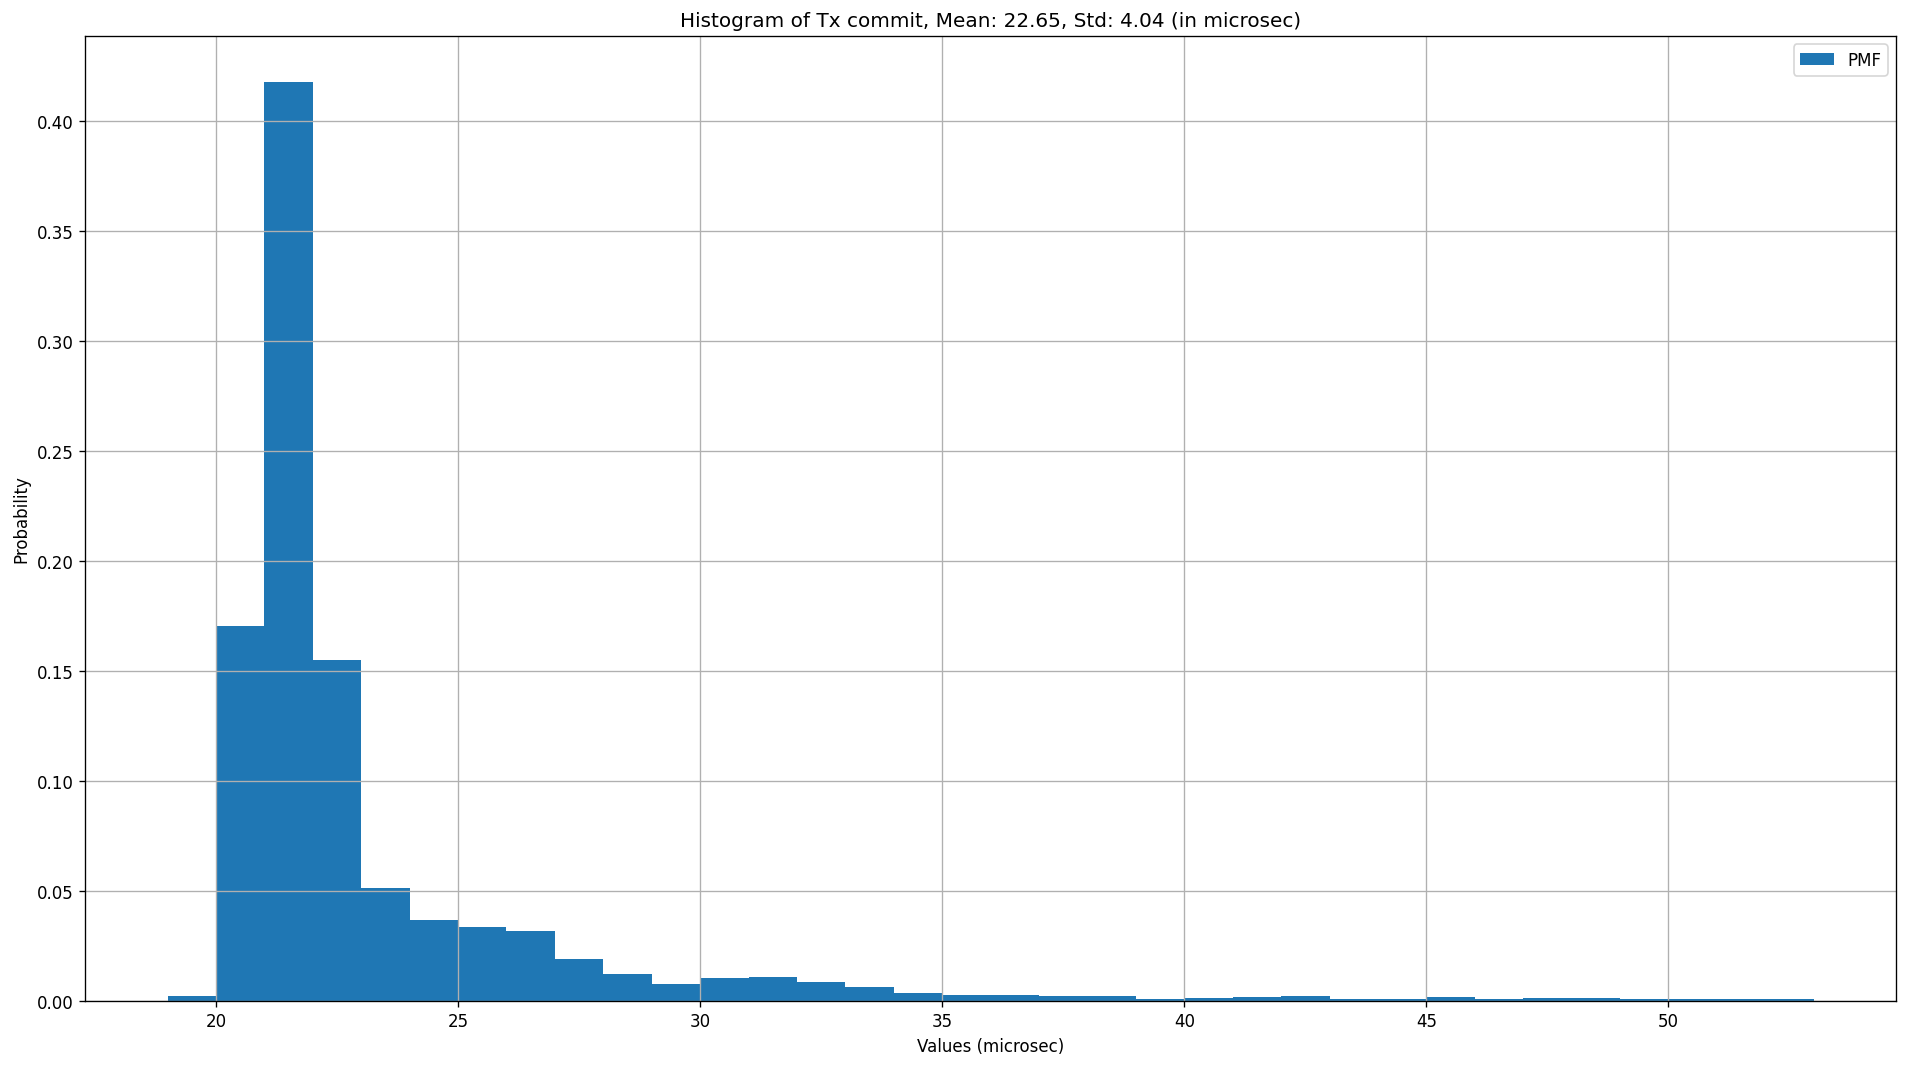

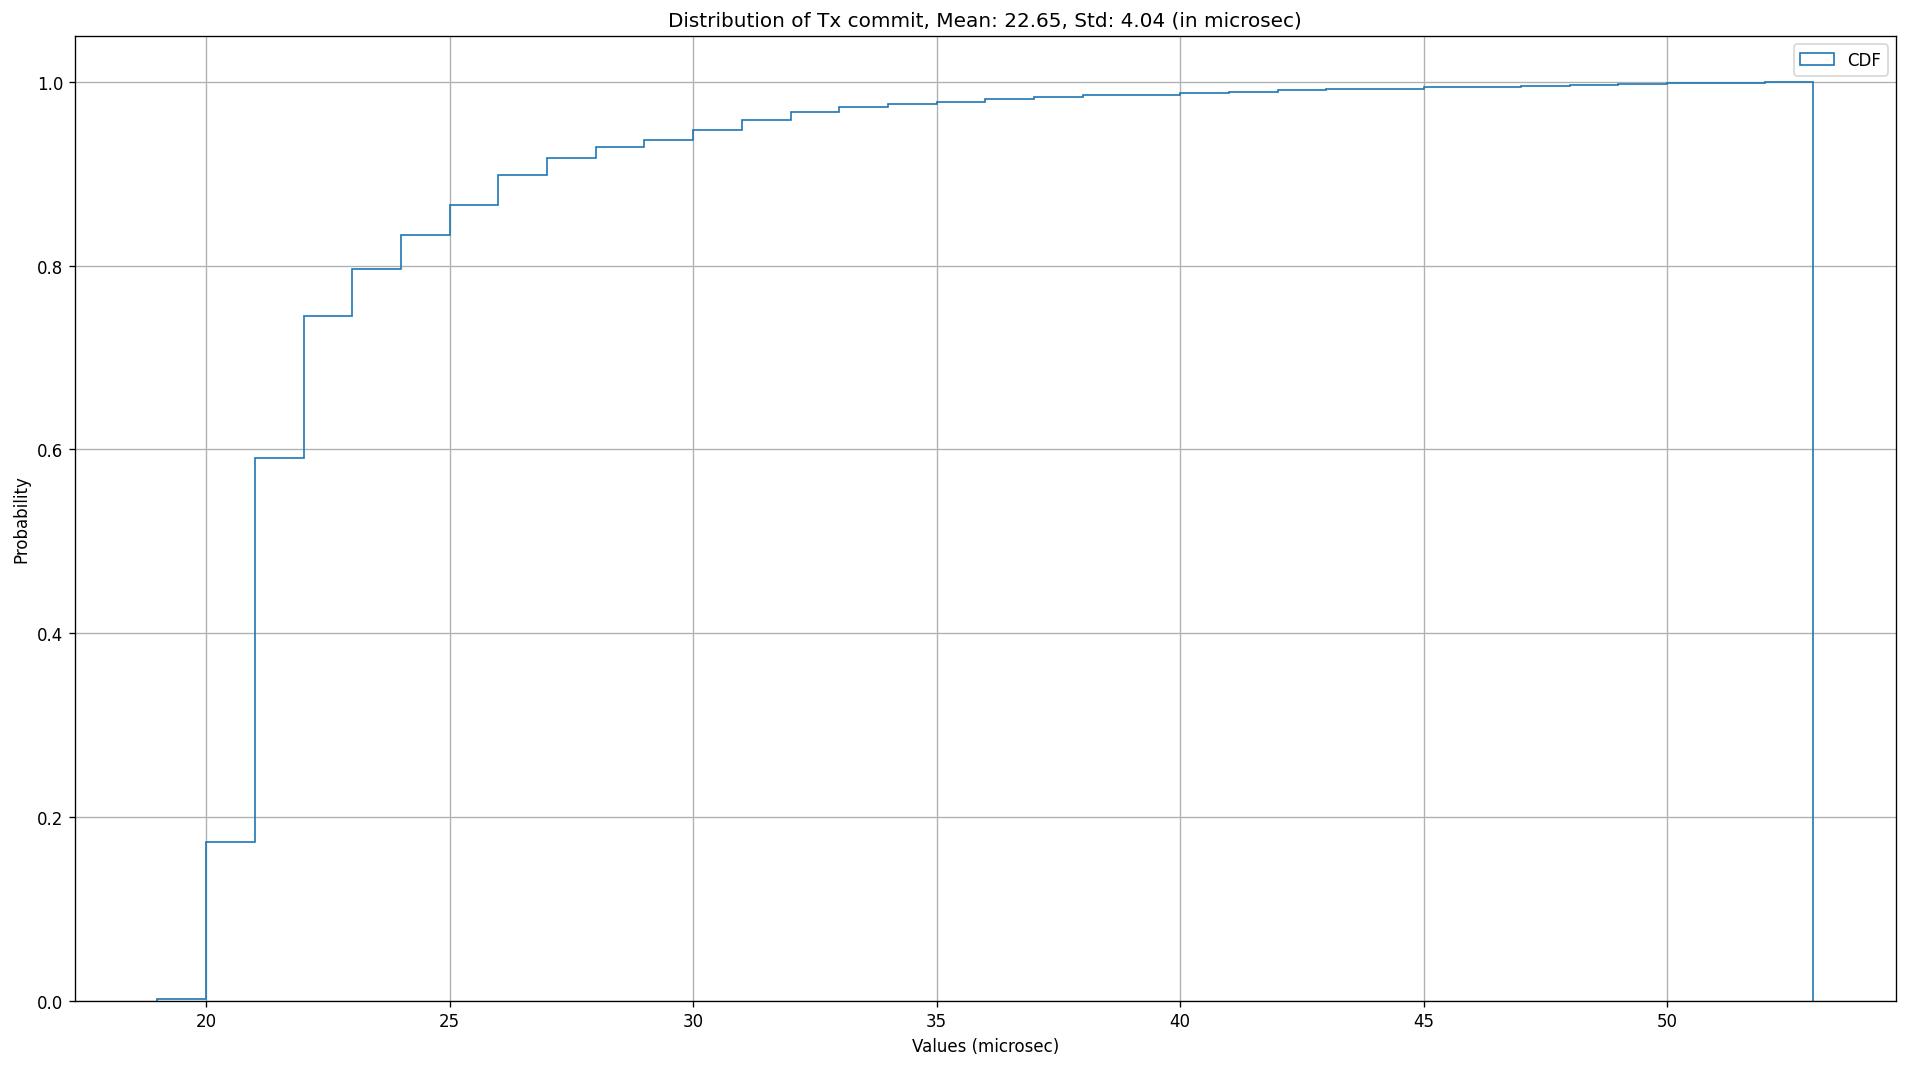

OU8 - TX Commit Features shape: (10000, 14)


Num of reads  Num of writes  Num of active txs  Thread pool size  \
0              100              0                  1                50   
1              100              0                  1                50   
2              100              0                  1                50   
3              100              0                  1                50   
4              100              0                  1                50   
...            ...            ...                ...               ...   
9995           100              0                  1                50   
9996           100              0                  1                50   
9997           100              0                  1                50   
9998           100              0                  1                50   
9999           100              0                  1                50   

      CPU utilization  Num of cache read  Num of cache insert  \
0                 2.0                200                    0   
1                 3.0                200                    0   
2                 4.0                200                    0   
3                 3.0                200                    0   
4                 3.0                200                    0   
...               ...                ...                  ...   
9995              2.0                200                    0   
9996              1.0                200                    0   
9997              1.0                200                    0   
9998              1.0                200                    0   
9999              1.0                200                    0   

      Num of cache update  Num of arithmetic operations  Num of write record  \
0                       0                             0                    0   
1                       0                             0                    0   
2                       0                             0                    0   
3                       0                             0                    0   
4                       0                             0                    0   
...                   ...                           ...                  ...   
9995                    0                             0                    0   
9996                    0                             0                    0   
9997                    0                             0                    0   
9998                    0                             0                    0   
9999                    0                             0                    0   

      Num of bytes  Num of read write record  Num of log flush bytes  \
0                0                       100                       0   
1                0                       100                       0   
2                0                       100                       0   
3                0                       100                       0   
4                0                       100                       0   
...            ...                       ...                     ...   
9995             0                       100                       0   
9996             0                       100                       0   
9997             0                       100                       0   
9998             0                       100                       0   
9999             0                       100                       0   

      Num of Threads  
0                 51  
1                 57  
2                 62  
3                 63  
4                 67  
...              ...  
9995              67  
9996              67  
9997              67  
9998              67  
9999              67  

[10000 rows x 14 columns]

OU8 - TX Commit Targets shape: (10000,)


0       48968
1       50578
2       49003
3       49397
4       48693
        ...  
9995    20544
9996    21311
9997    21142
9998    21406
9999    20829
Name: Tx commit, Length: 10000, dtype: int64

In [76]:
# Features
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes',
                'Num of Threads'
                ]
# Prediction Targets
targetName = 'Tx commit'

# Create path for OU
figPathOU = makePath(figPath, targetName)
modelPathOU = makePath(modelPath, targetName)

# Prepare Data
commitFeatures, commitTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
                                            warmupDrop=warmupDrop, outlinerDrop=outlinerDropR, sample=sampleN, histUnit=histUnit, isSaveFig=isSaveFig, isSC=isSC)
print(f'OU8 - TX Commit Features shape: {commitFeatures.shape}')
display(commitFeatures)
print(f'OU8 - TX Commit Targets shape: {commitTargets.shape}')
display(commitTargets)

X_train, X_test, y_train, y_test = train_test_split(commitFeatures, commitTargets, test_size=testSize, random_state=randomState)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.0908/0.0909
Best Params: {'alpha': 1.0, 'gamma': 2.0, 'kernel': 'rbf'}


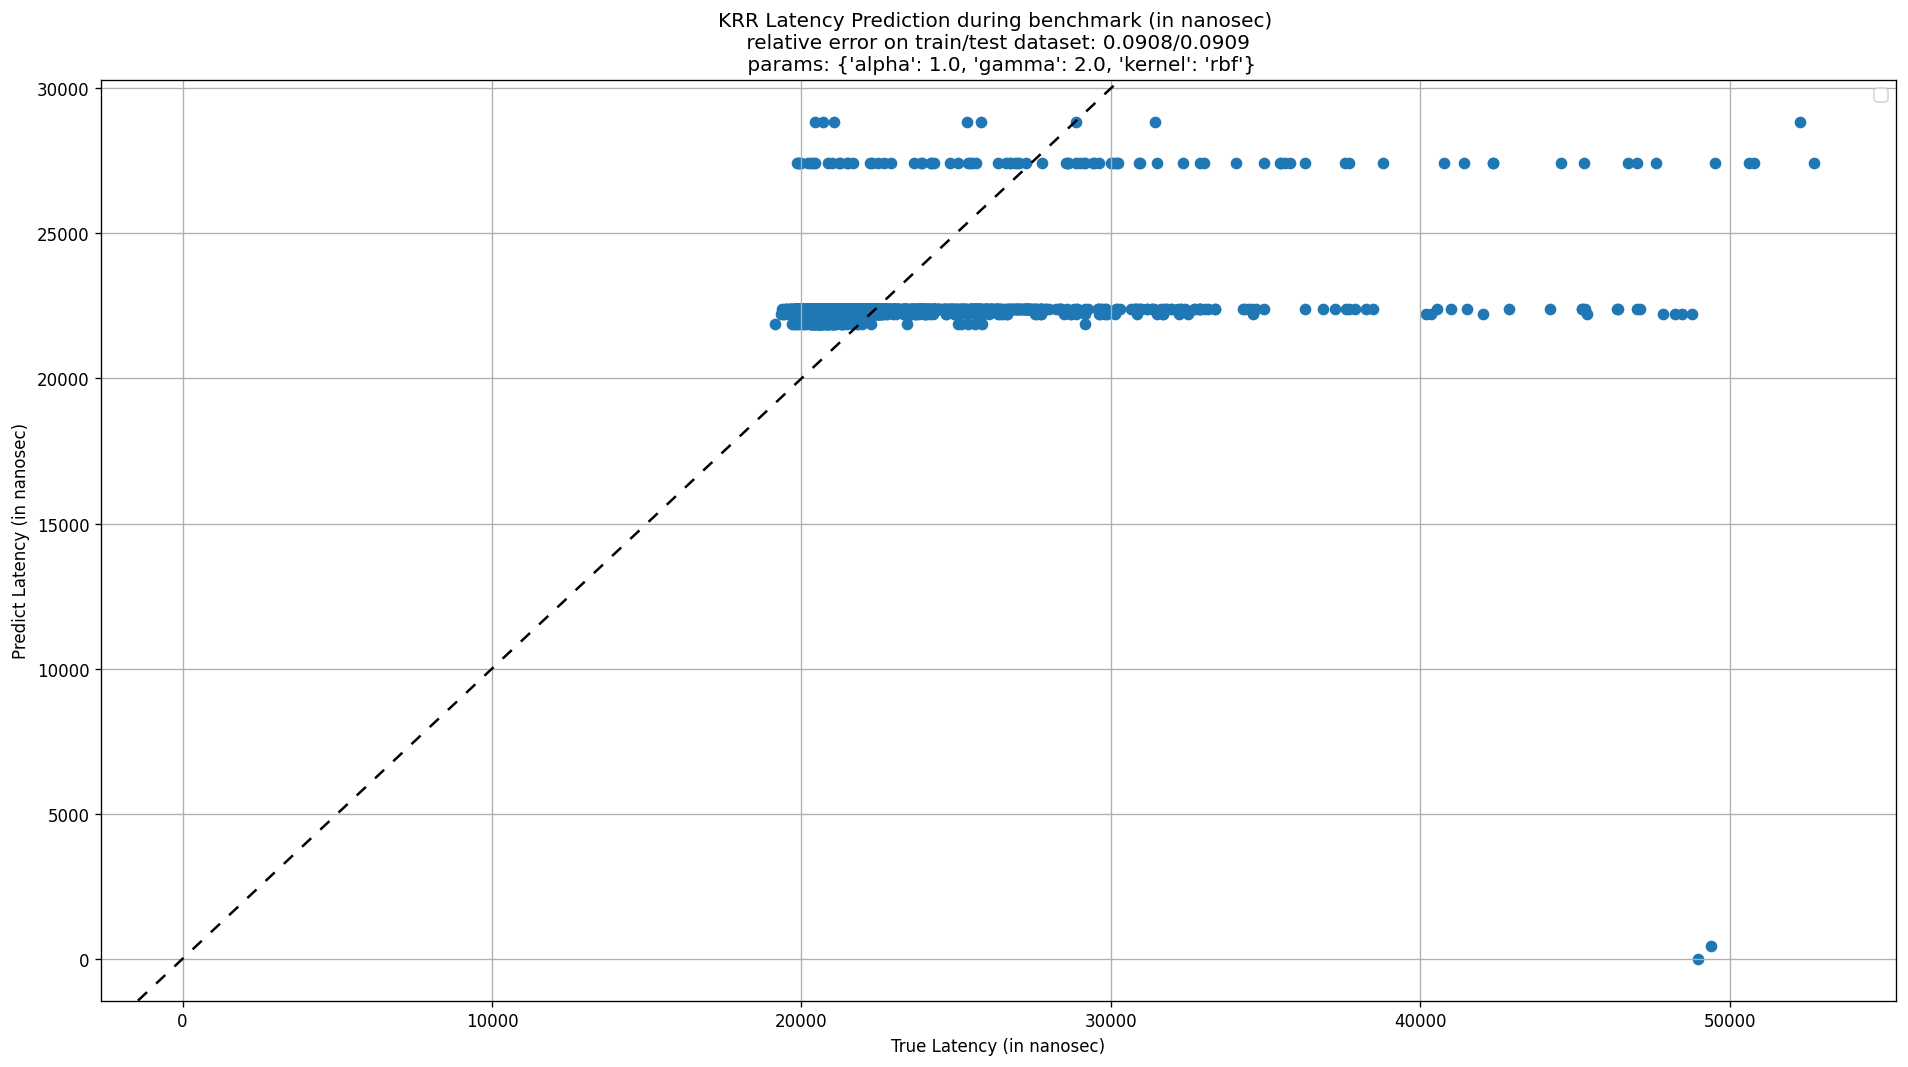

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.07130553 -0.07128333
 -0.07126545 -0.07125228 -0.07128577 -0.07124275 -0.07120648 -0.07118005
 -0.07125616 -0.0711643  -0.0710997  -0.07106282 -0.07121072 -0.07105331
 -0.07093464 -0.07090176]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.0709/0.0733
Best Params: {'C': 4.0, 'gamma': 2.0, 'kernel': 'rbf'}


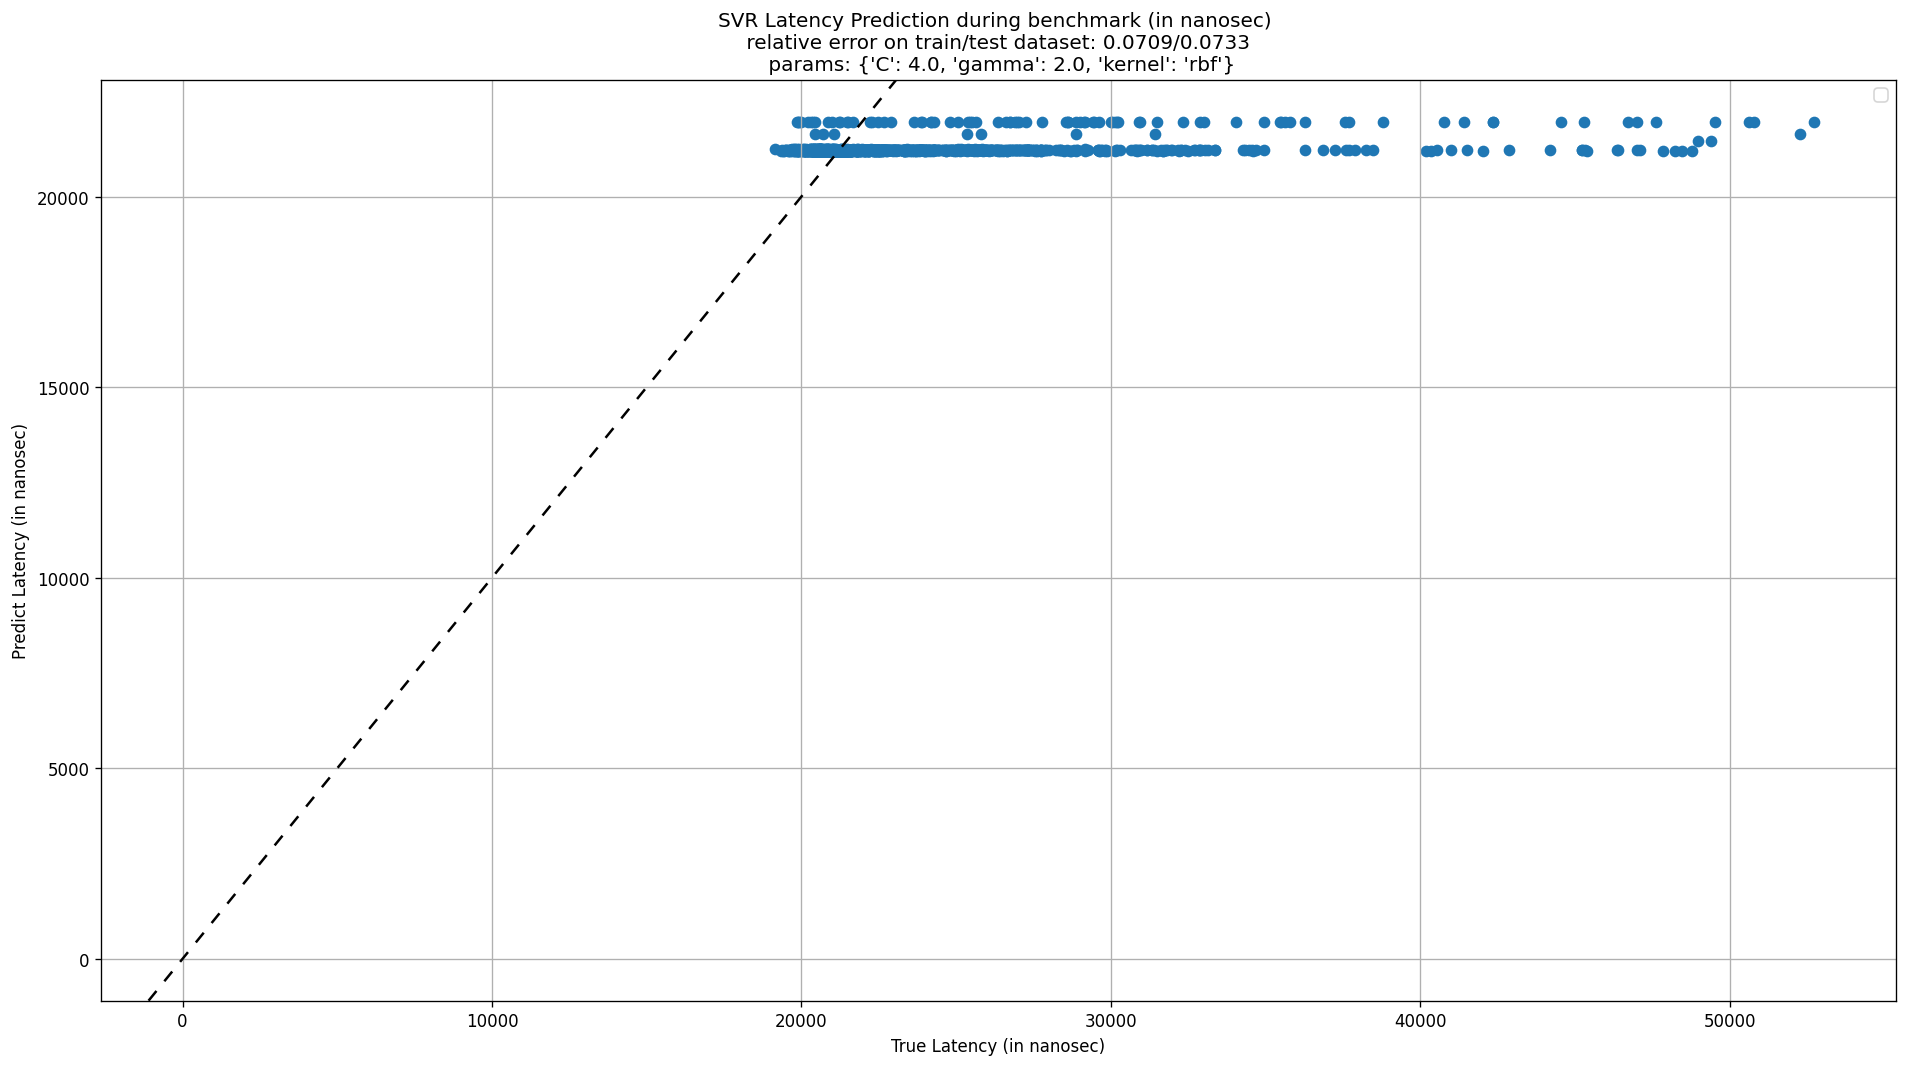

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.071/0.0739
Best Params: {'alpha': 1, 'epsilon': 1.1}


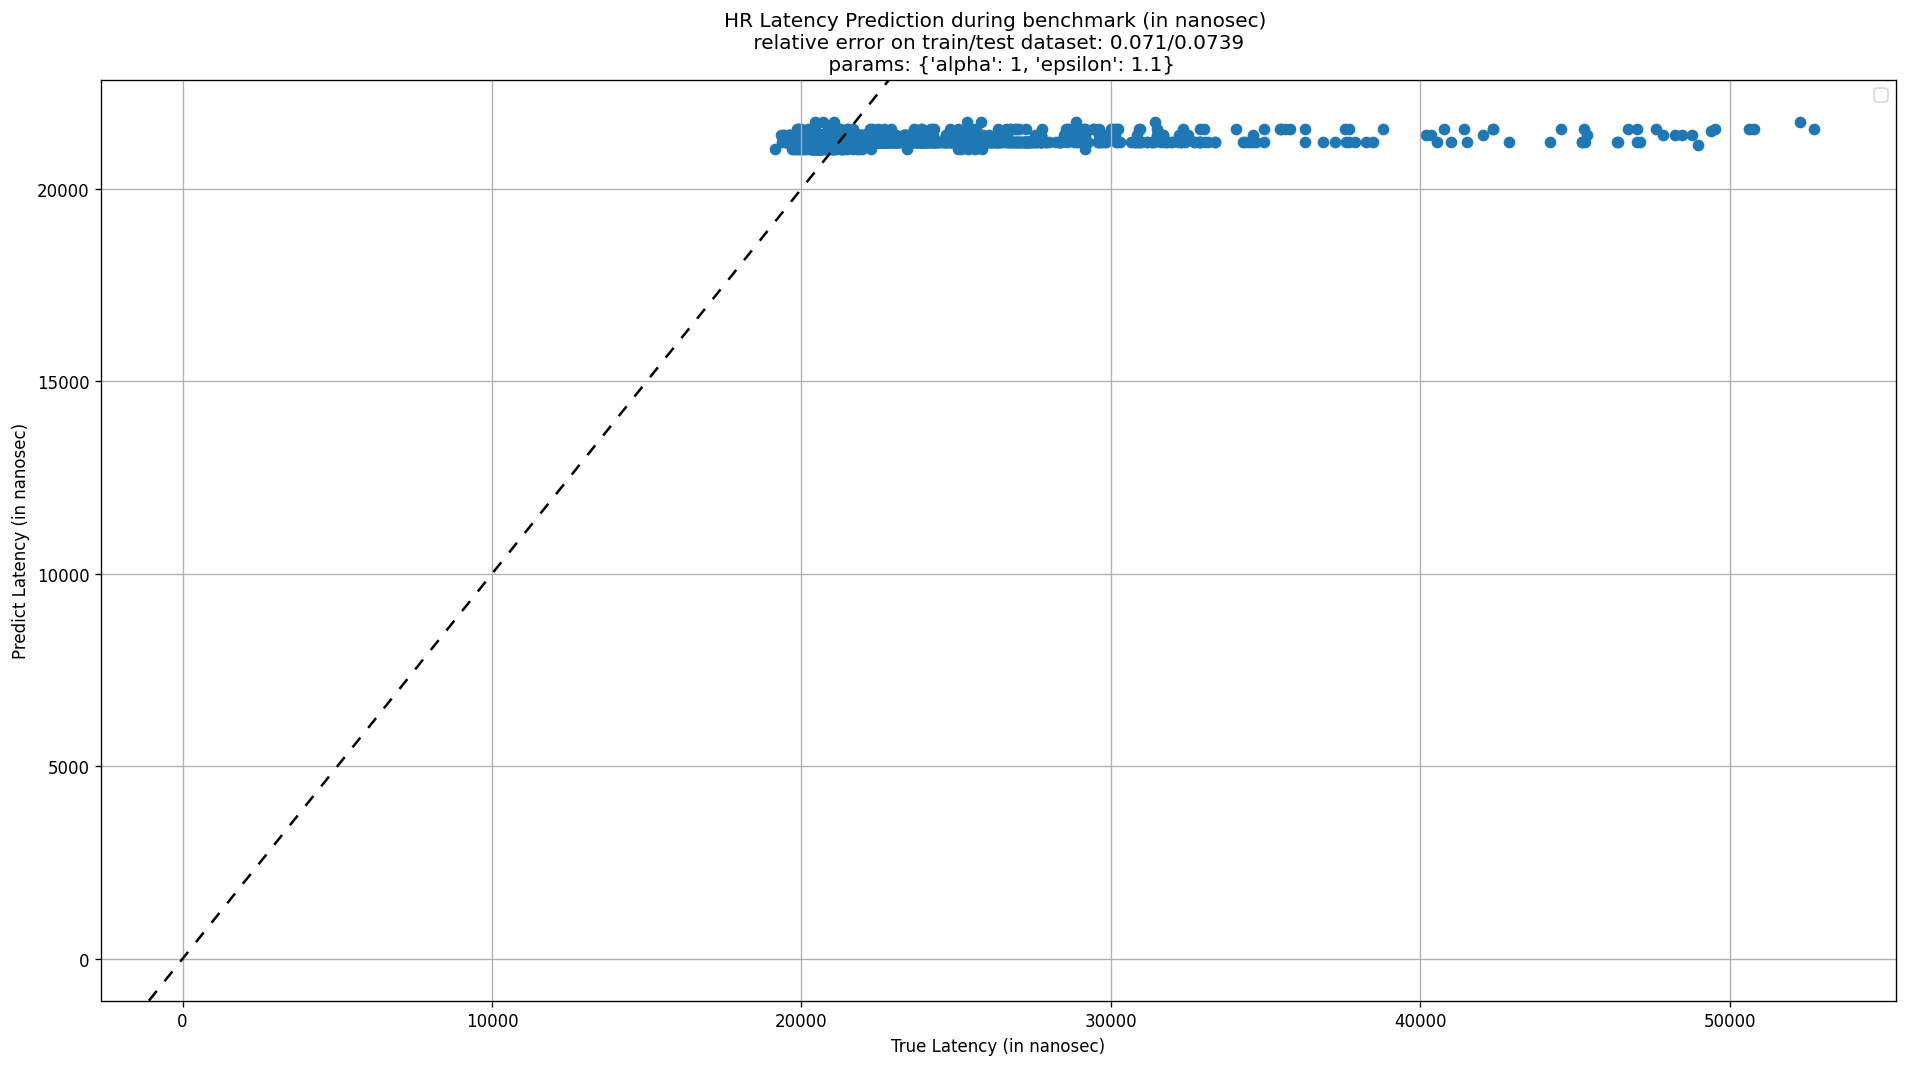

Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Best training/testing score: 0.0702/0.0714
Best Params: {'criterion': 'mae', 'max_depth': 5, 'n_estimators': 500, 'n_jobs': None, 'random_state': 0}


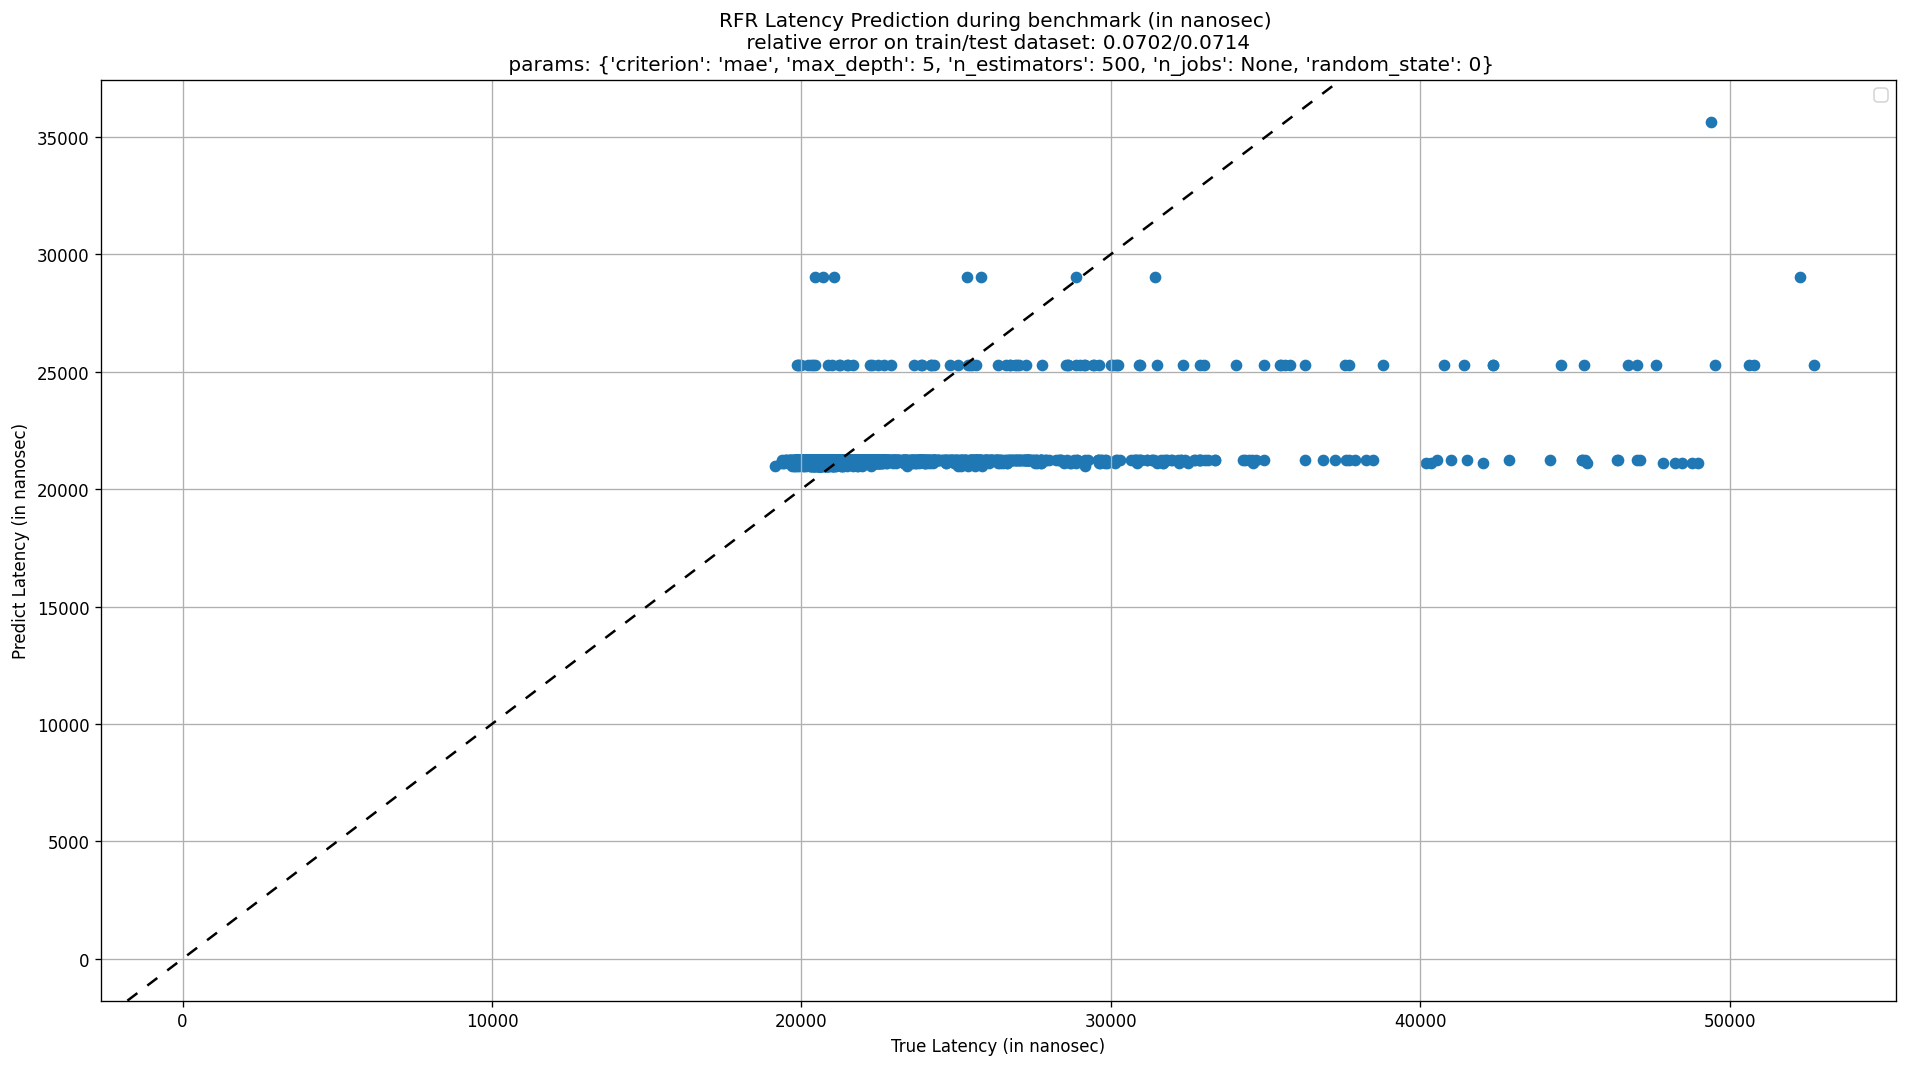

[(GridSearchCV(estimator=KernelRidge(), n_jobs=-1,
               param_grid={'alpha': [1.0], 'gamma': [0.1, 0.5, 1.0, 2.0],
                           'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.0908,
  0.0909),
 (GridSearchCV(estimator=SVR(), n_jobs=-1,
               param_grid={'C': [0, 0.5, 1.0, 2.0, 4.0],
                           'gamma': [0.1, 0.5, 1.0, 2.0], 'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.0709,
  0.0733),
 (GridSearchCV(estimator=HuberRegressor(), n_jobs=-1,
               param_grid={'alpha': [0, 0.0001, 0.01, 0.1, 1],
                           'epsilon': [1.1, 1.35, 2, 5]},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.071,
  0.0739),
 (GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
               param_grid={'criterion': ['mse', 'mae'],
                           'max_depth': [3, 5, 7, 10],
                      

In [77]:
Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                        figPath=figPathOU, modelPath=modelPathOU, isSaveFig=isSaveFig, isSaveModel=isSaveModel, n_jobs=-1) for m in modelList)

Warm Up Drop Timestamp: 412862681
In microsec, Number of bins: 951, nBins: [ 791.  792.  793.  794.  795.  796.  797.  798.  799.  800.  801.  802.
  803.  804.  805.  806.  807.  808.  809.  810.  811.  812.  813.  814.
  815.  816.  817.  818.  819.  820.  821.  822.  823.  824.  825.  826.
  827.  828.  829.  830.  831.  832.  833.  834.  835.  836.  837.  838.
  839.  840.  841.  842.  843.  844.  845.  846.  847.  848.  849.  850.
  851.  852.  853.  854.  855.  856.  857.  858.  859.  860.  861.  862.
  863.  864.  865.  866.  867.  868.  869.  870.  871.  872.  873.  874.
  875.  876.  877.  878.  879.  880.  881.  882.  883.  884.  885.  886.
  887.  888.  889.  890.  891.  892.  893.  894.  895.  896.  897.  898.
  899.  900.  901.  902.  903.  904.  905.  906.  907.  908.  909.  910.
  911.  912.  913.  914.  915.  916.  917.  918.  919.  920.  921.  922.
  923.  924.  925.  926.  927.  928.  929.  930.  931.  932.  933.  934.
  935.  936.  937.  938.  939.  940.  941.  942. 

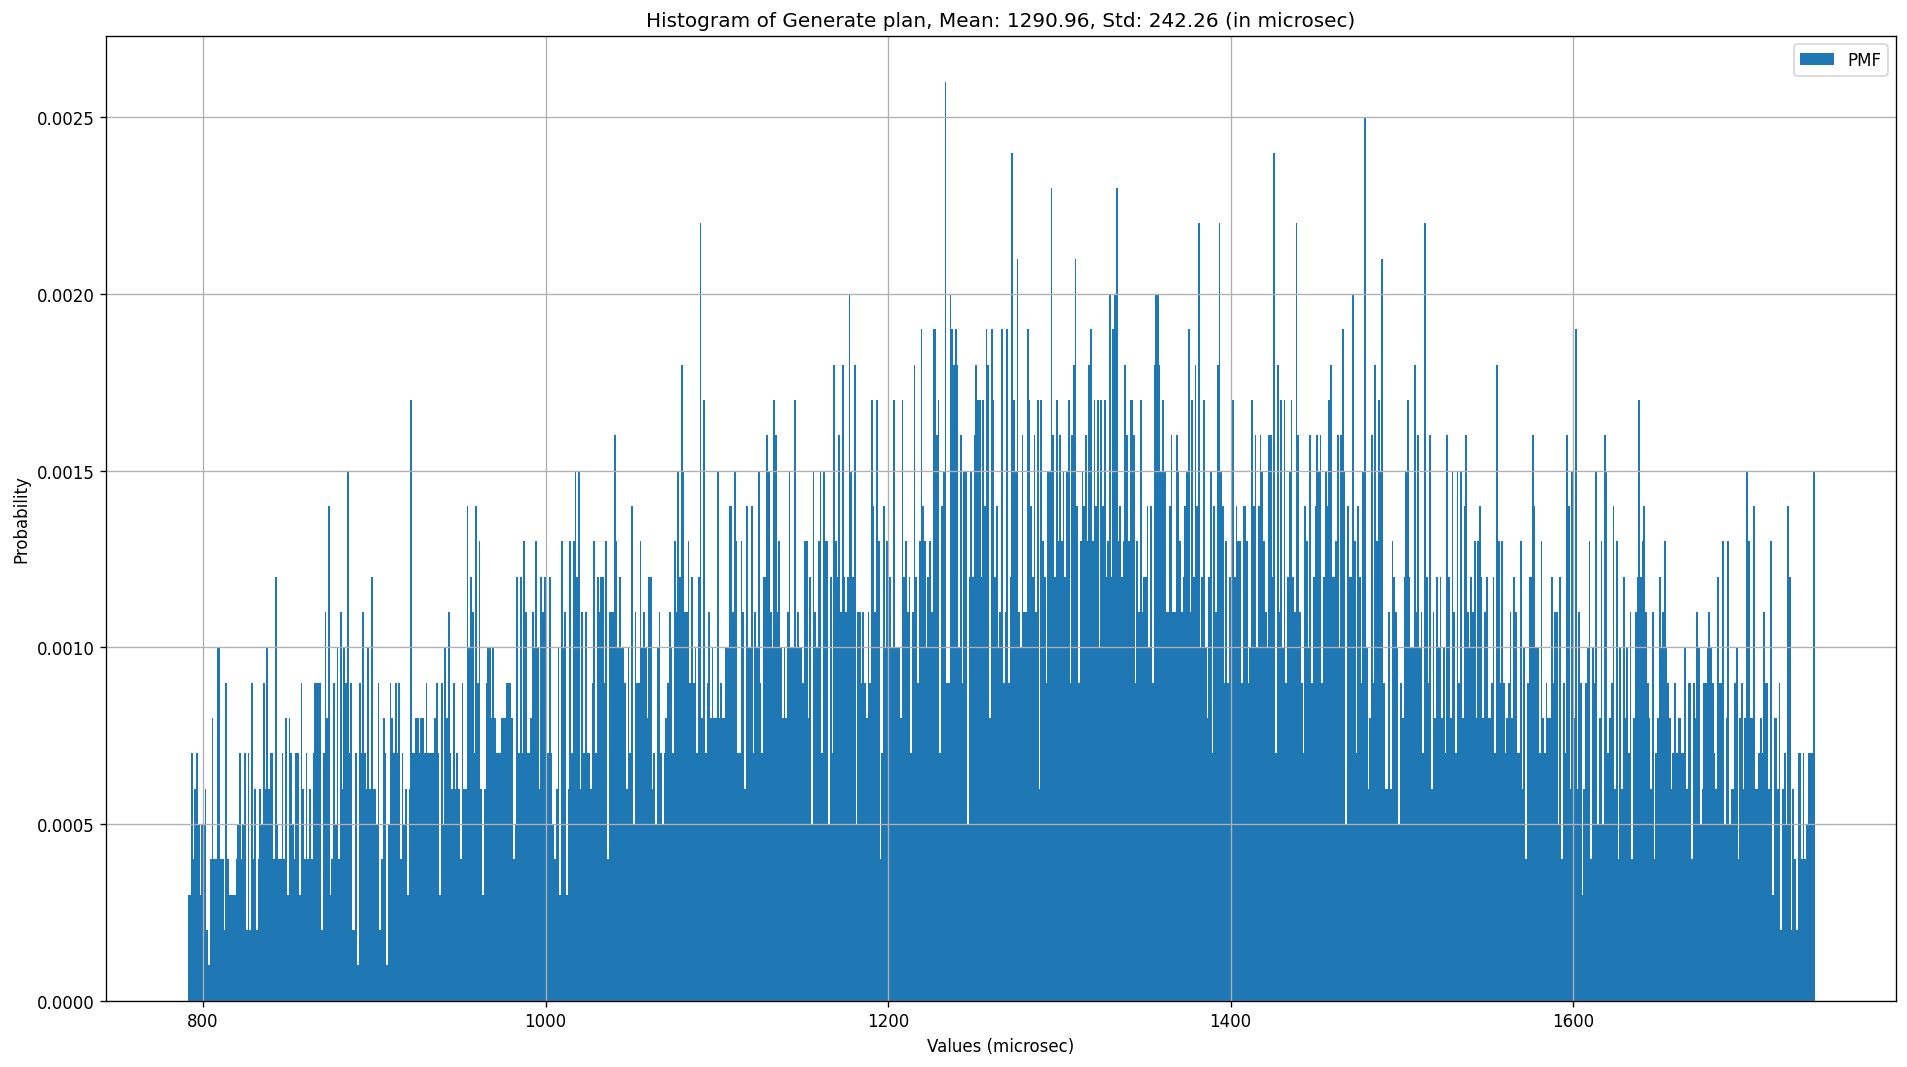

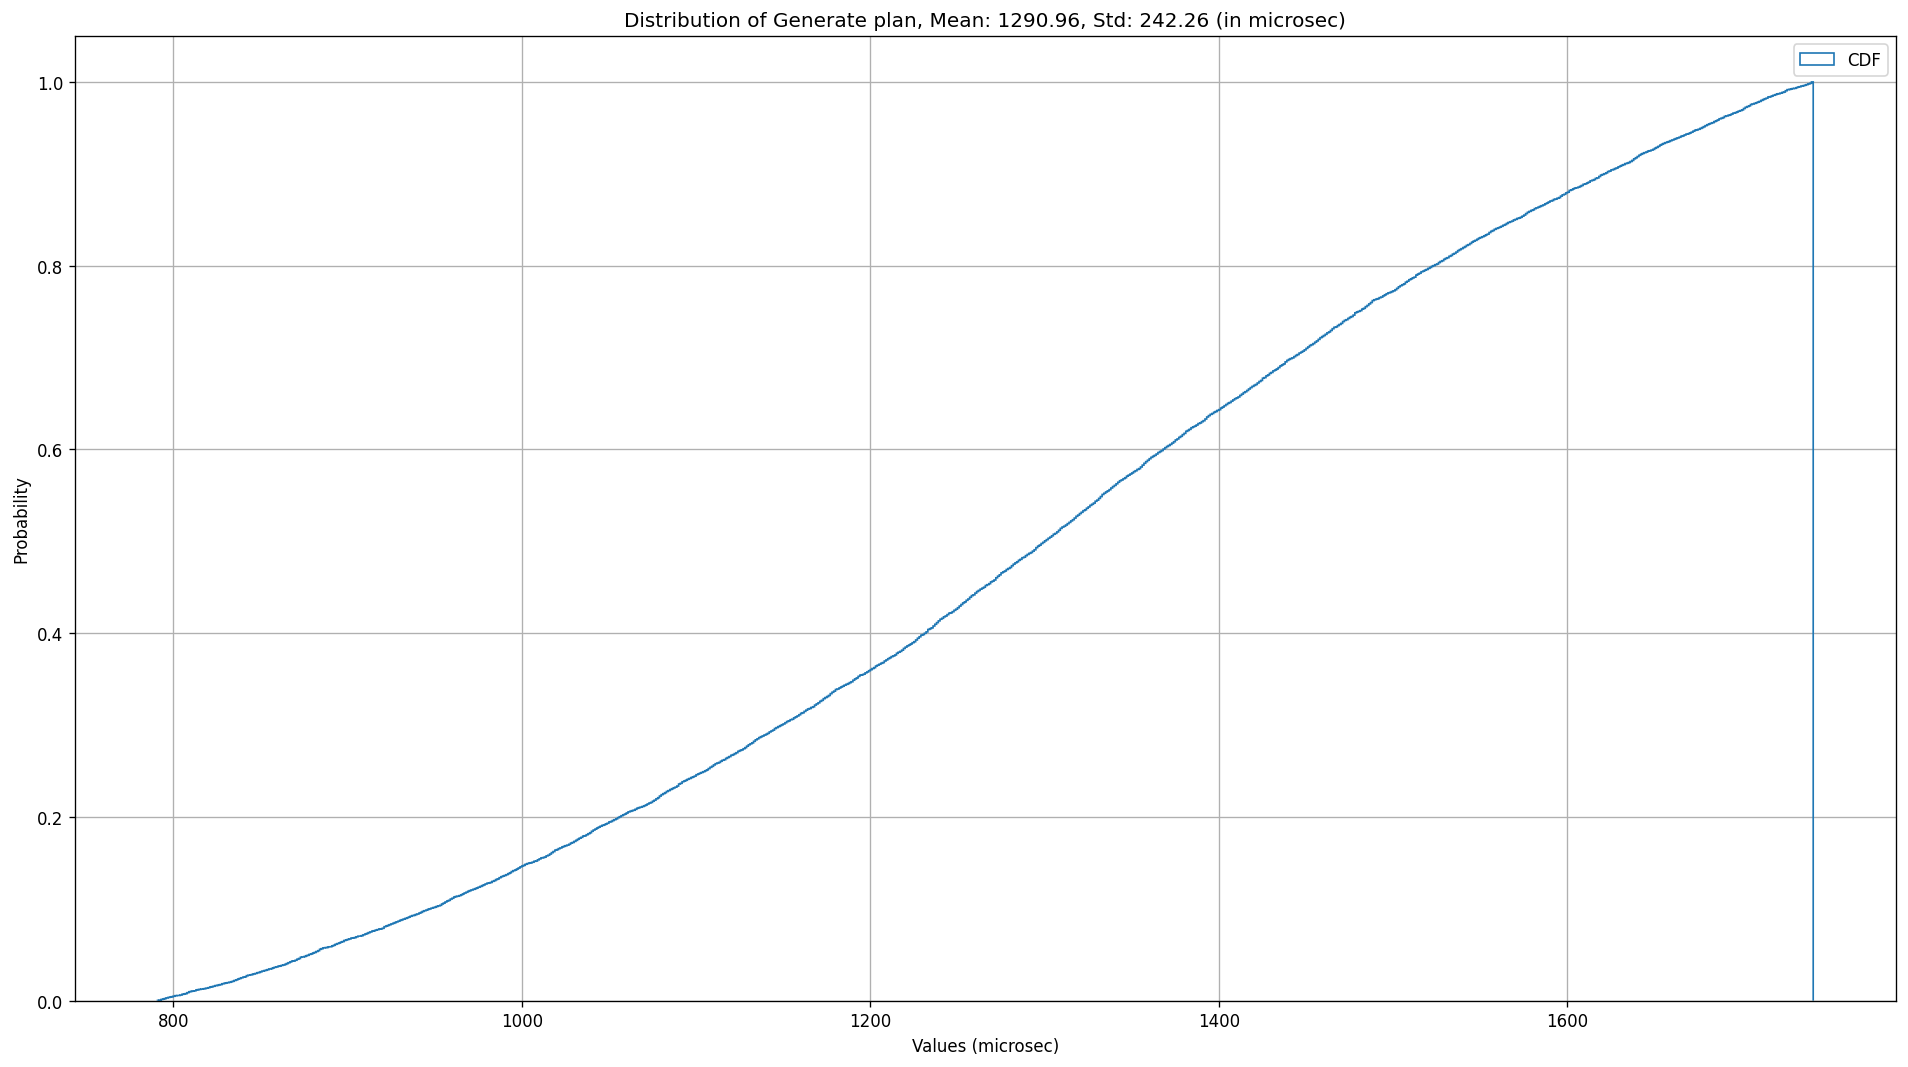

OU - Generate plan Features shape: (10000, 14)


Num of reads  Num of writes  Num of active txs  Thread pool size  \
0              100              0                  1                50   
1              100              0                  1                50   
2              100              0                  1                50   
3              100              0                  1                50   
4              100              0                  1                50   
...            ...            ...                ...               ...   
9995           100              0                  1                50   
9996           100              0                  1                50   
9997           100              0                  1                50   
9998           100              0                  1                50   
9999           100              0                  1                50   

      CPU utilization  Num of cache read  Num of cache insert  \
0                 3.0                200                    0   
1                 2.0                200                    0   
2                 0.0                200                    0   
3                 1.0                200                    0   
4                 1.0                200                    0   
...               ...                ...                  ...   
9995              1.0                200                    0   
9996              1.0                200                    0   
9997              1.0                200                    0   
9998              2.0                200                    0   
9999              2.0                200                    0   

      Num of cache update  Num of arithmetic operations  Num of write record  \
0                       0                             0                    0   
1                       0                             0                    0   
2                       0                             0                    0   
3                       0                             0                    0   
4                       0                             0                    0   
...                   ...                           ...                  ...   
9995                    0                             0                    0   
9996                    0                             0                    0   
9997                    0                             0                    0   
9998                    0                             0                    0   
9999                    0                             0                    0   

      Num of bytes  Num of read write record  Num of log flush bytes  \
0                0                       100                       0   
1                0                       100                       0   
2                0                       100                       0   
3                0                       100                       0   
4                0                       100                       0   
...            ...                       ...                     ...   
9995             0                       100                       0   
9996             0                       100                       0   
9997             0                       100                       0   
9998             0                       100                       0   
9999             0                       100                       0   

      Num of Threads  
0                 53  
1                 67  
2                 67  
3                 67  
4                 67  
...              ...  
9995              67  
9996              67  
9997              67  
9998              67  
9999              67  

[10000 rows x 14 columns]

OU - Generate plan Targets shape: (10000,)


0       1074099
1        791247
2        820378
3        849617
4        897144
         ...   
9995    1282252
9996    1352545
9997    1382493
9998    1255441
9999    1350763
Name: Generate plan, Length: 10000, dtype: int64

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1636/0.1722
Best Params: {'alpha': 1.0, 'gamma': 2.0, 'kernel': 'rbf'}


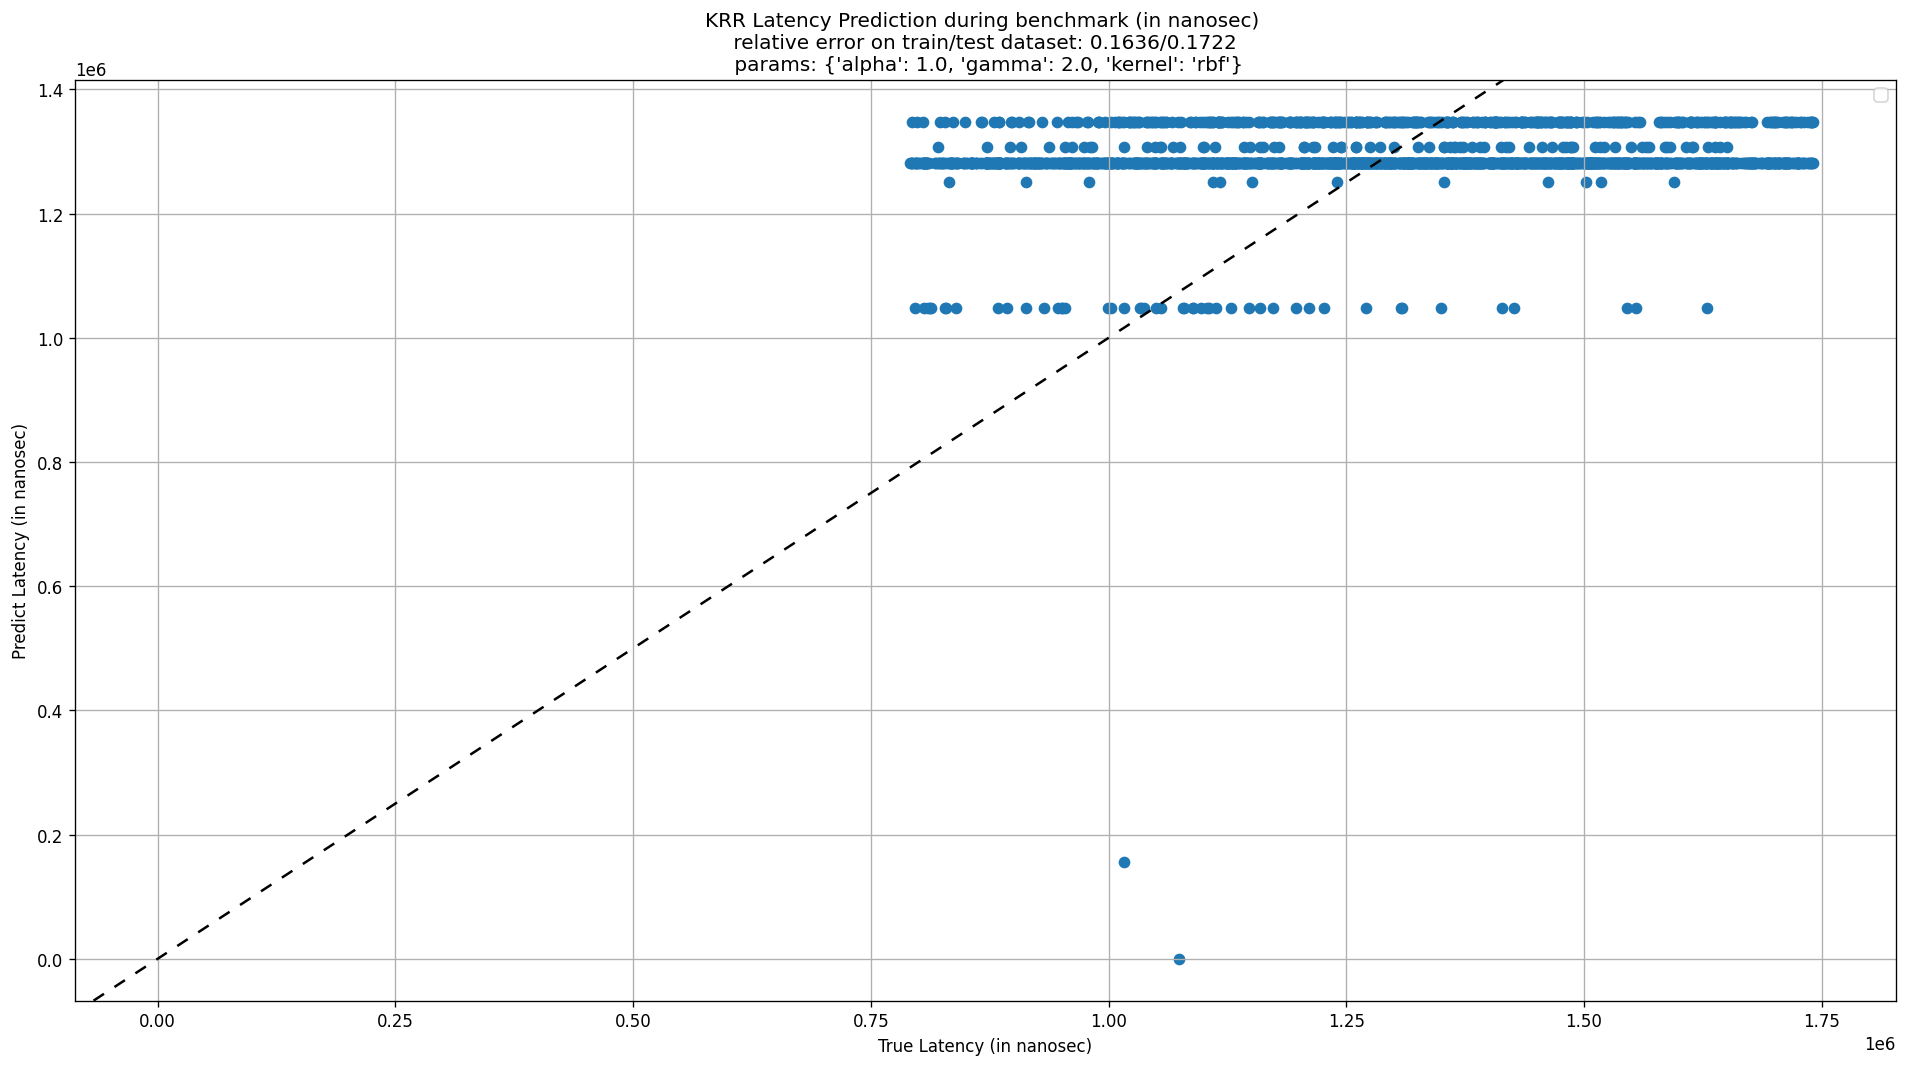

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.16876607 -0.16876339
 -0.16875878 -0.16875435 -0.16876589 -0.16875934 -0.1687516  -0.16874467
 -0.16876539 -0.1687523  -0.16874113 -0.16873488 -0.16876435 -0.1687419
 -0.16872904 -0.16870873]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.1687/0.1755
Best Params: {'C': 4.0, 'gamma': 2.0, 'kernel': 'rbf'}


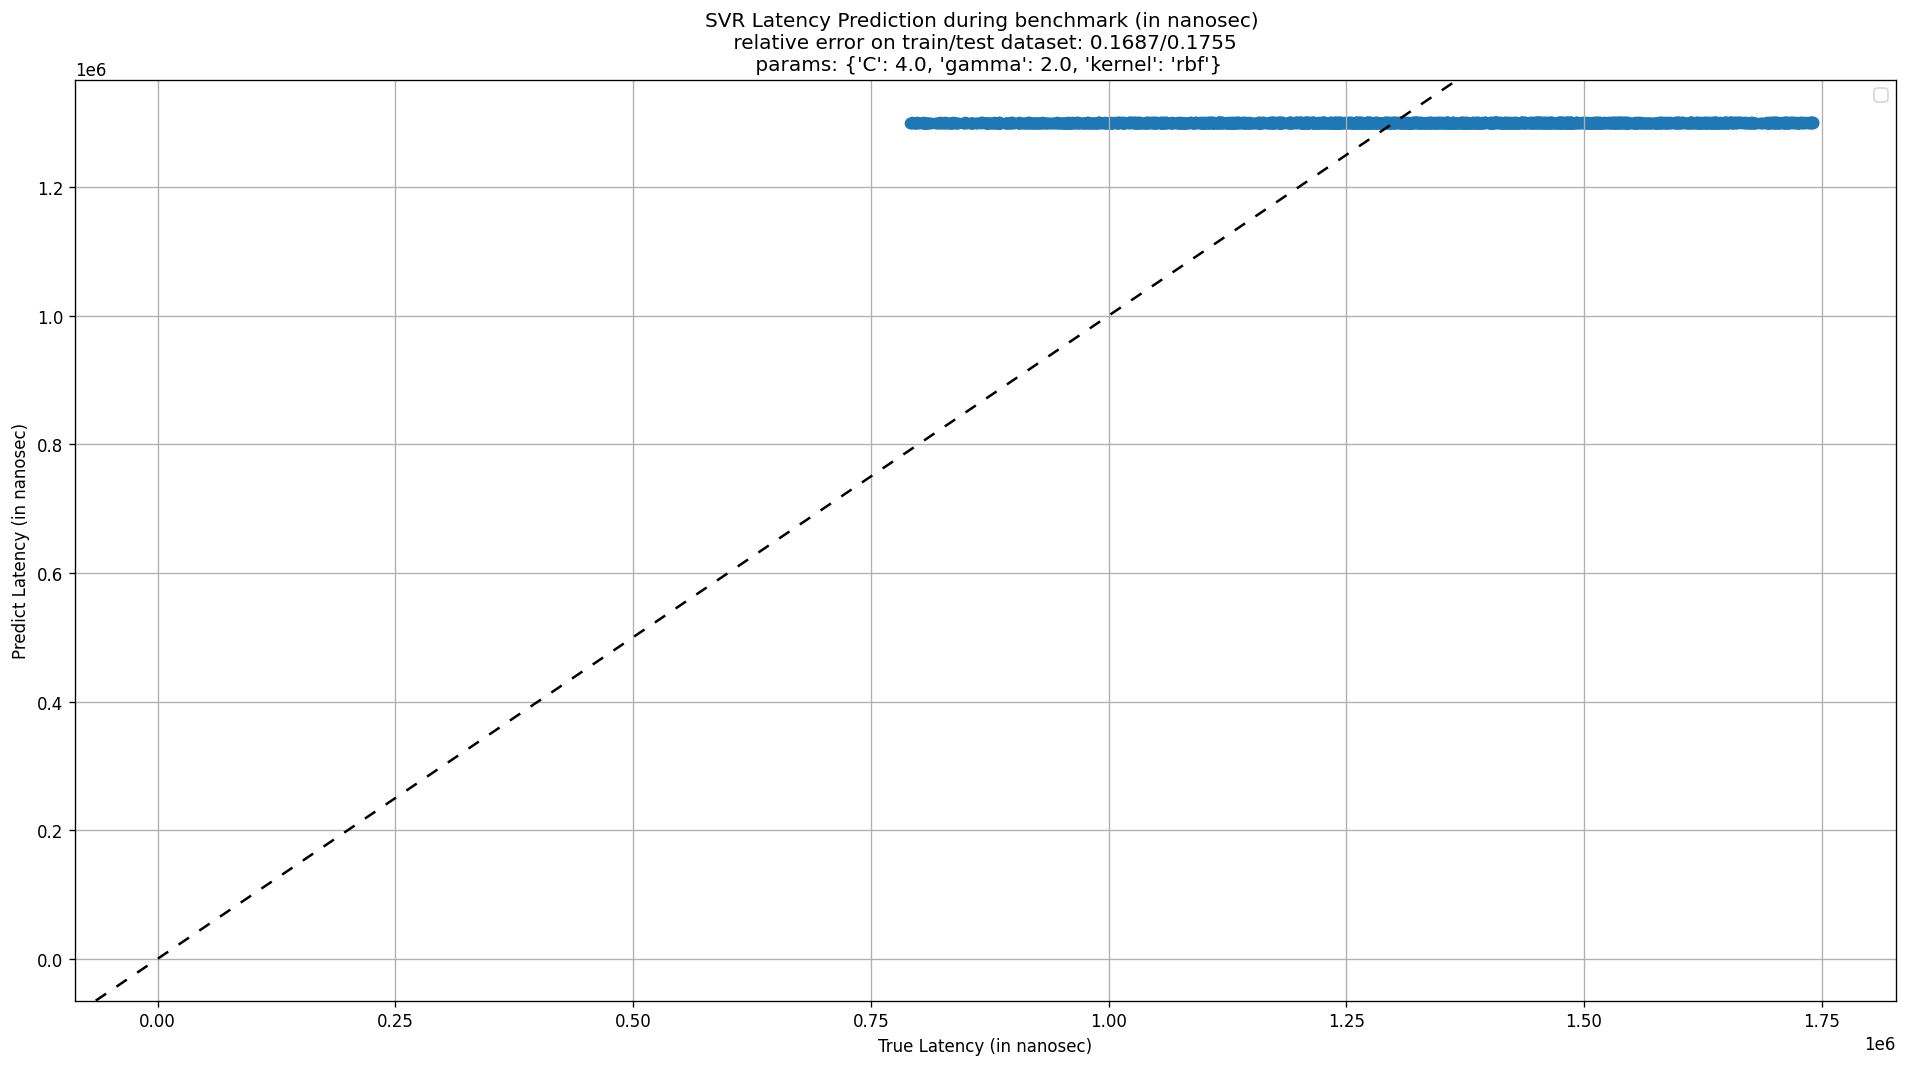

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1675/0.1744
Best Params: {'alpha': 1, 'epsilon': 2}


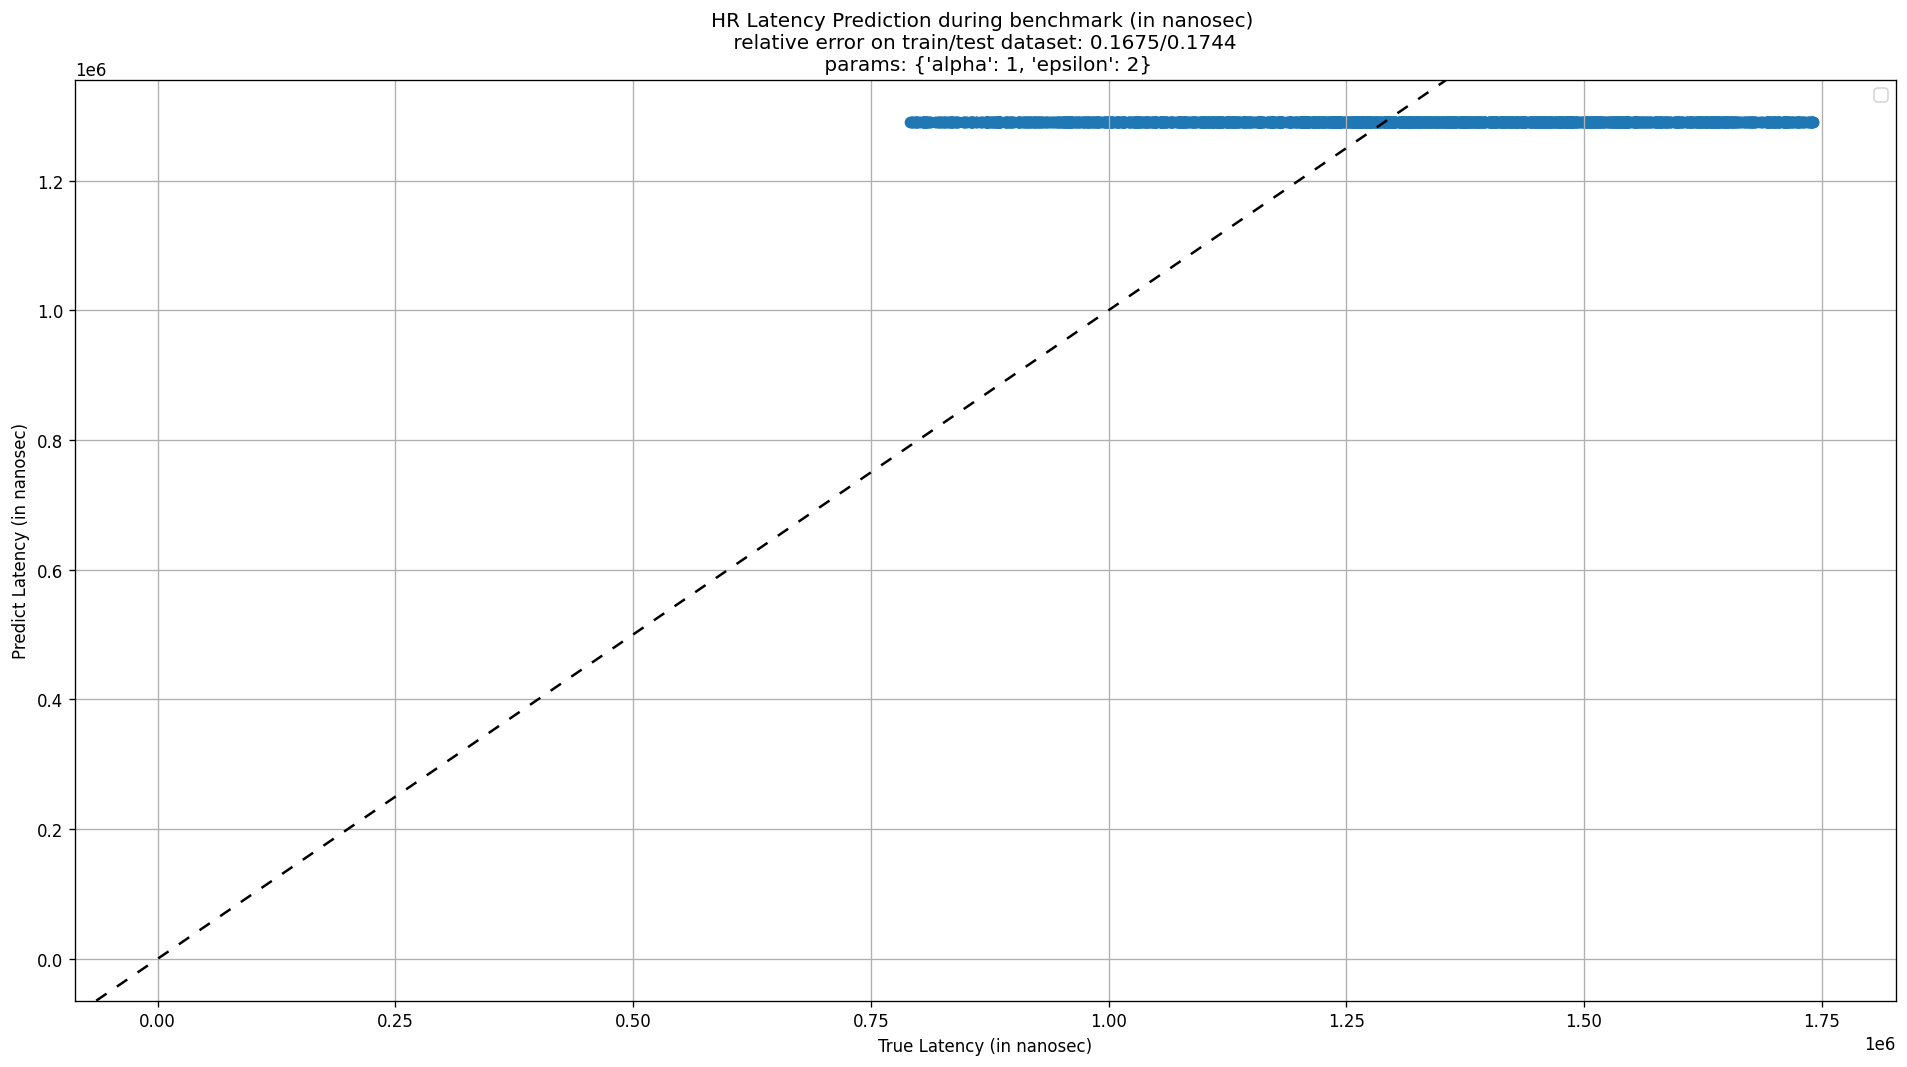

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 

In [88]:
# rt.fit(featureNames=featureNames, targetName=targetName)

# Write Back To Storage

Warm Up Drop Timestamp: 412862681
In microsec, Number of bins: 34, nBins: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 30. 35. 37. 38. 44. 46. 50. 51. 69.]
Mean Latency: 3.21, Std Latency: 1.95 (microsec)


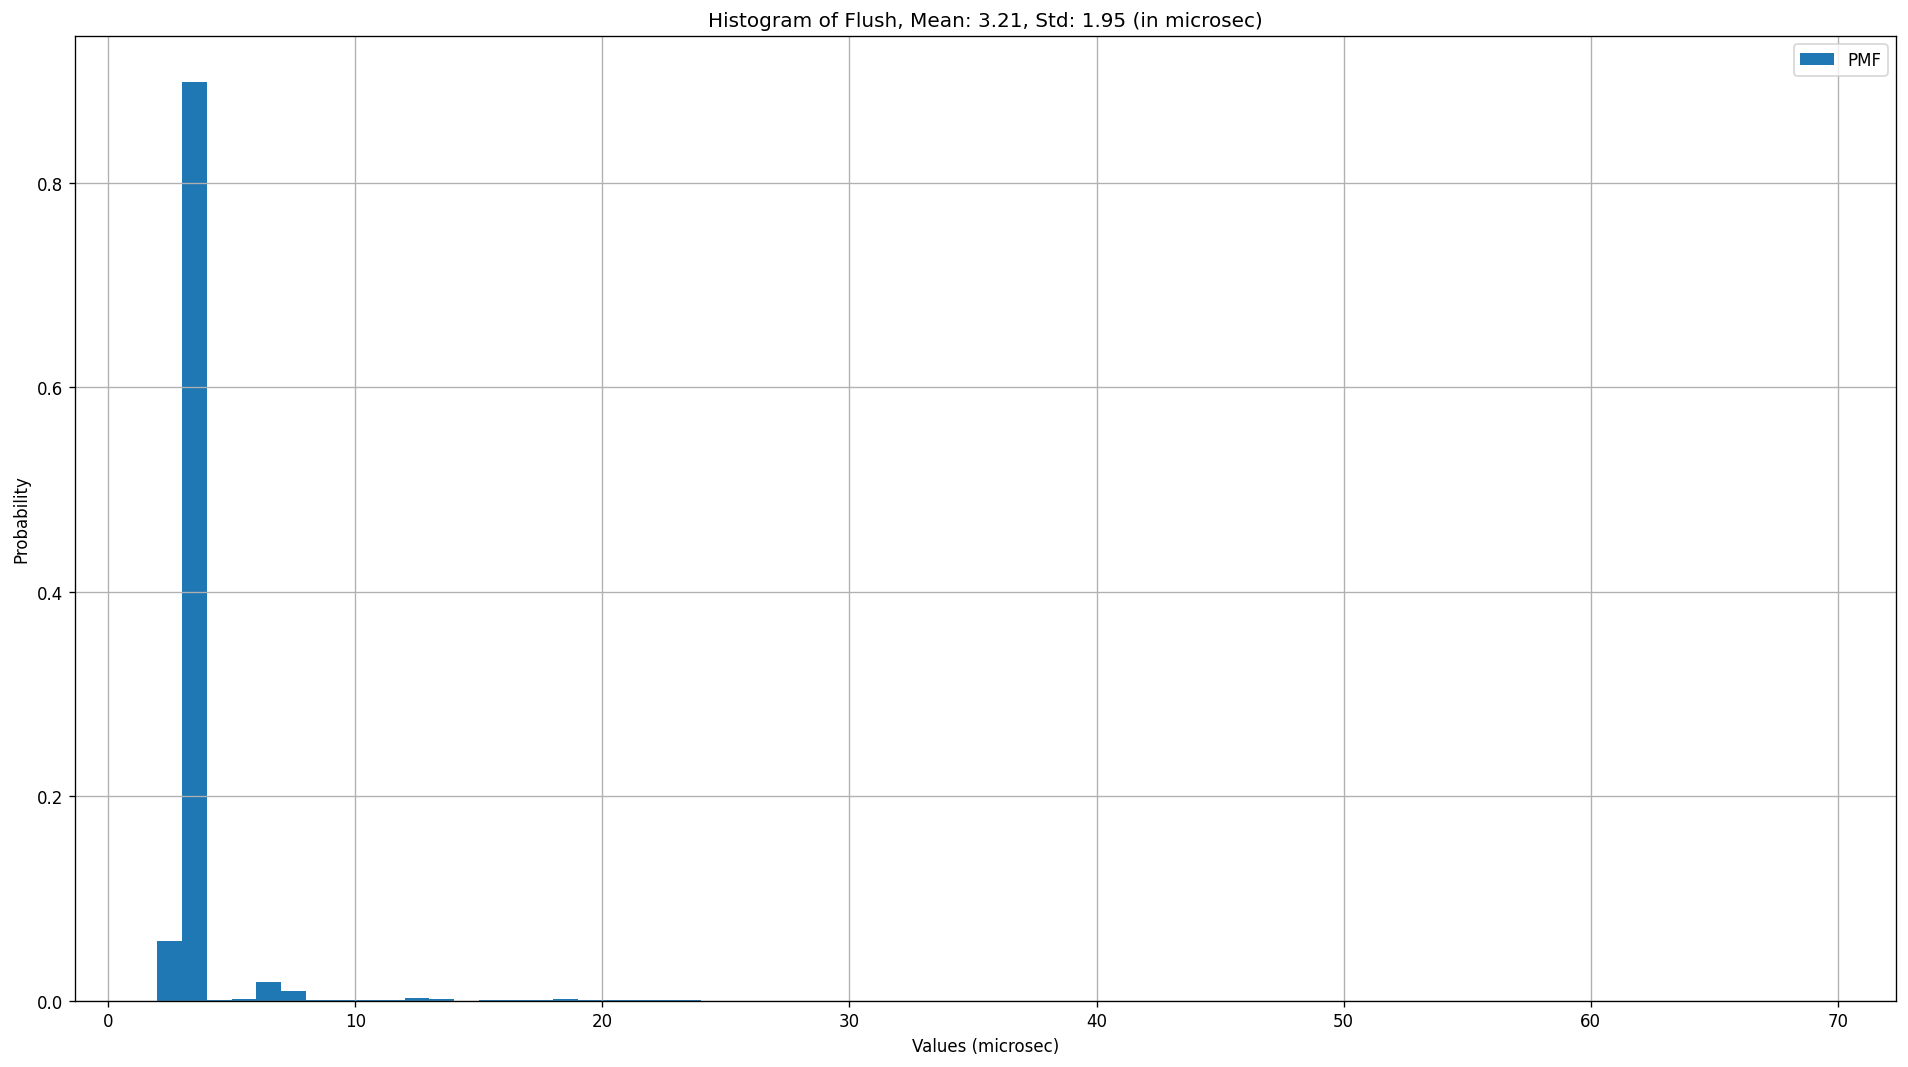

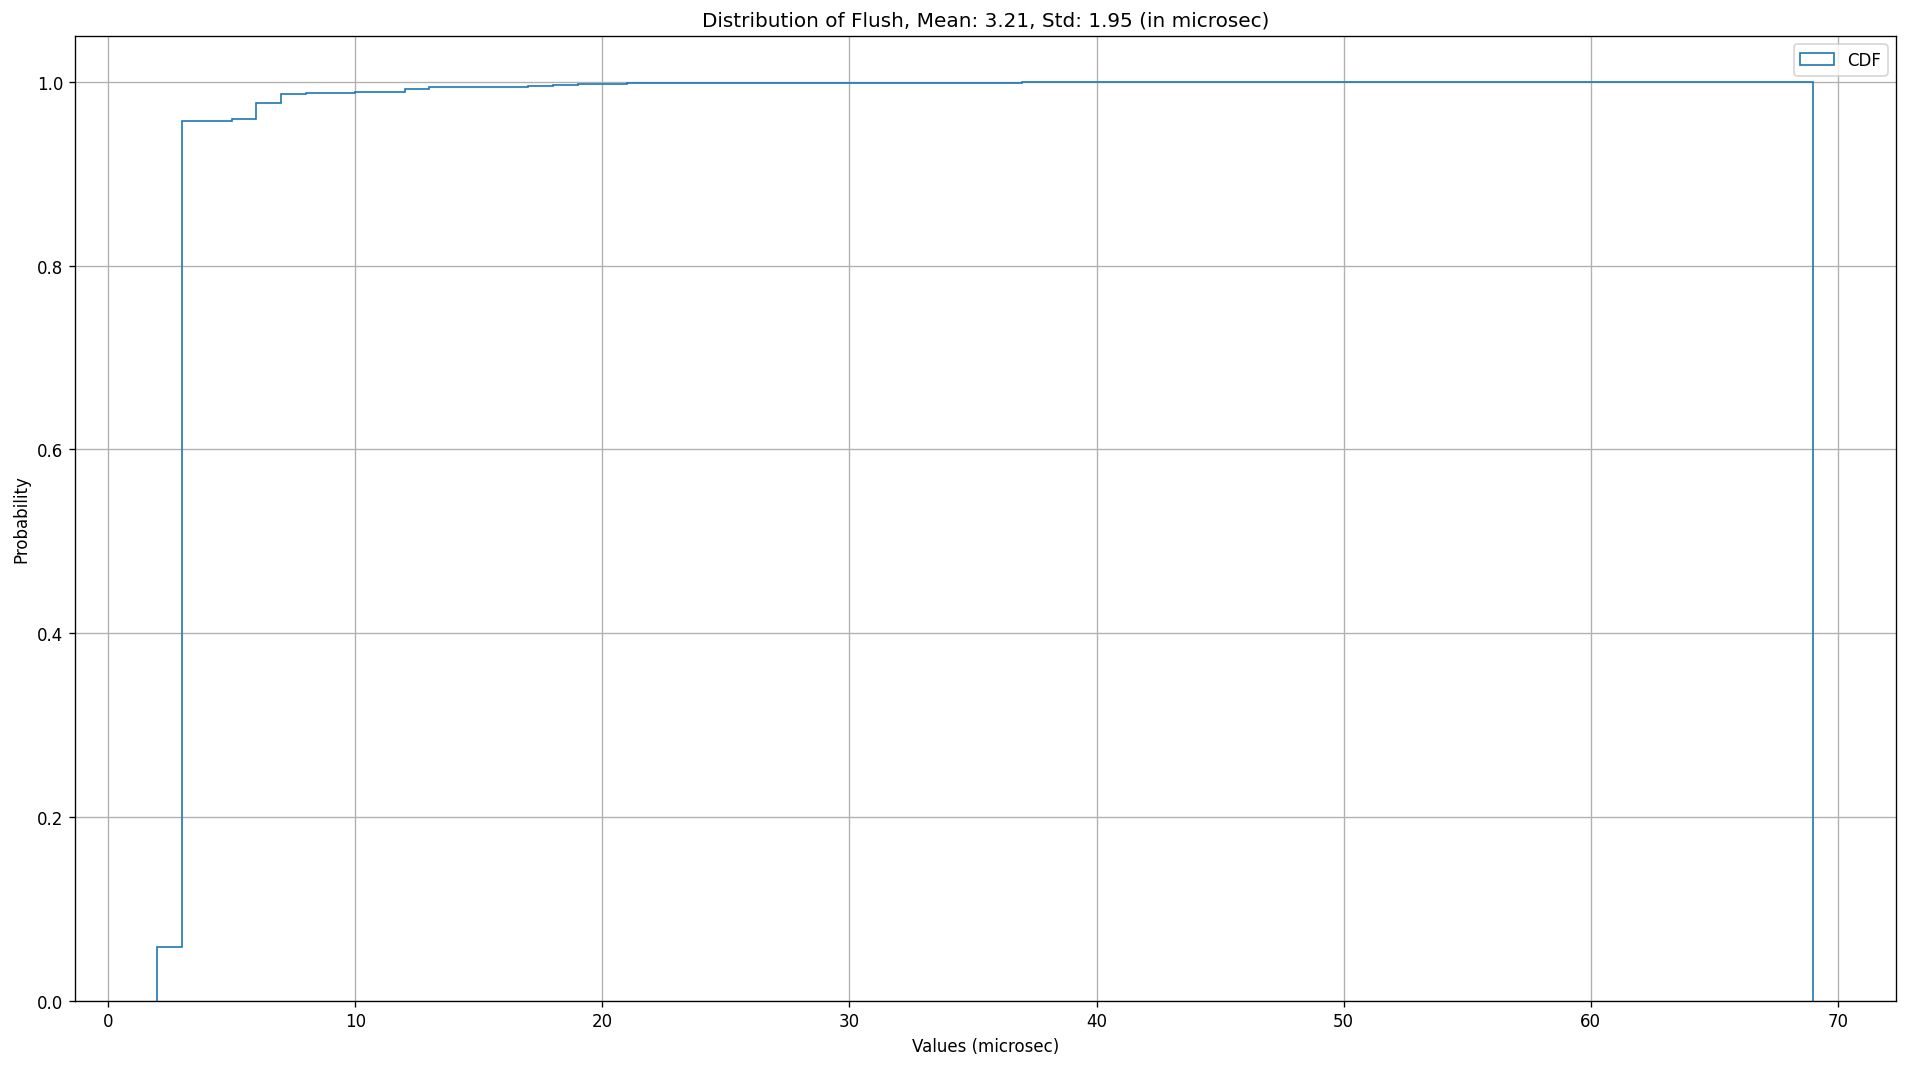

OU7 - Write Local Storage Features shape: (10000, 14)


Num of reads  Num of writes  Num of active txs  Thread pool size  \
0              100              0                  1                50   
1              100              0                  1                50   
2              100              0                  1                50   
3              100              0                  1                50   
4              100              0                  1                50   
...            ...            ...                ...               ...   
9995           100              0                  1                50   
9996           100              0                  1                50   
9997           100              0                  1                50   
9998           100              0                  1                50   
9999           100              0                  1                50   

      CPU utilization  Num of cache read  Num of cache insert  \
0                 4.0                200                    0   
1                 3.0                200                    0   
2                 3.0                200                    0   
3                 3.0                200                    0   
4                 3.0                200                    0   
...               ...                ...                  ...   
9995              2.0                200                    0   
9996              1.0                200                    0   
9997              1.0                200                    0   
9998              1.0                200                    0   
9999              1.0                200                    0   

      Num of cache update  Num of arithmetic operations  Num of write record  \
0                       0                             0                    0   
1                       0                             0                    0   
2                       0                             0                    0   
3                       0                             0                    0   
4                       0                             0                    0   
...                   ...                           ...                  ...   
9995                    0                             0                    0   
9996                    0                             0                    0   
9997                    0                             0                    0   
9998                    0                             0                    0   
9999                    0                             0                    0   

      Num of bytes  Num of read write record  Num of log flush bytes  \
0                0                       100                       0   
1                0                       100                       0   
2                0                       100                       0   
3                0                       100                       0   
4                0                       100                       0   
...            ...                       ...                     ...   
9995             0                       100                       0   
9996             0                       100                       0   
9997             0                       100                       0   
9998             0                       100                       0   
9999             0                       100                       0   

      Num of Threads  
0                 35  
1                 40  
2                 42  
3                 43  
4                 48  
...              ...  
9995              67  
9996              67  
9997              67  
9998              67  
9999              67  

[10000 rows x 14 columns]

OU7 - Write Local Storage Targets shape: (10000,)


0       19497
1       17382
2       17895
3       18281
4       17925
        ...  
9995     2613
9996     2622
9997     2765
9998     2804
9999     2902
Name: Flush, Length: 10000, dtype: int64

In [78]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes',
                'Num of Threads'
                ]
targetName = 'Flush'

# Create path for OU
figPathOU = makePath(figPath, targetName)
modelPathOU = makePath(modelPath, targetName)

wLocalStorageFeatures, wLocalStorageTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, figPath=figPathOU, 
                                                          warmupDrop=warmupDrop, outlinerDrop=outlinerDropR, sample=sampleN, histUnit=histUnit, isSaveFig=isSaveFig, isSC=isSC)
print(f'OU7 - Write Local Storage Features shape: {wLocalStorageFeatures.shape}')
display(wLocalStorageFeatures)
print(f'OU7 - Write Local Storage Targets shape: {wLocalStorageTargets.shape}')
display(wLocalStorageTargets)

X_train, X_test, y_train, y_test = train_test_split(wLocalStorageFeatures, wLocalStorageTargets, test_size=testSize, random_state=randomState)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1167/0.116
Best Params: {'alpha': 1.0, 'gamma': 2.0, 'kernel': 'rbf'}


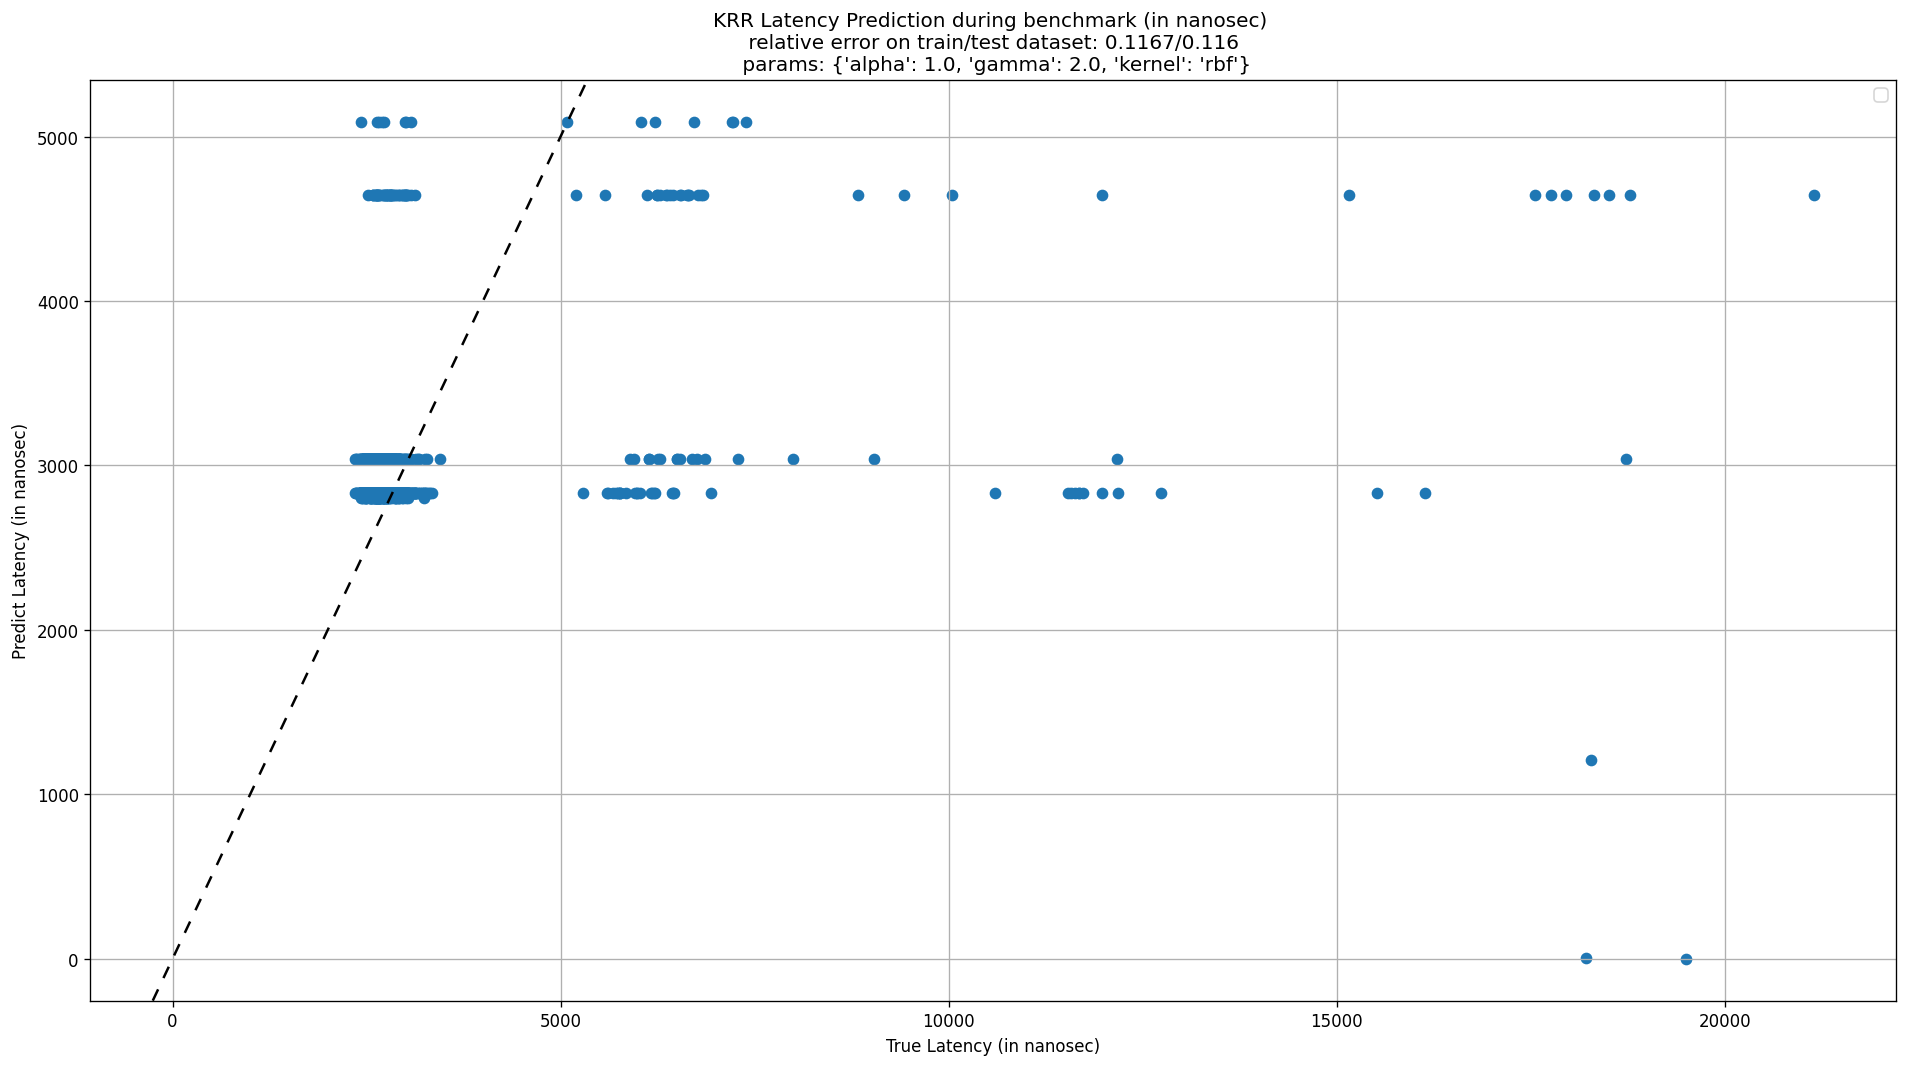

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.0653833  -0.0653685
 -0.06537281 -0.06538139 -0.06536382 -0.06536392 -0.06537329 -0.06537836
 -0.065361   -0.06536164 -0.06537283 -0.06537954 -0.06535989 -0.06536708
 -0.06536716 -0.06536408]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.0654/0.0694
Best Params: {'C': 4.0, 'gamma': 0.1, 'kernel': 'rbf'}


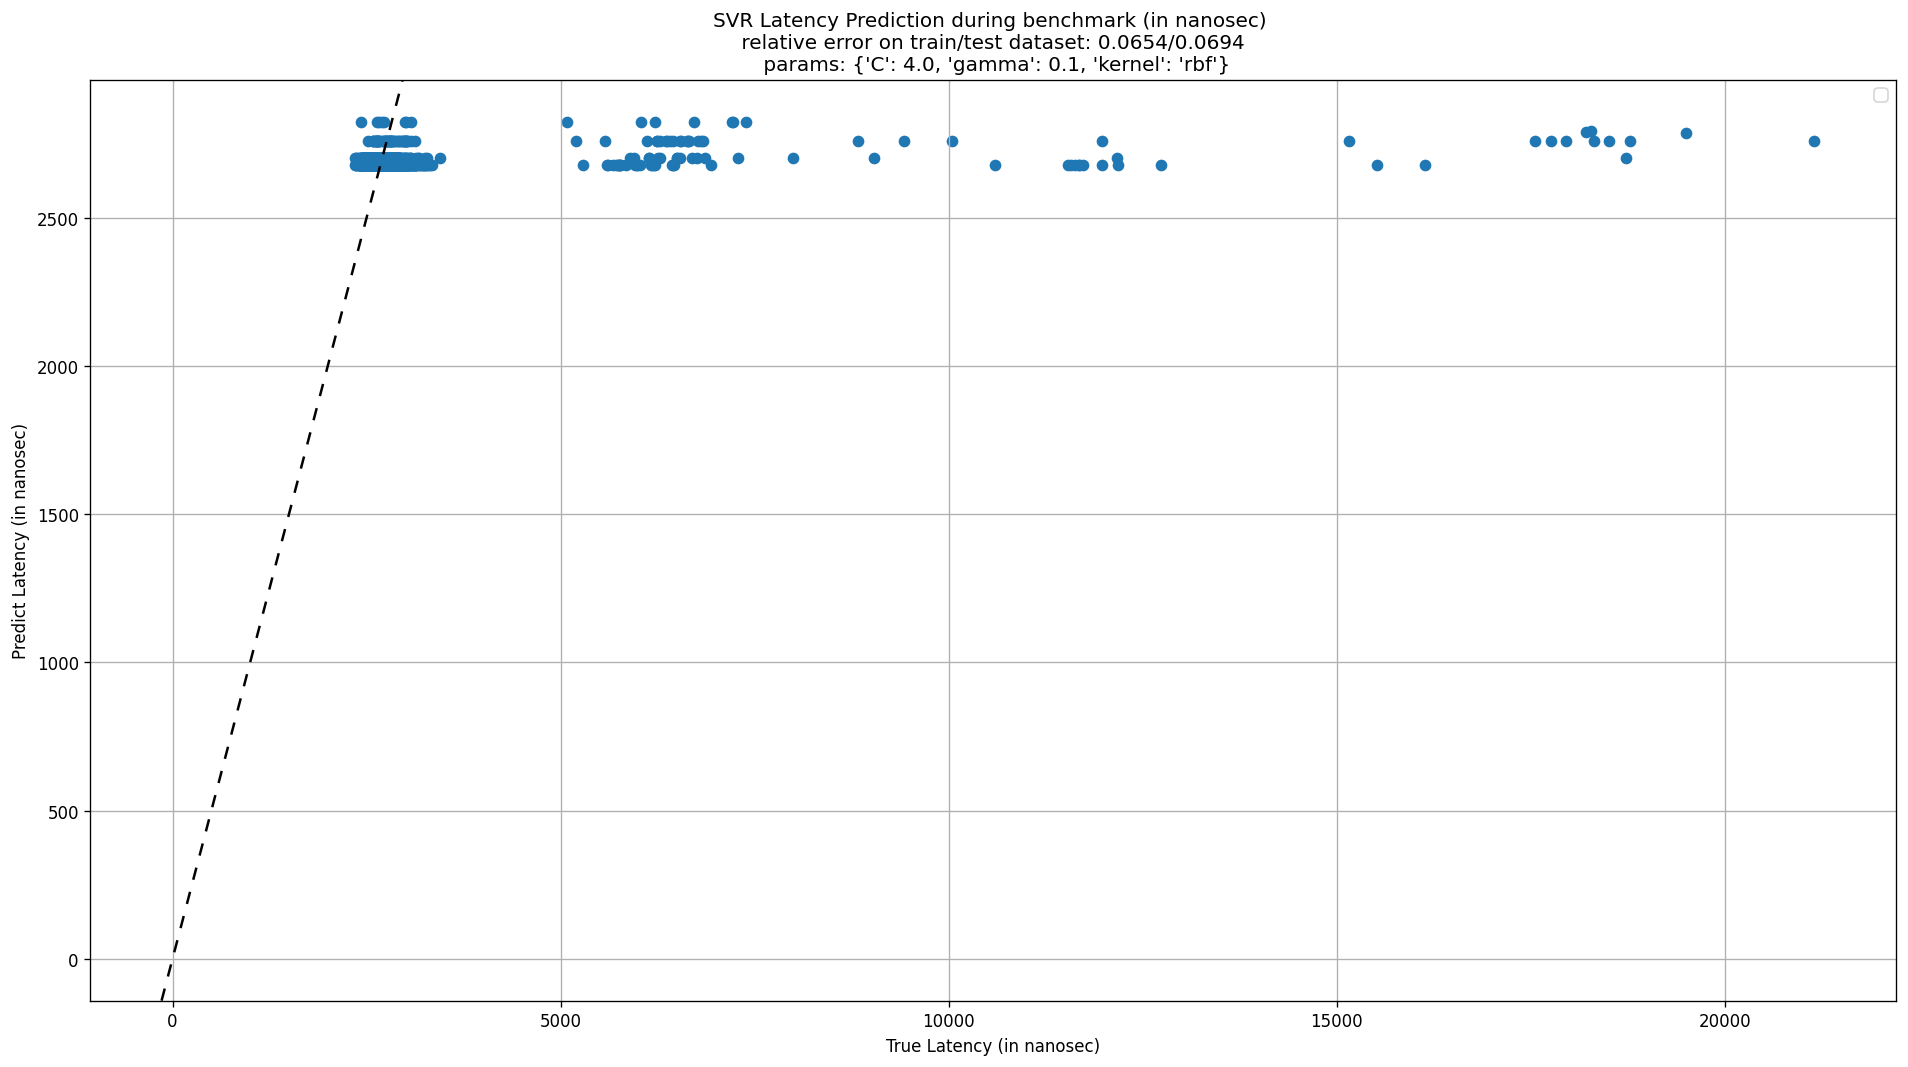

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.0651/0.0689
Best Params: {'alpha': 0.0001, 'epsilon': 1.1}


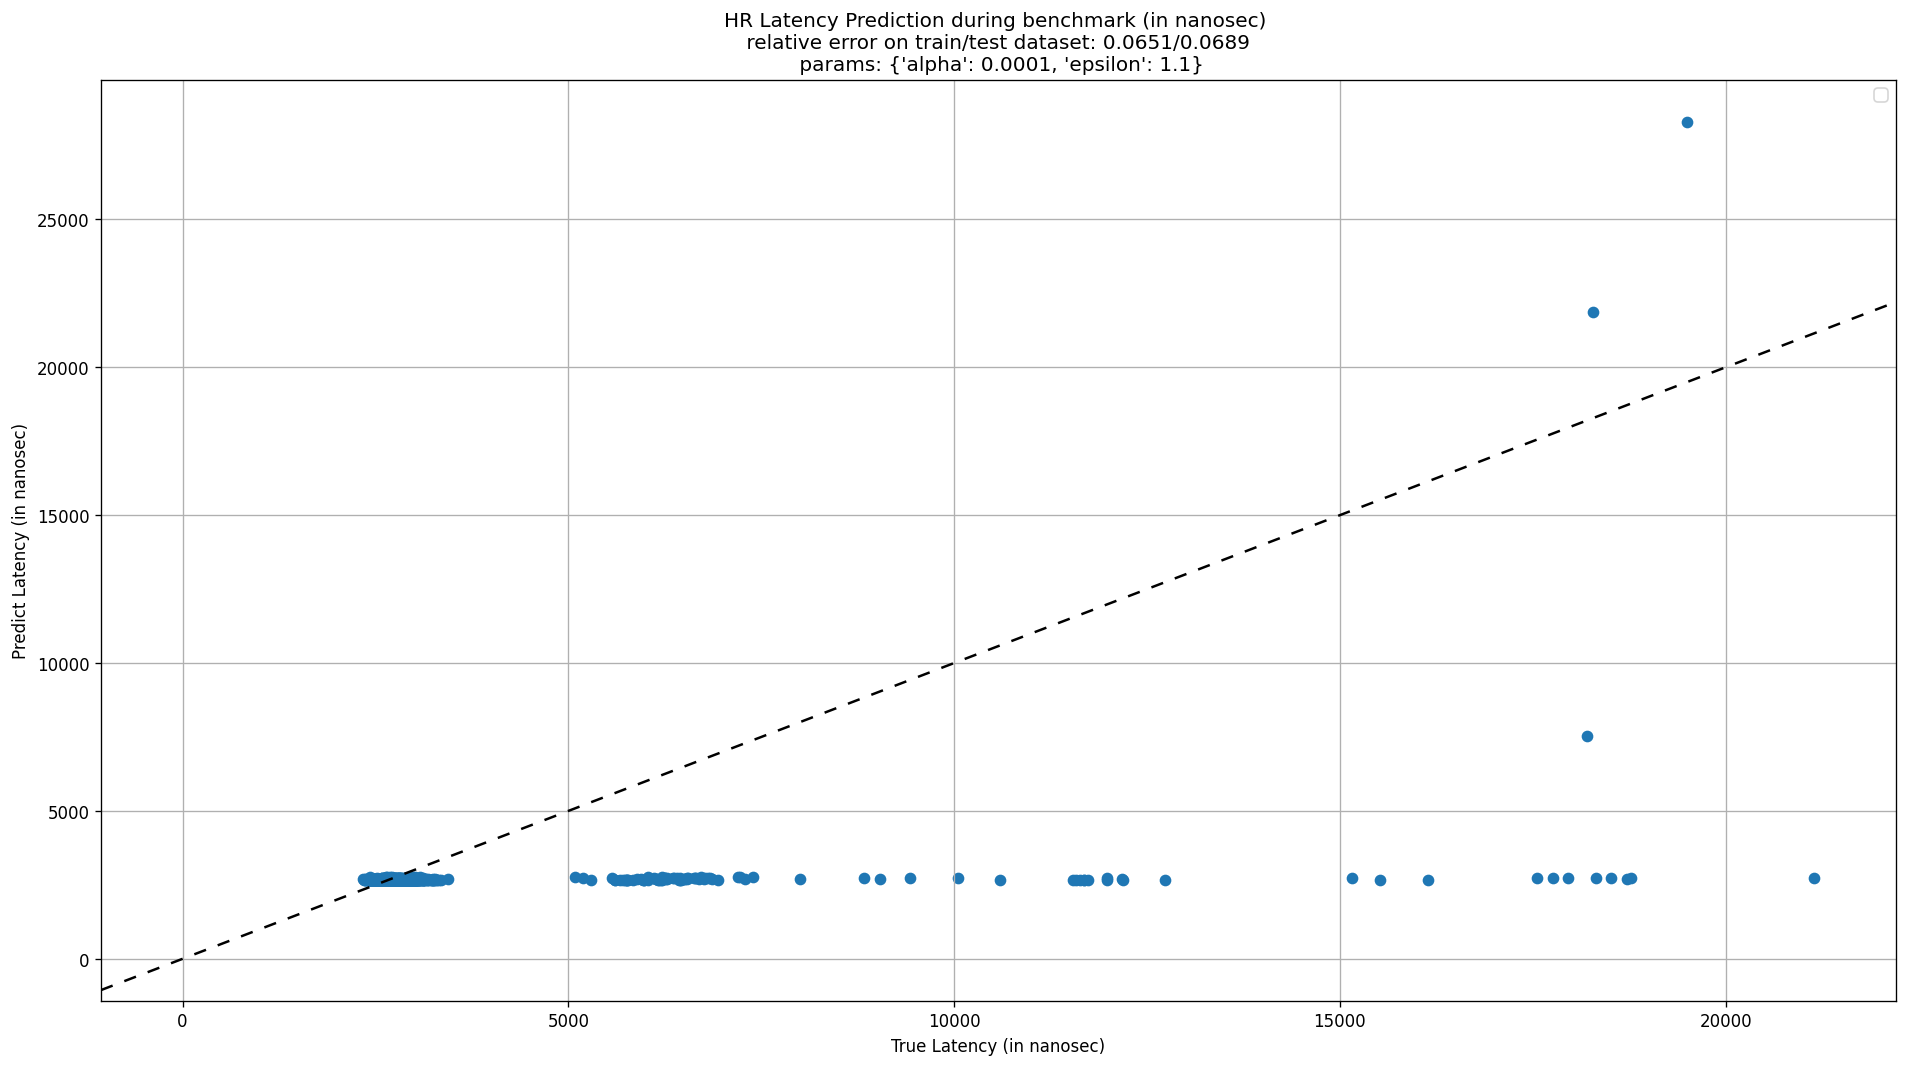

Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Best training/testing score: 0.0661/0.0694
Best Params: {'criterion': 'mae', 'max_depth': 3, 'n_estimators': 50, 'n_jobs': None, 'random_state': 0}


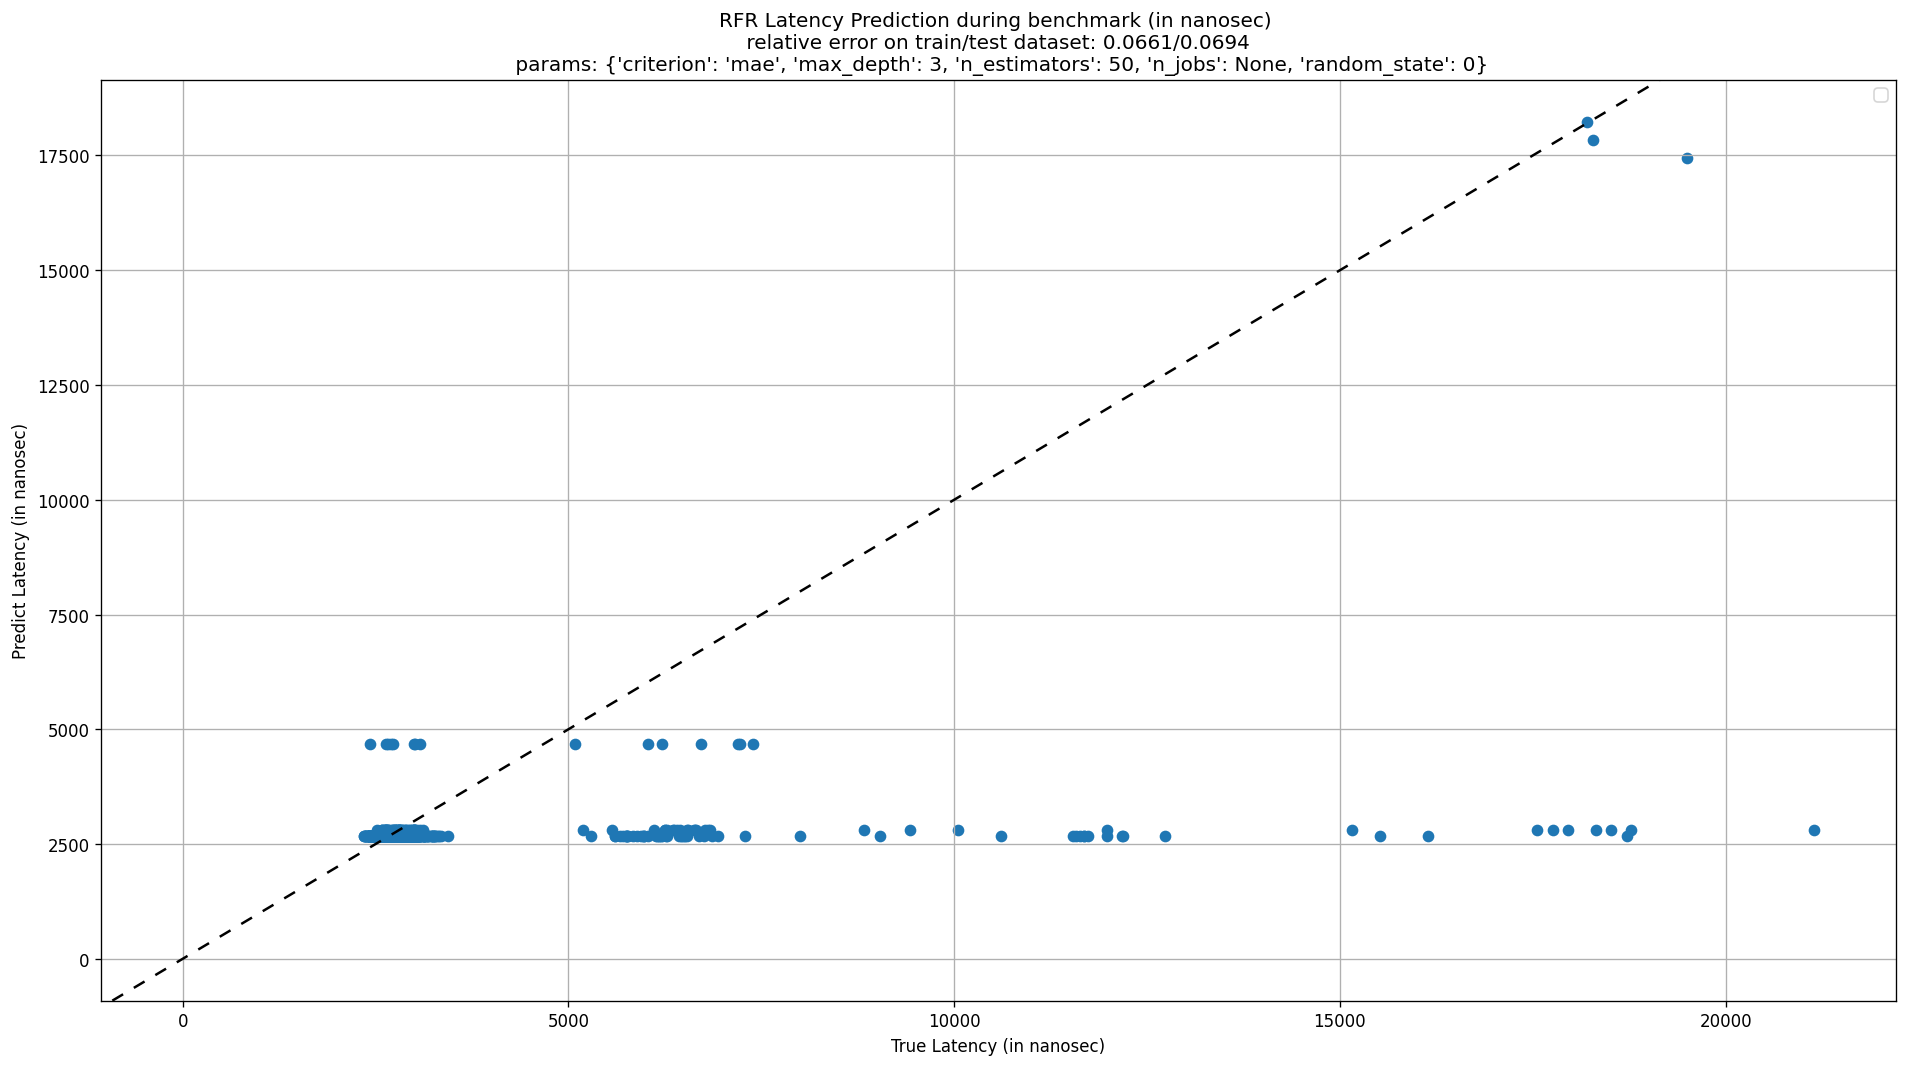

[(GridSearchCV(estimator=KernelRidge(), n_jobs=-1,
               param_grid={'alpha': [1.0], 'gamma': [0.1, 0.5, 1.0, 2.0],
                           'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.1167,
  0.116),
 (GridSearchCV(estimator=SVR(), n_jobs=-1,
               param_grid={'C': [0, 0.5, 1.0, 2.0, 4.0],
                           'gamma': [0.1, 0.5, 1.0, 2.0], 'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.0654,
  0.0694),
 (GridSearchCV(estimator=HuberRegressor(), n_jobs=-1,
               param_grid={'alpha': [0, 0.0001, 0.01, 0.1, 1],
                           'epsilon': [1.1, 1.35, 2, 5]},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.0651,
  0.0689),
 (GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
               param_grid={'criterion': ['mse', 'mae'],
                           'max_depth': [3, 5, 7, 10],
                      

In [79]:
Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                        figPath=figPathOU, modelPath=modelPathOU, isSaveFig=isSaveFig, isSaveModel=isSaveModel, n_jobs=-1) for m in modelList)

# Execute Txn Logic

Warm Up Drop Timestamp: 412862681
In microsec, Number of bins: 11, nBins: [14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24.]
Mean Latency: 17.86, Std Latency: 1.86 (microsec)


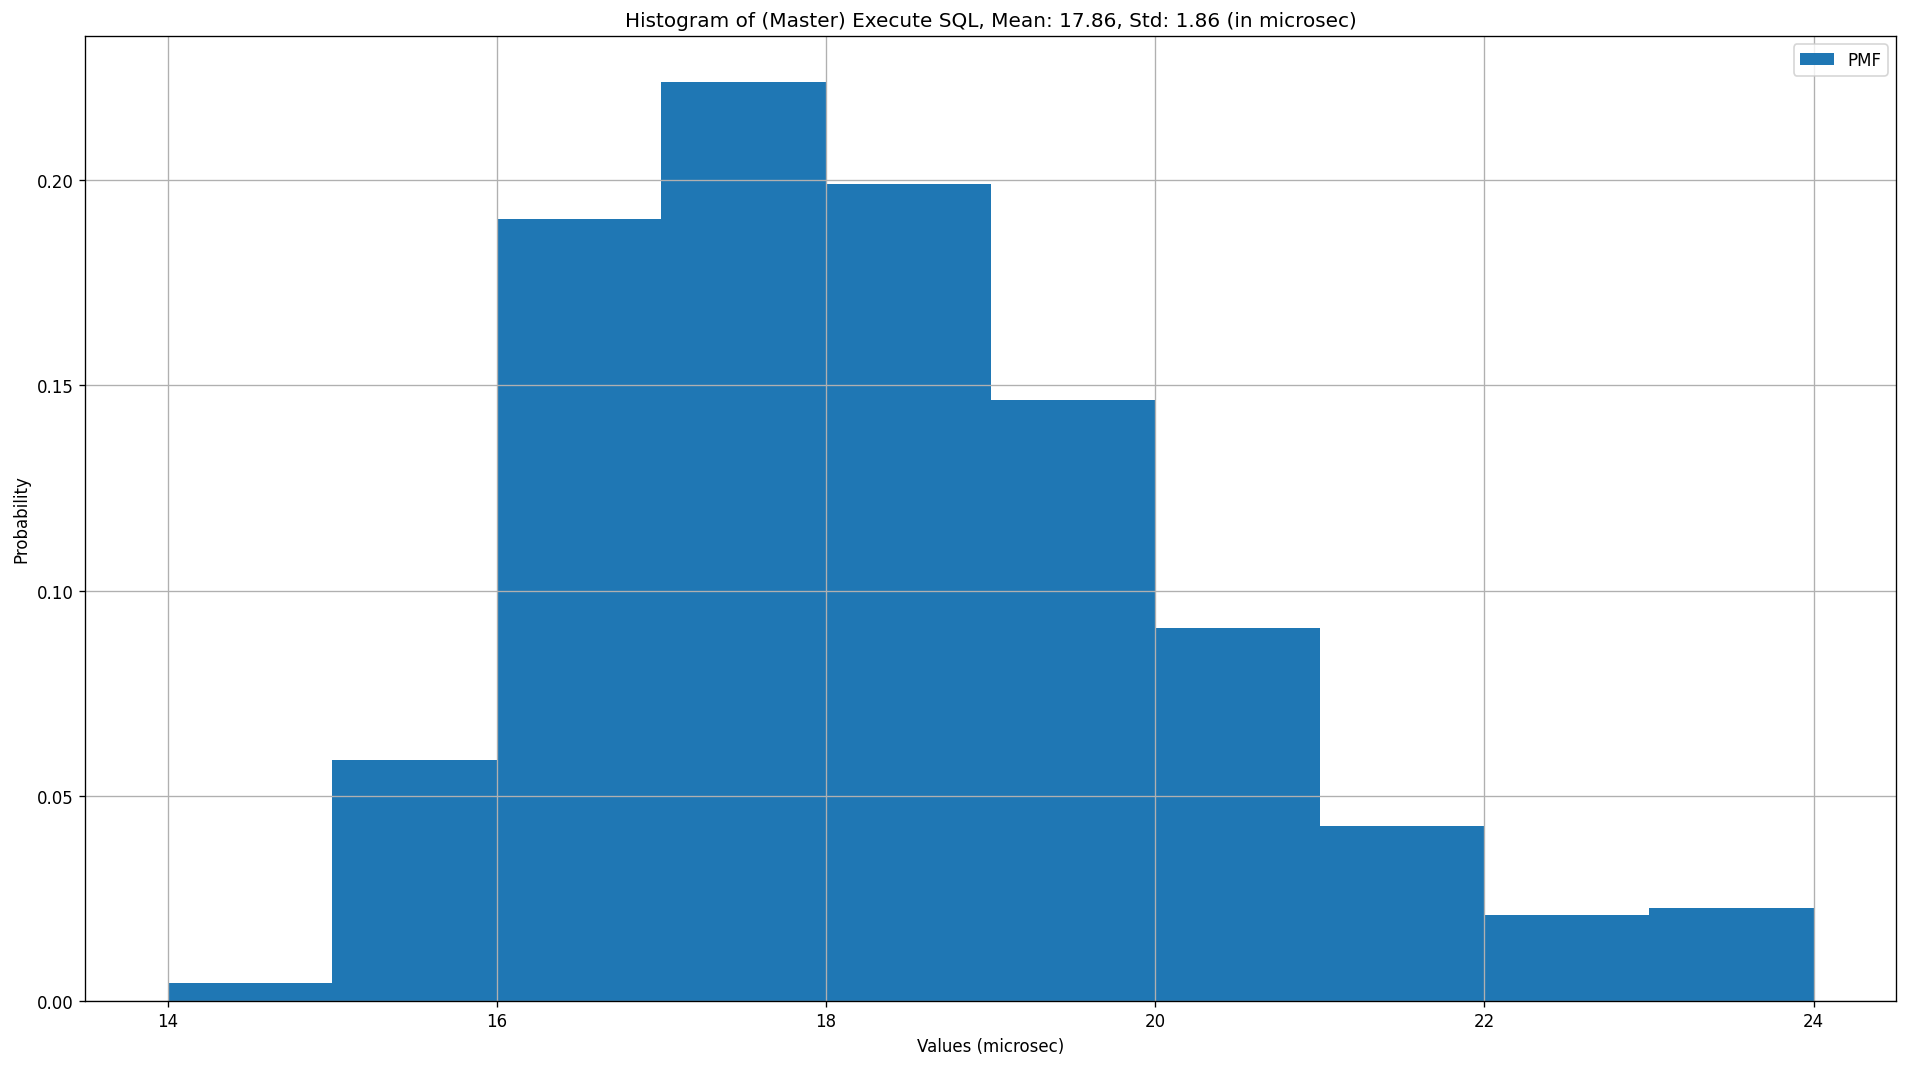

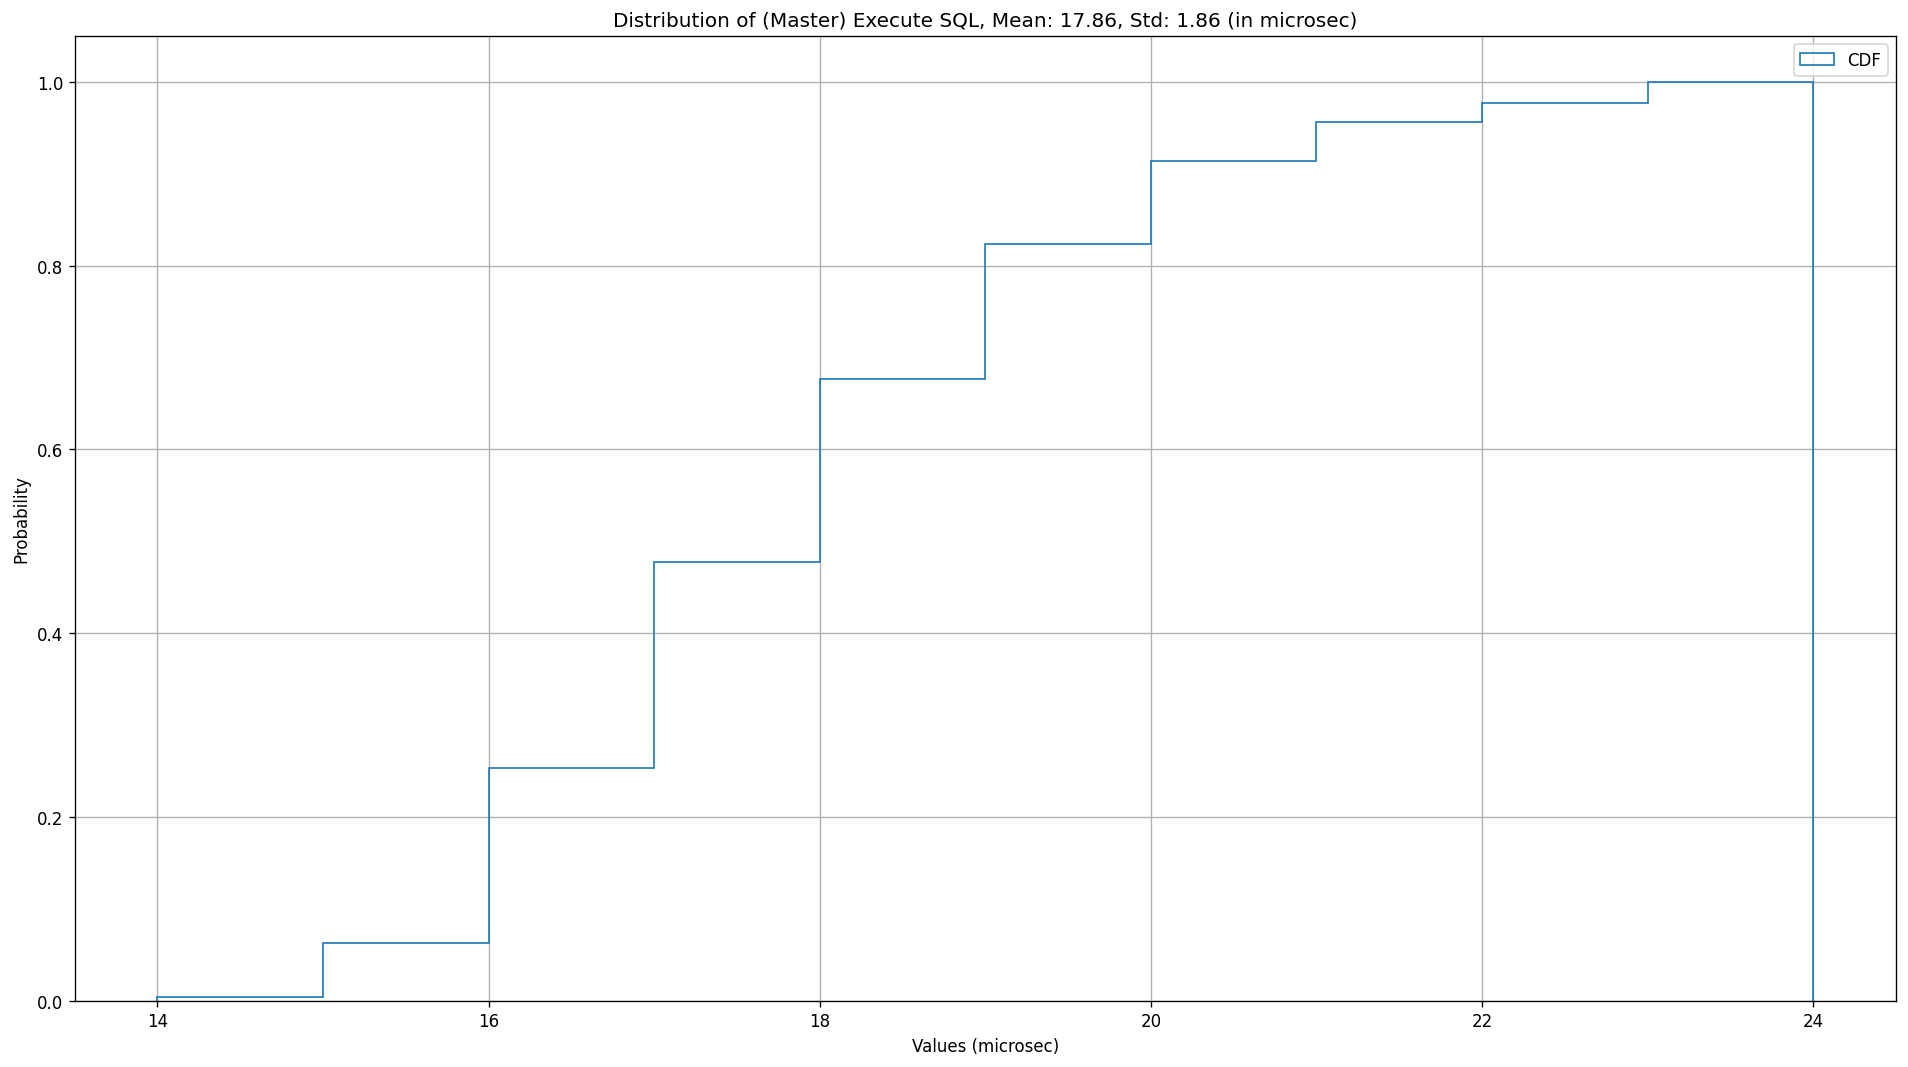

OU6 - Eexecute SQL Features shape: (10000, 14)


Num of reads  Num of writes  Num of active txs  Thread pool size  \
0              100              0                  1                50   
1              100              0                  1                50   
2              100              0                  1                50   
3              100              0                  1                50   
4              100              0                  1                50   
...            ...            ...                ...               ...   
9995           100              0                  1                50   
9996           100              0                  1                50   
9997           100              0                  1                50   
9998           100              0                  1                50   
9999           100              0                  1                50   

      CPU utilization  Num of cache read  Num of cache insert  \
0                 2.0                200                    0   
1                 1.0                200                    0   
2                 3.0                200                    0   
3                 1.0                200                    0   
4                 2.0                200                    0   
...               ...                ...                  ...   
9995              1.0                200                    0   
9996              1.0                200                    0   
9997              1.0                200                    0   
9998              2.0                200                    0   
9999              1.0                200                    0   

      Num of cache update  Num of arithmetic operations  Num of write record  \
0                       0                             0                    0   
1                       0                             0                    0   
2                       0                             0                    0   
3                       0                             0                    0   
4                       0                             0                    0   
...                   ...                           ...                  ...   
9995                    0                             0                    0   
9996                    0                             0                    0   
9997                    0                             0                    0   
9998                    0                             0                    0   
9999                    0                             0                    0   

      Num of bytes  Num of read write record  Num of log flush bytes  \
0                0                       100                       0   
1                0                       100                       0   
2                0                       100                       0   
3                0                       100                       0   
4                0                       100                       0   
...            ...                       ...                     ...   
9995             0                       100                       0   
9996             0                       100                       0   
9997             0                       100                       0   
9998             0                       100                       0   
9999             0                       100                       0   

      Num of Threads  
0                 67  
1                 67  
2                 67  
3                 67  
4                 67  
...              ...  
9995              67  
9996              67  
9997              67  
9998              67  
9999              67  

[10000 rows x 14 columns]

OU6 - Eexecute SQL Targets shape: (10000,)


0       24400
1       24030
2       22541
3       19698
4       17664
        ...  
9995    17654
9996    15775
9997    16142
9998    16056
9999    17626
Name: (Master) Execute SQL, Length: 10000, dtype: int64

In [80]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes',
                'Num of Threads'
                ]
targetName = '(Master) Execute SQL'

# Create path for OU
figPathOU = makePath(figPath, targetName)
modelPathOU = makePath(modelPath, targetName)

exeSqlFeatures, exeSqlTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
                                            warmupDrop=warmupDrop, outlinerDrop=outlinerDropR, sample=sampleN, histUnit=histUnit, isSaveFig=isSaveFig, isSC=isSC)
print(f'OU6 - Eexecute SQL Features shape: {exeSqlFeatures.shape}')
display(exeSqlFeatures)
print(f'OU6 - Eexecute SQL Targets shape: {exeSqlTargets.shape}')
display(exeSqlTargets)

X_train, X_test, y_train, y_test = train_test_split(exeSqlFeatures, exeSqlTargets, test_size=testSize, random_state=randomState)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.0803/0.0804
Best Params: {'alpha': 1.0, 'gamma': 2.0, 'kernel': 'rbf'}


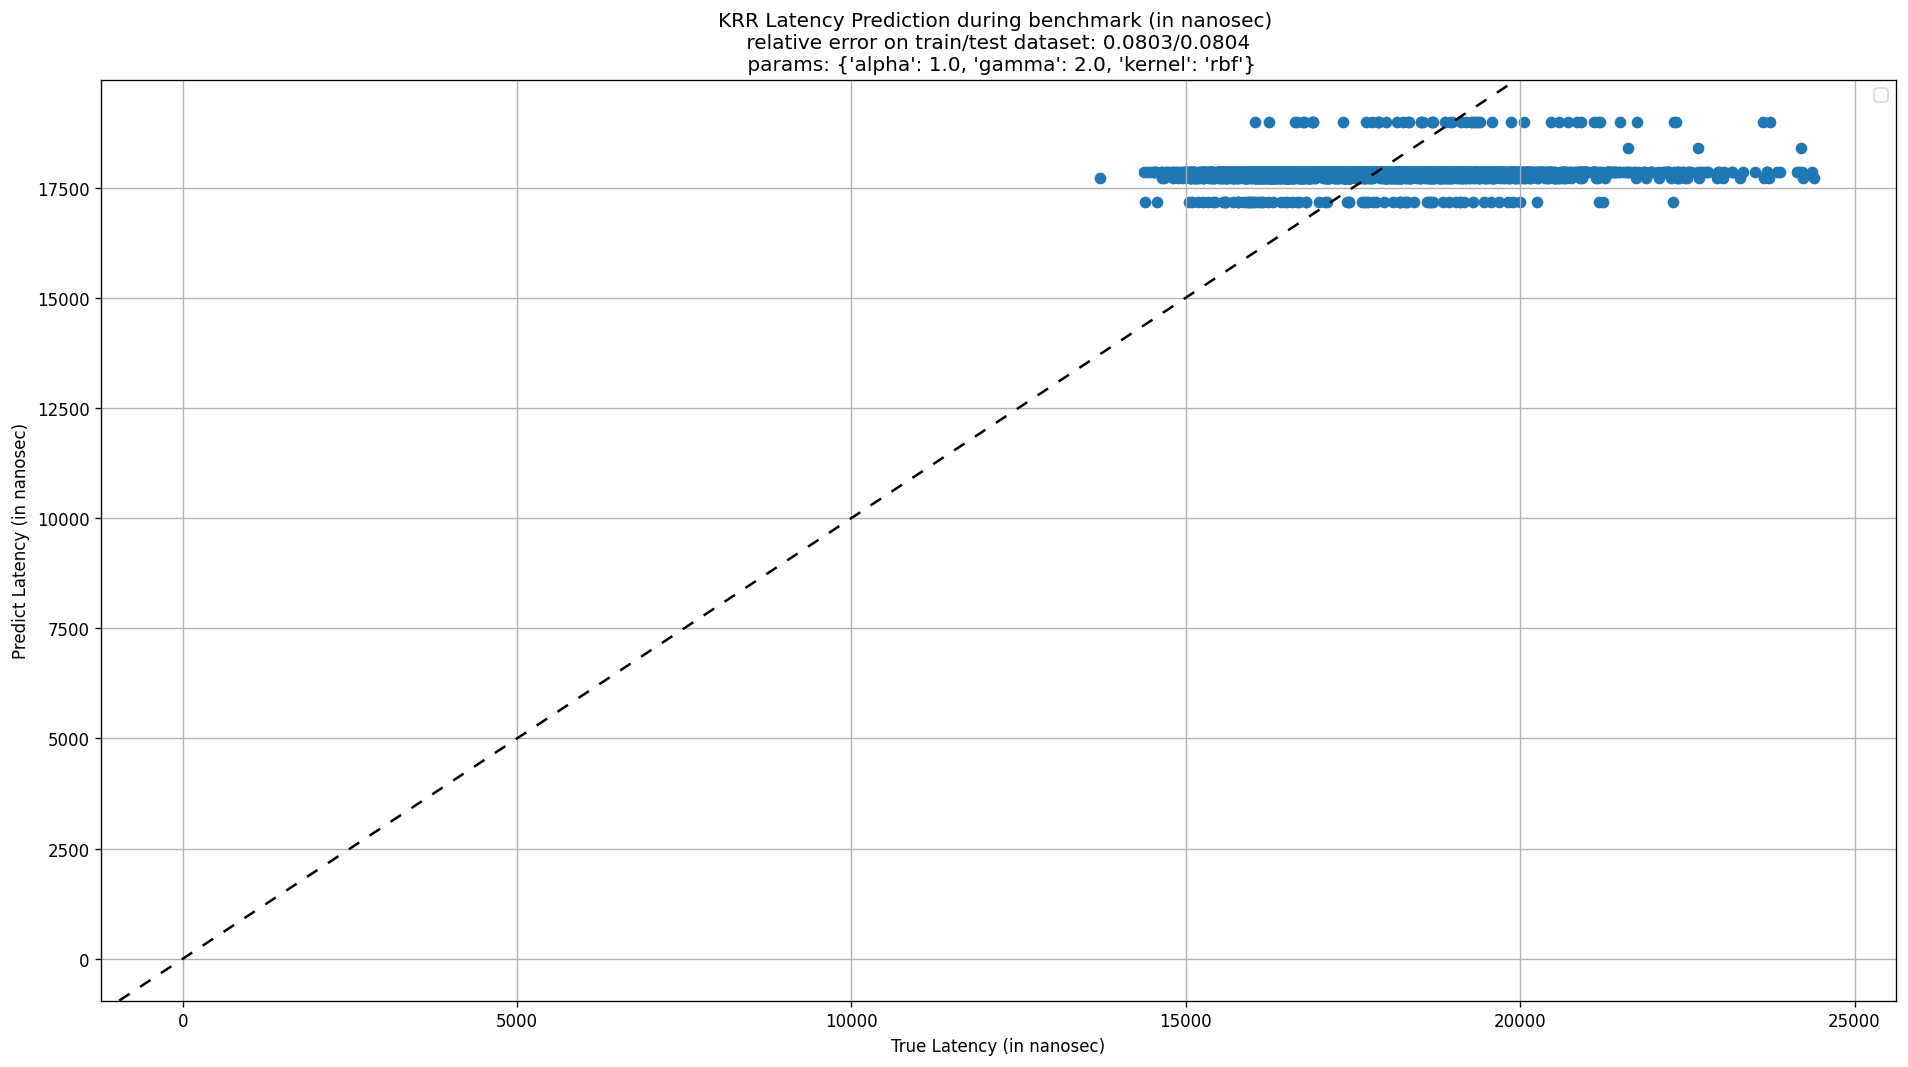

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.07912444 -0.0791081
 -0.07907912 -0.07904954 -0.07912482 -0.07908591 -0.07903789 -0.0790009
 -0.07911584 -0.07905209 -0.07897758 -0.07892508 -0.07911046 -0.07898821
 -0.07885912 -0.07879337]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.0788/0.0792
Best Params: {'C': 4.0, 'gamma': 2.0, 'kernel': 'rbf'}


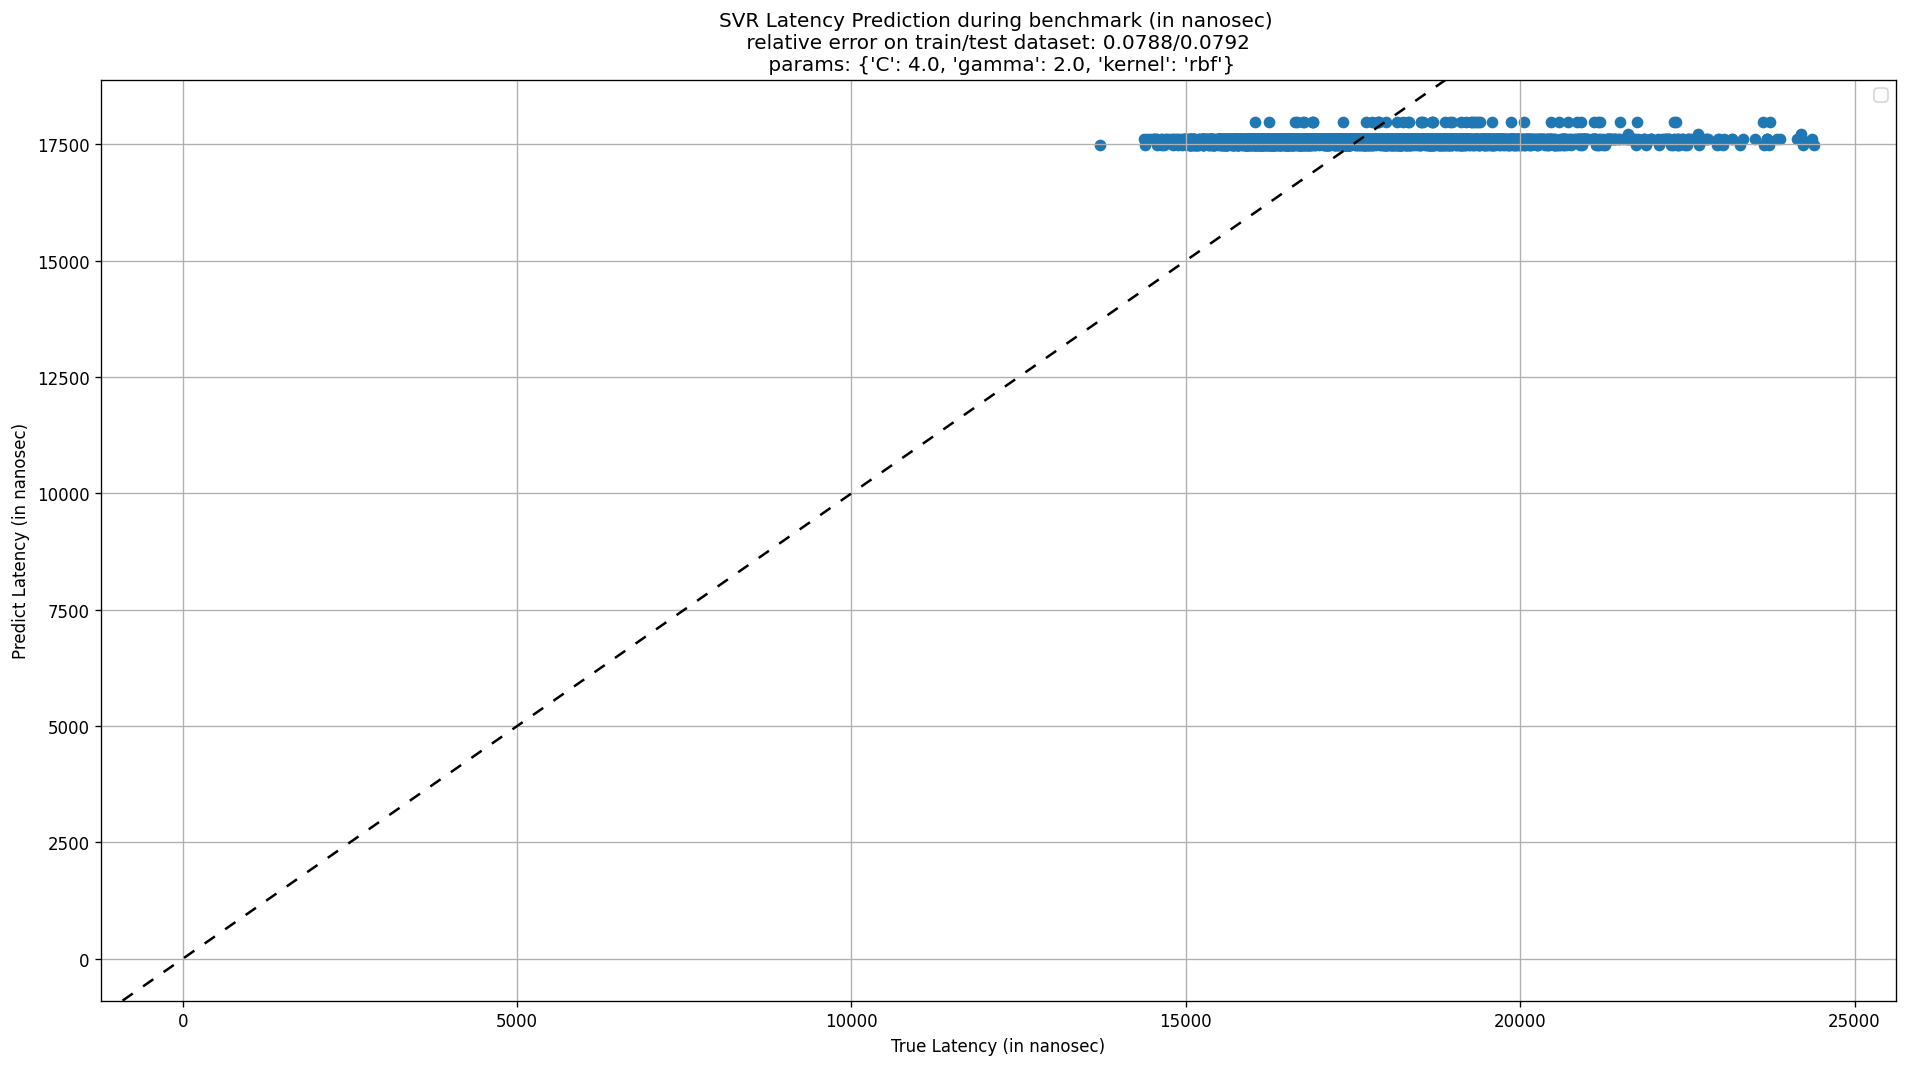

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.0791/0.0796
Best Params: {'alpha': 0.1, 'epsilon': 1.1}


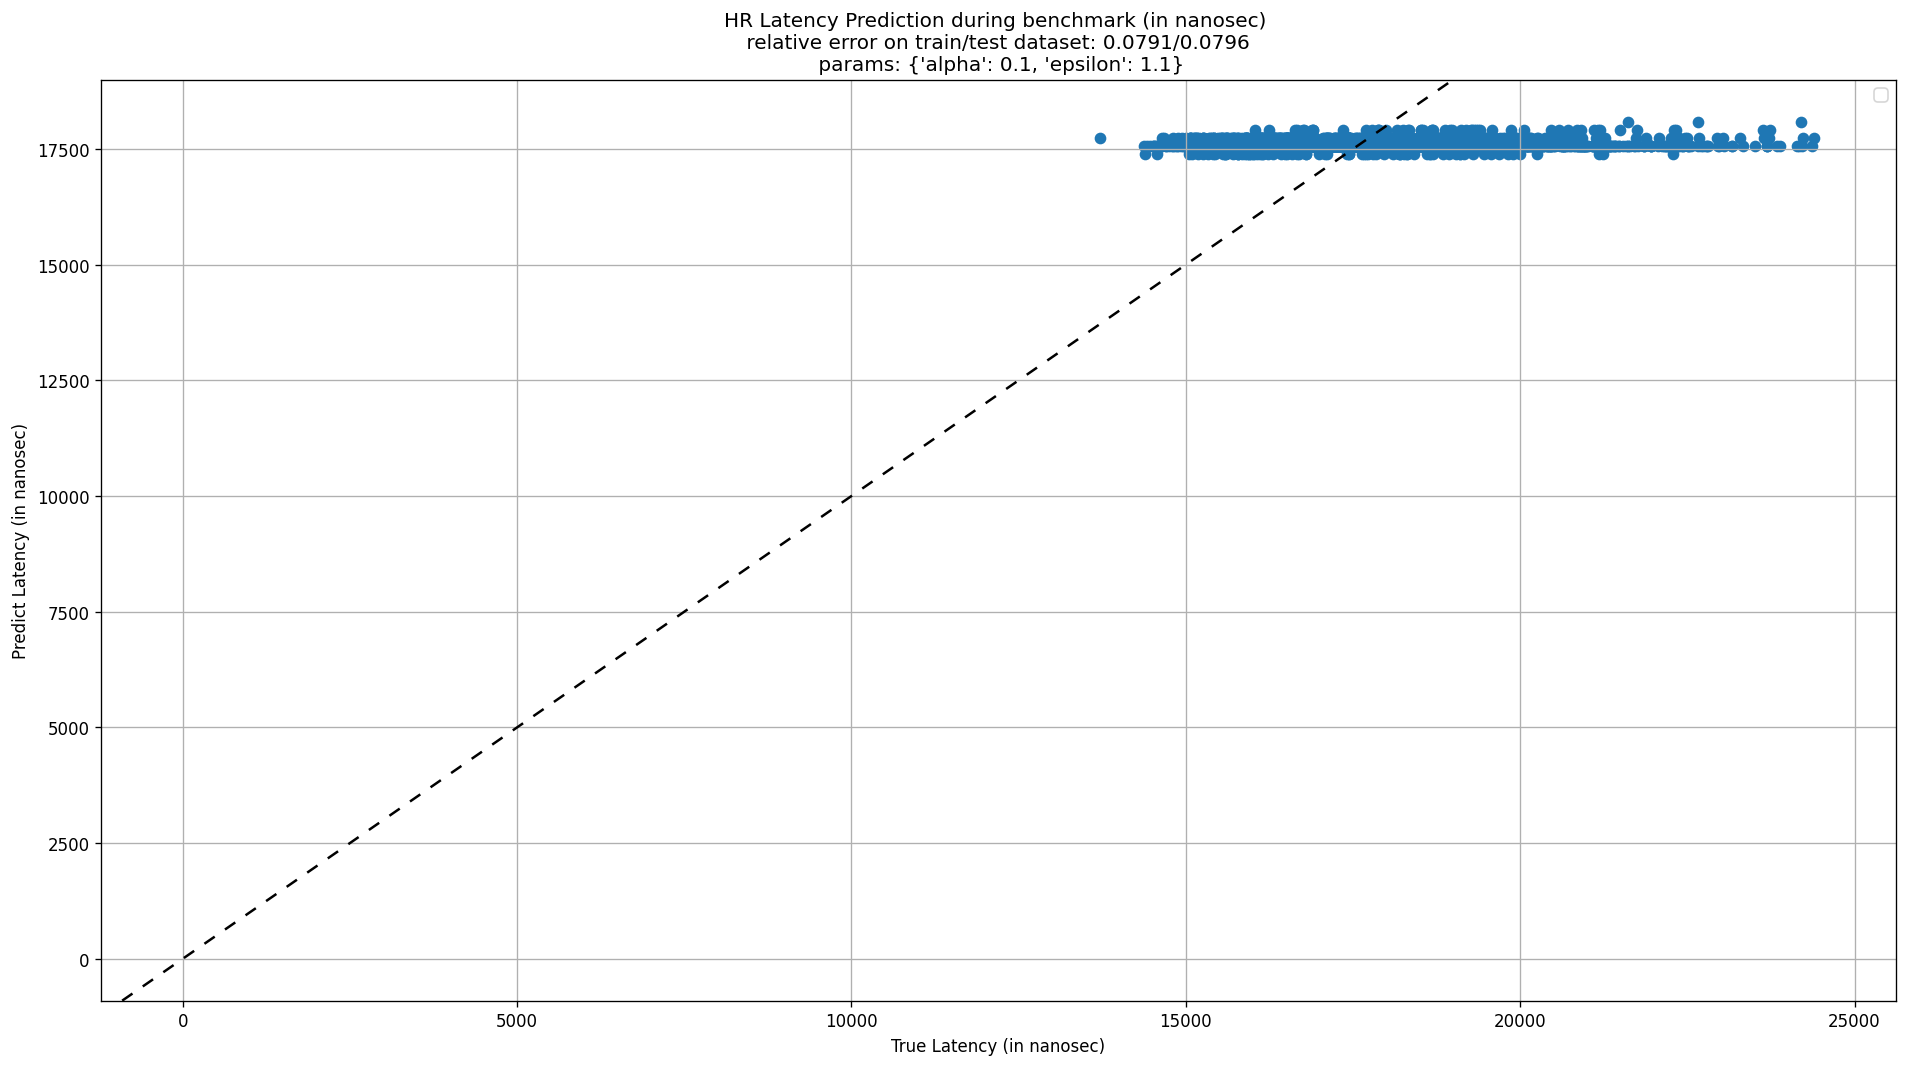

Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Best training/testing score: 0.0785/0.0787
Best Params: {'criterion': 'mae', 'max_depth': 3, 'n_estimators': 100, 'n_jobs': None, 'random_state': 0}


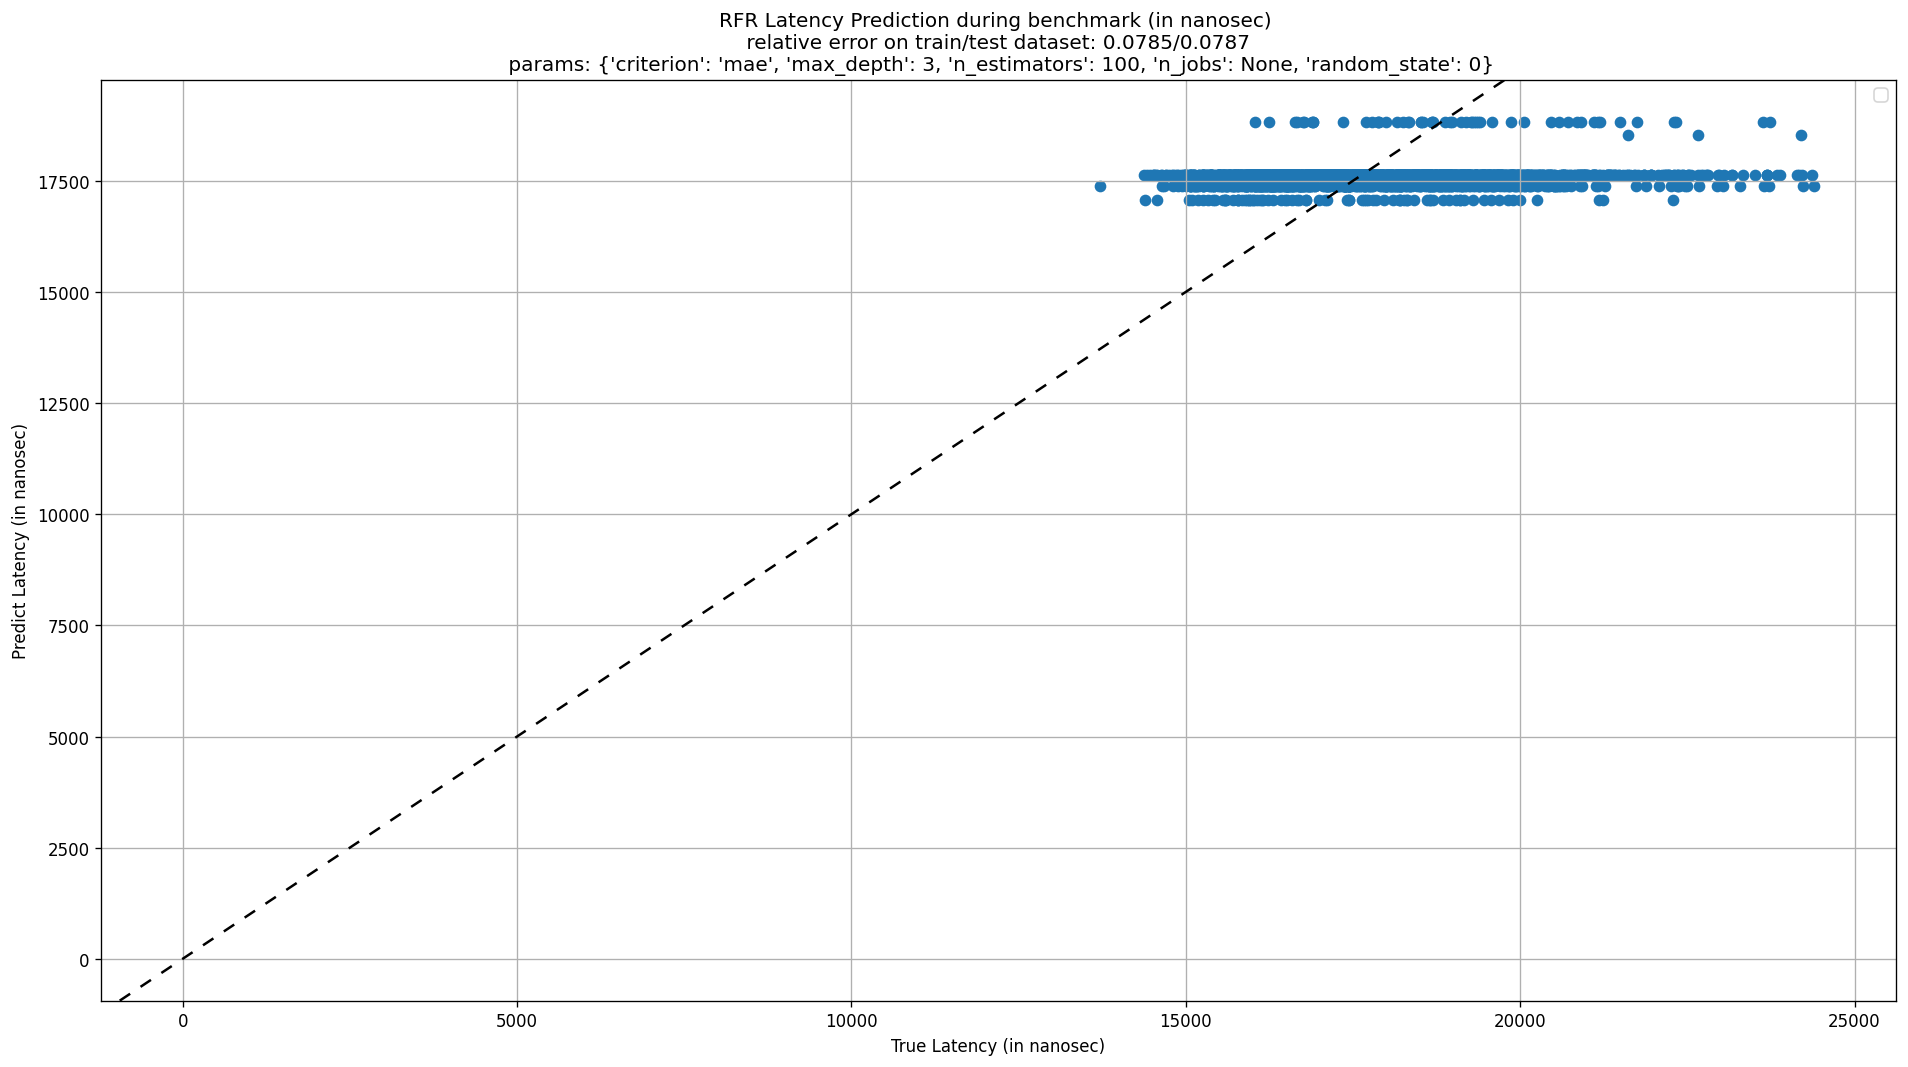

[(GridSearchCV(estimator=KernelRidge(), n_jobs=-1,
               param_grid={'alpha': [1.0], 'gamma': [0.1, 0.5, 1.0, 2.0],
                           'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.0803,
  0.0804),
 (GridSearchCV(estimator=SVR(), n_jobs=-1,
               param_grid={'C': [0, 0.5, 1.0, 2.0, 4.0],
                           'gamma': [0.1, 0.5, 1.0, 2.0], 'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.0788,
  0.0792),
 (GridSearchCV(estimator=HuberRegressor(), n_jobs=-1,
               param_grid={'alpha': [0, 0.0001, 0.01, 0.1, 1],
                           'epsilon': [1.1, 1.35, 2, 5]},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.0791,
  0.0796),
 (GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
               param_grid={'criterion': ['mse', 'mae'],
                           'max_depth': [3, 5, 7, 10],
                     

In [81]:
Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                        figPath=figPathOU, modelPath=modelPathOU, isSaveFig=isSaveFig, isSaveModel=isSaveModel, n_jobs=-1) for m in modelList)

# Generating Execution Plan

Warm Up Drop Timestamp: 412862681
In microsec, Number of bins: 951, nBins: [ 791.  792.  793.  794.  795.  796.  797.  798.  799.  800.  801.  802.
  803.  804.  805.  806.  807.  808.  809.  810.  811.  812.  813.  814.
  815.  816.  817.  818.  819.  820.  821.  822.  823.  824.  825.  826.
  827.  828.  829.  830.  831.  832.  833.  834.  835.  836.  837.  838.
  839.  840.  841.  842.  843.  844.  845.  846.  847.  848.  849.  850.
  851.  852.  853.  854.  855.  856.  857.  858.  859.  860.  861.  862.
  863.  864.  865.  866.  867.  868.  869.  870.  871.  872.  873.  874.
  875.  876.  877.  878.  879.  880.  881.  882.  883.  884.  885.  886.
  887.  888.  889.  890.  891.  892.  893.  894.  895.  896.  897.  898.
  899.  900.  901.  902.  903.  904.  905.  906.  907.  908.  909.  910.
  911.  912.  913.  914.  915.  916.  917.  918.  919.  920.  921.  922.
  923.  924.  925.  926.  927.  928.  929.  930.  931.  932.  933.  934.
  935.  936.  937.  938.  939.  940.  941.  942. 

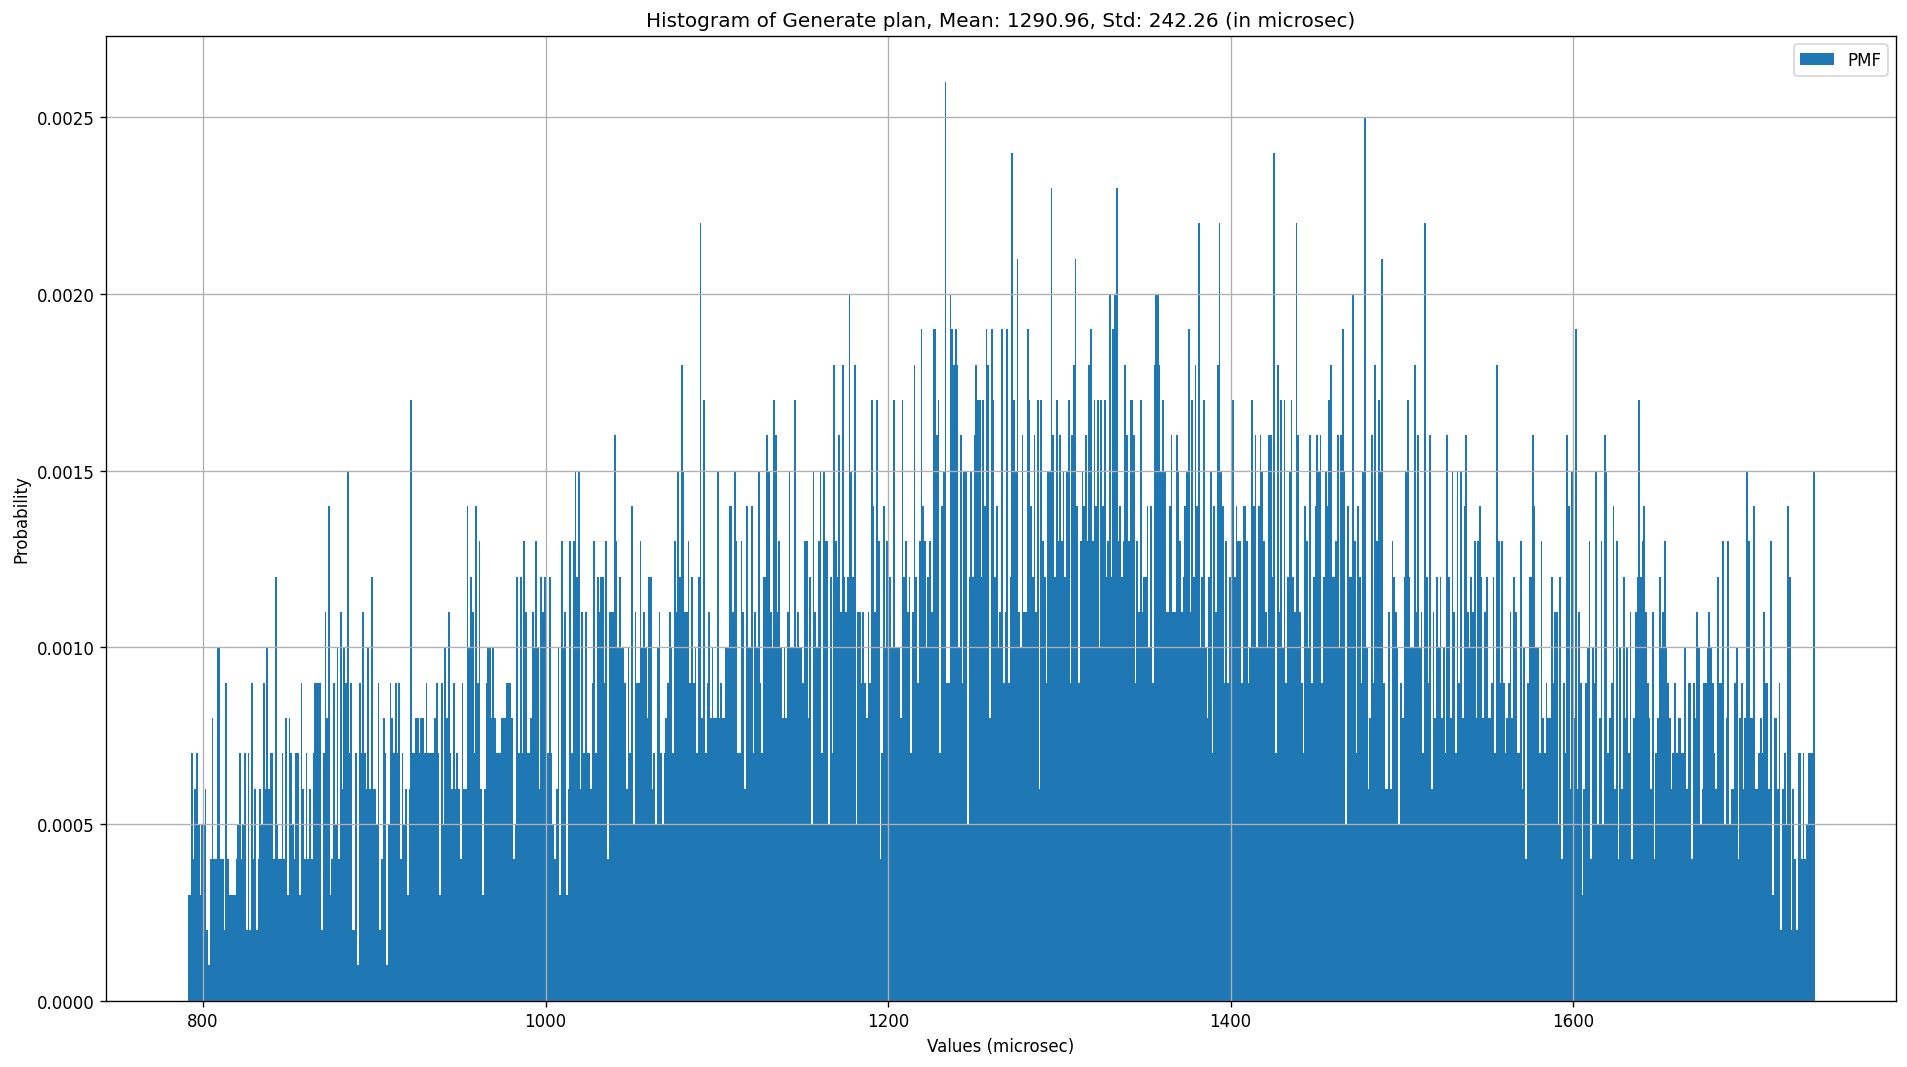

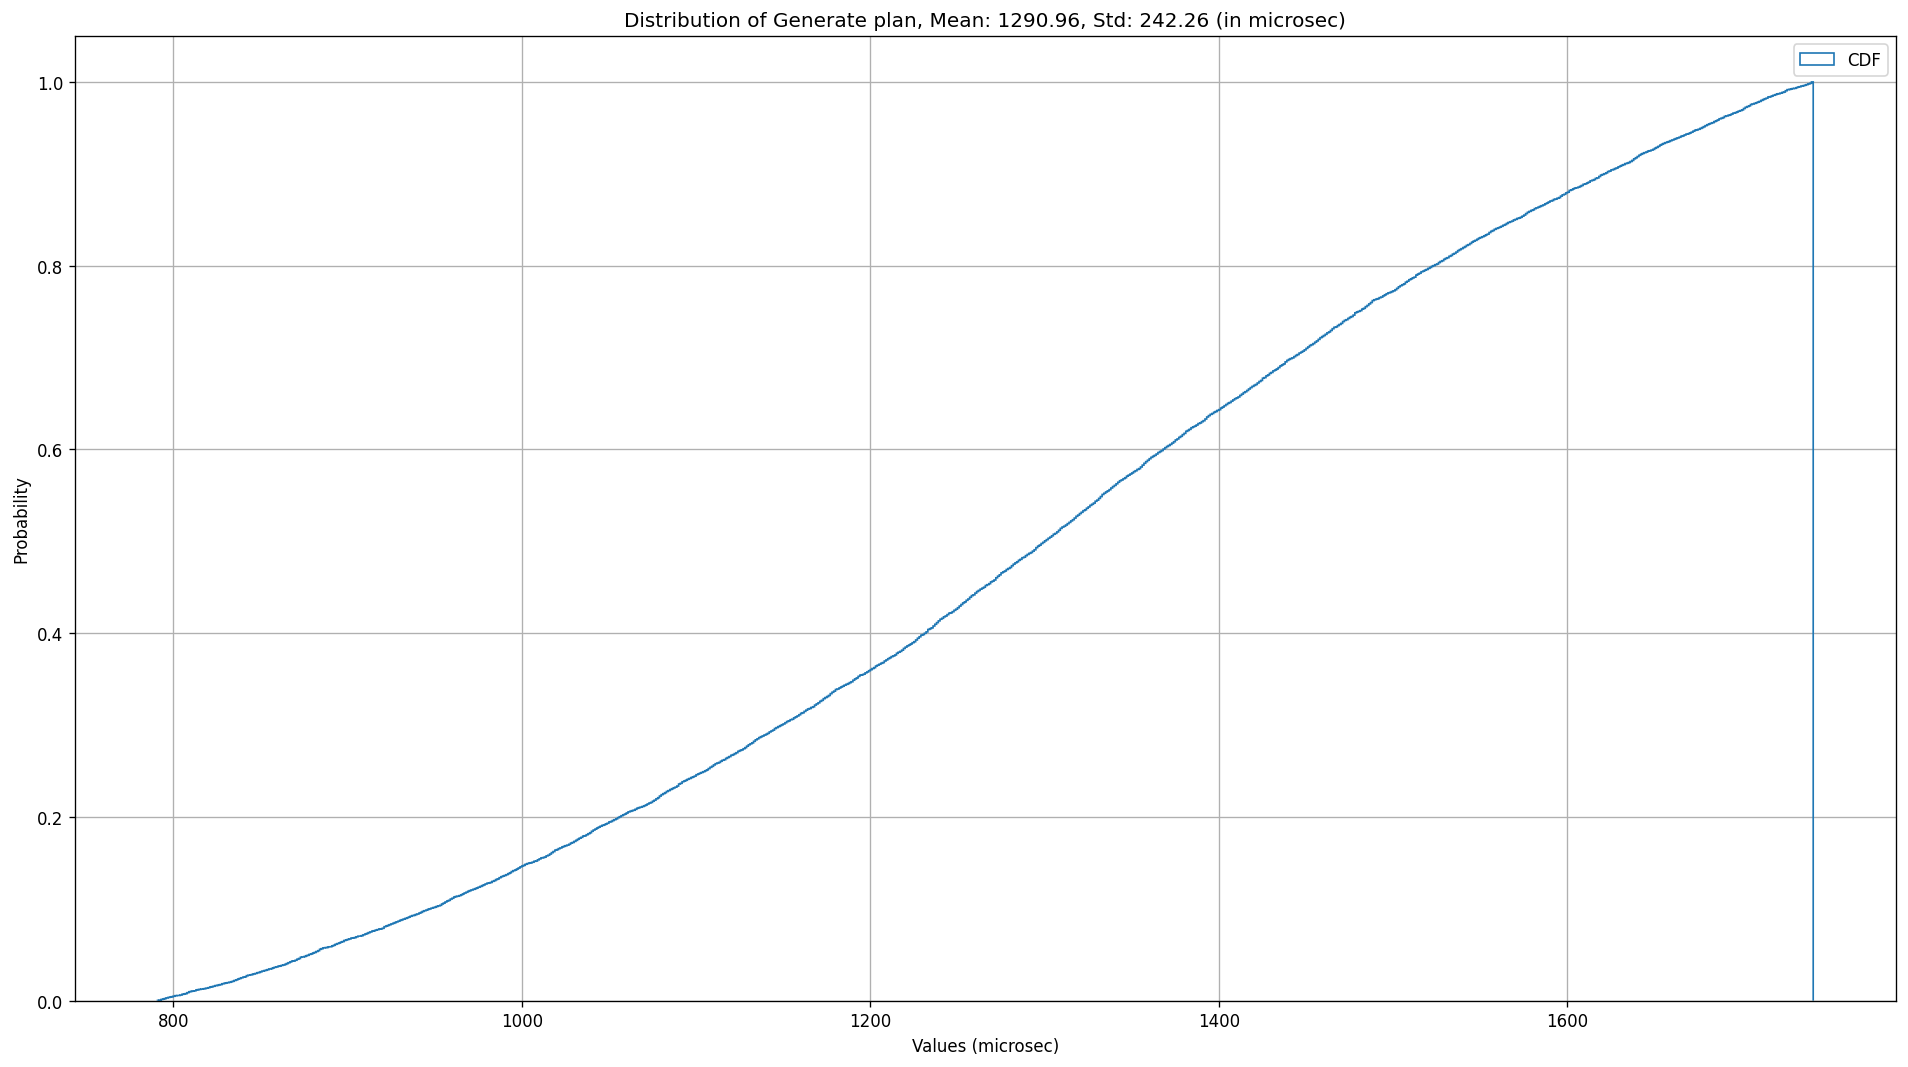

OU1 - Generating Plan Features shape: (10000, 14)


Num of reads  Num of writes  Num of active txs  Thread pool size  \
0              100              0                  1                50   
1              100              0                  1                50   
2              100              0                  1                50   
3              100              0                  1                50   
4              100              0                  1                50   
...            ...            ...                ...               ...   
9995           100              0                  1                50   
9996           100              0                  1                50   
9997           100              0                  1                50   
9998           100              0                  1                50   
9999           100              0                  1                50   

      CPU utilization  Num of cache read  Num of cache insert  \
0                 3.0                200                    0   
1                 2.0                200                    0   
2                 0.0                200                    0   
3                 1.0                200                    0   
4                 1.0                200                    0   
...               ...                ...                  ...   
9995              1.0                200                    0   
9996              1.0                200                    0   
9997              1.0                200                    0   
9998              2.0                200                    0   
9999              2.0                200                    0   

      Num of cache update  Num of arithmetic operations  Num of write record  \
0                       0                             0                    0   
1                       0                             0                    0   
2                       0                             0                    0   
3                       0                             0                    0   
4                       0                             0                    0   
...                   ...                           ...                  ...   
9995                    0                             0                    0   
9996                    0                             0                    0   
9997                    0                             0                    0   
9998                    0                             0                    0   
9999                    0                             0                    0   

      Num of bytes  Num of read write record  Num of log flush bytes  \
0                0                       100                       0   
1                0                       100                       0   
2                0                       100                       0   
3                0                       100                       0   
4                0                       100                       0   
...            ...                       ...                     ...   
9995             0                       100                       0   
9996             0                       100                       0   
9997             0                       100                       0   
9998             0                       100                       0   
9999             0                       100                       0   

      Num of Threads  
0                 53  
1                 67  
2                 67  
3                 67  
4                 67  
...              ...  
9995              67  
9996              67  
9997              67  
9998              67  
9999              67  

[10000 rows x 14 columns]

OU1 - Generating Plan Targets shape: (10000,)


0       1074099
1        791247
2        820378
3        849617
4        897144
         ...   
9995    1282252
9996    1352545
9997    1382493
9998    1255441
9999    1350763
Name: Generate plan, Length: 10000, dtype: int64

In [82]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes',
                'Num of Threads'
                ]
targetName = 'Generate plan'

# Create path for OU
figPathOU = makePath(figPath, targetName)
modelPathOU = makePath(modelPath, targetName)

genPlanFeatures, genPlanTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
                                              warmupDrop=warmupDrop, outlinerDrop=outlinerDropR, sample=sampleN, histUnit=histUnit, isSaveFig=isSaveFig, isSC=isSC)
print(f'OU1 - Generating Plan Features shape: {genPlanFeatures.shape}')
display(genPlanFeatures)
print(f'OU1 - Generating Plan Targets shape: {genPlanTargets.shape}')
display(genPlanTargets)

X_train, X_test, y_train, y_test = train_test_split(genPlanFeatures, genPlanTargets, test_size=testSize, random_state=randomState)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1636/0.1722
Best Params: {'alpha': 1.0, 'gamma': 2.0, 'kernel': 'rbf'}


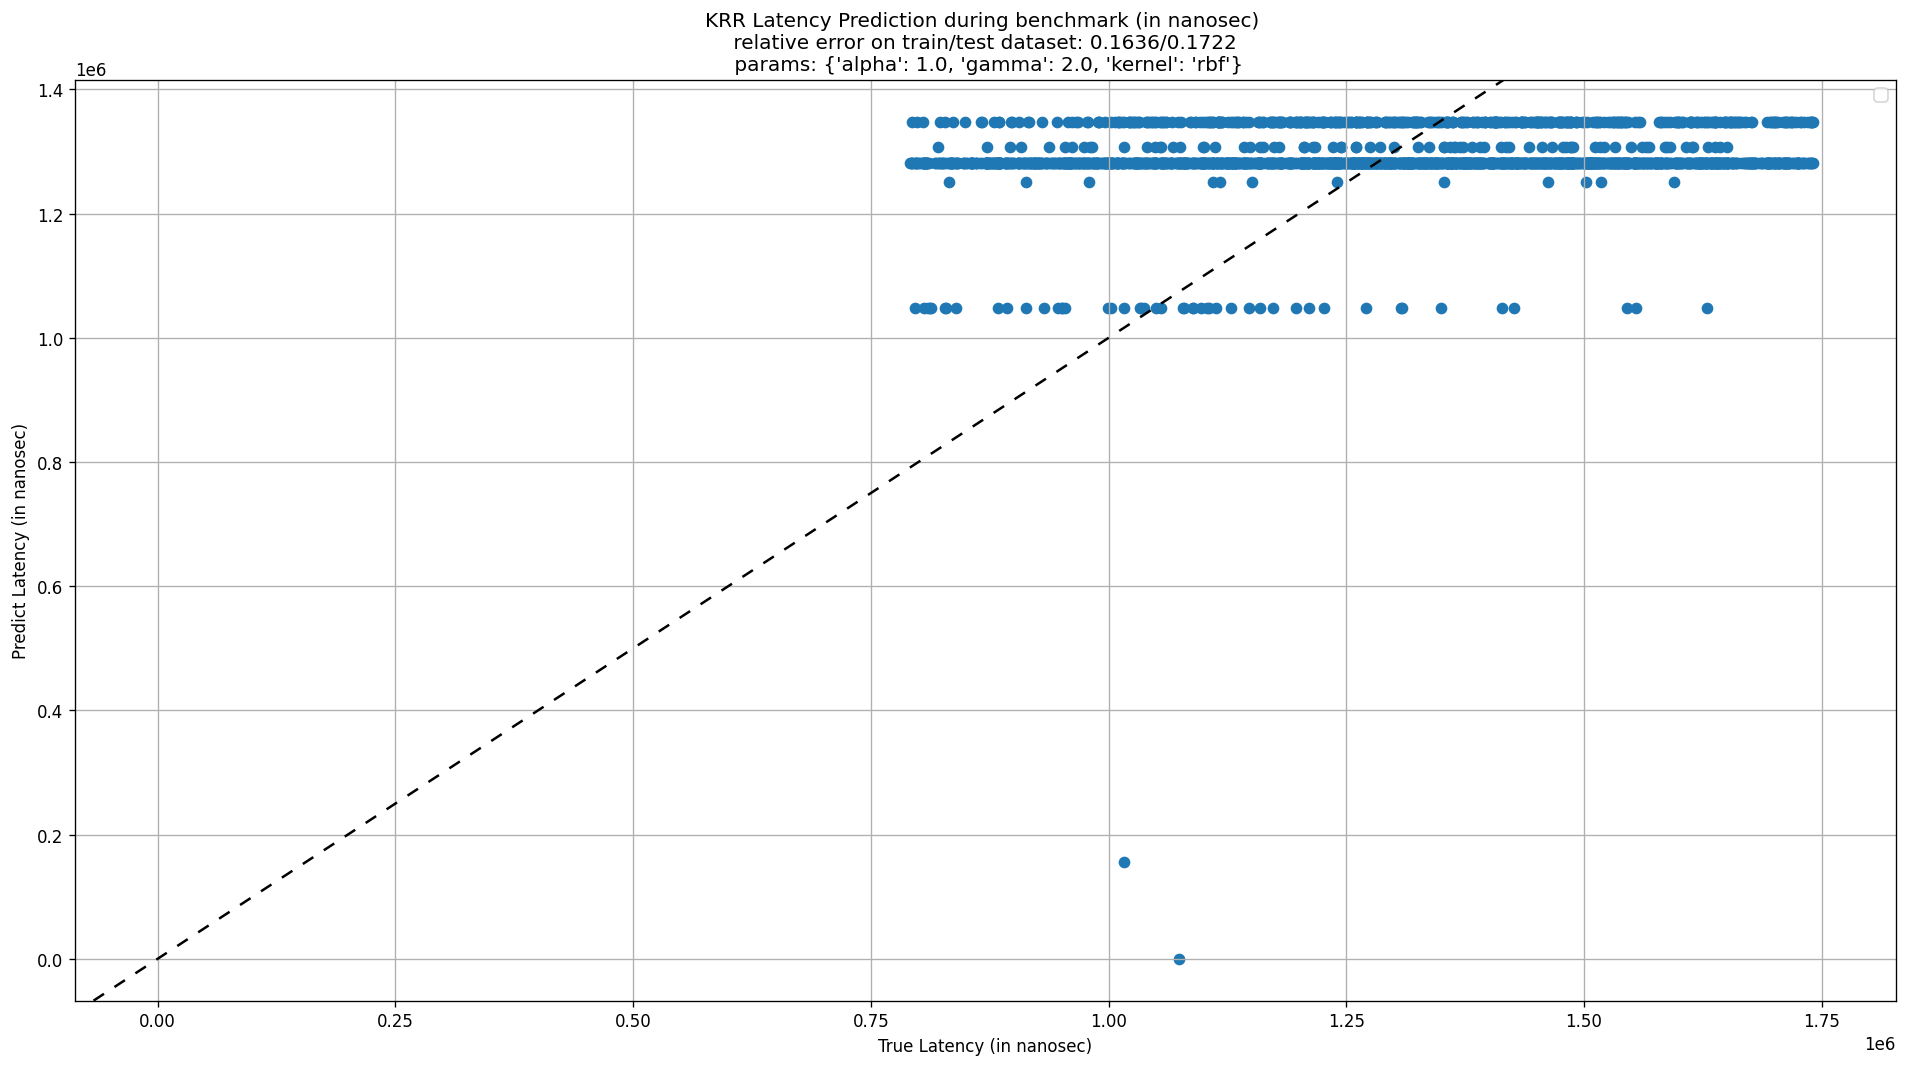

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.16876607 -0.16876339
 -0.16875878 -0.16875435 -0.16876589 -0.16875934 -0.1687516  -0.16874467
 -0.16876539 -0.1687523  -0.16874113 -0.16873488 -0.16876435 -0.1687419
 -0.16872904 -0.16870873]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.1687/0.1755
Best Params: {'C': 4.0, 'gamma': 2.0, 'kernel': 'rbf'}


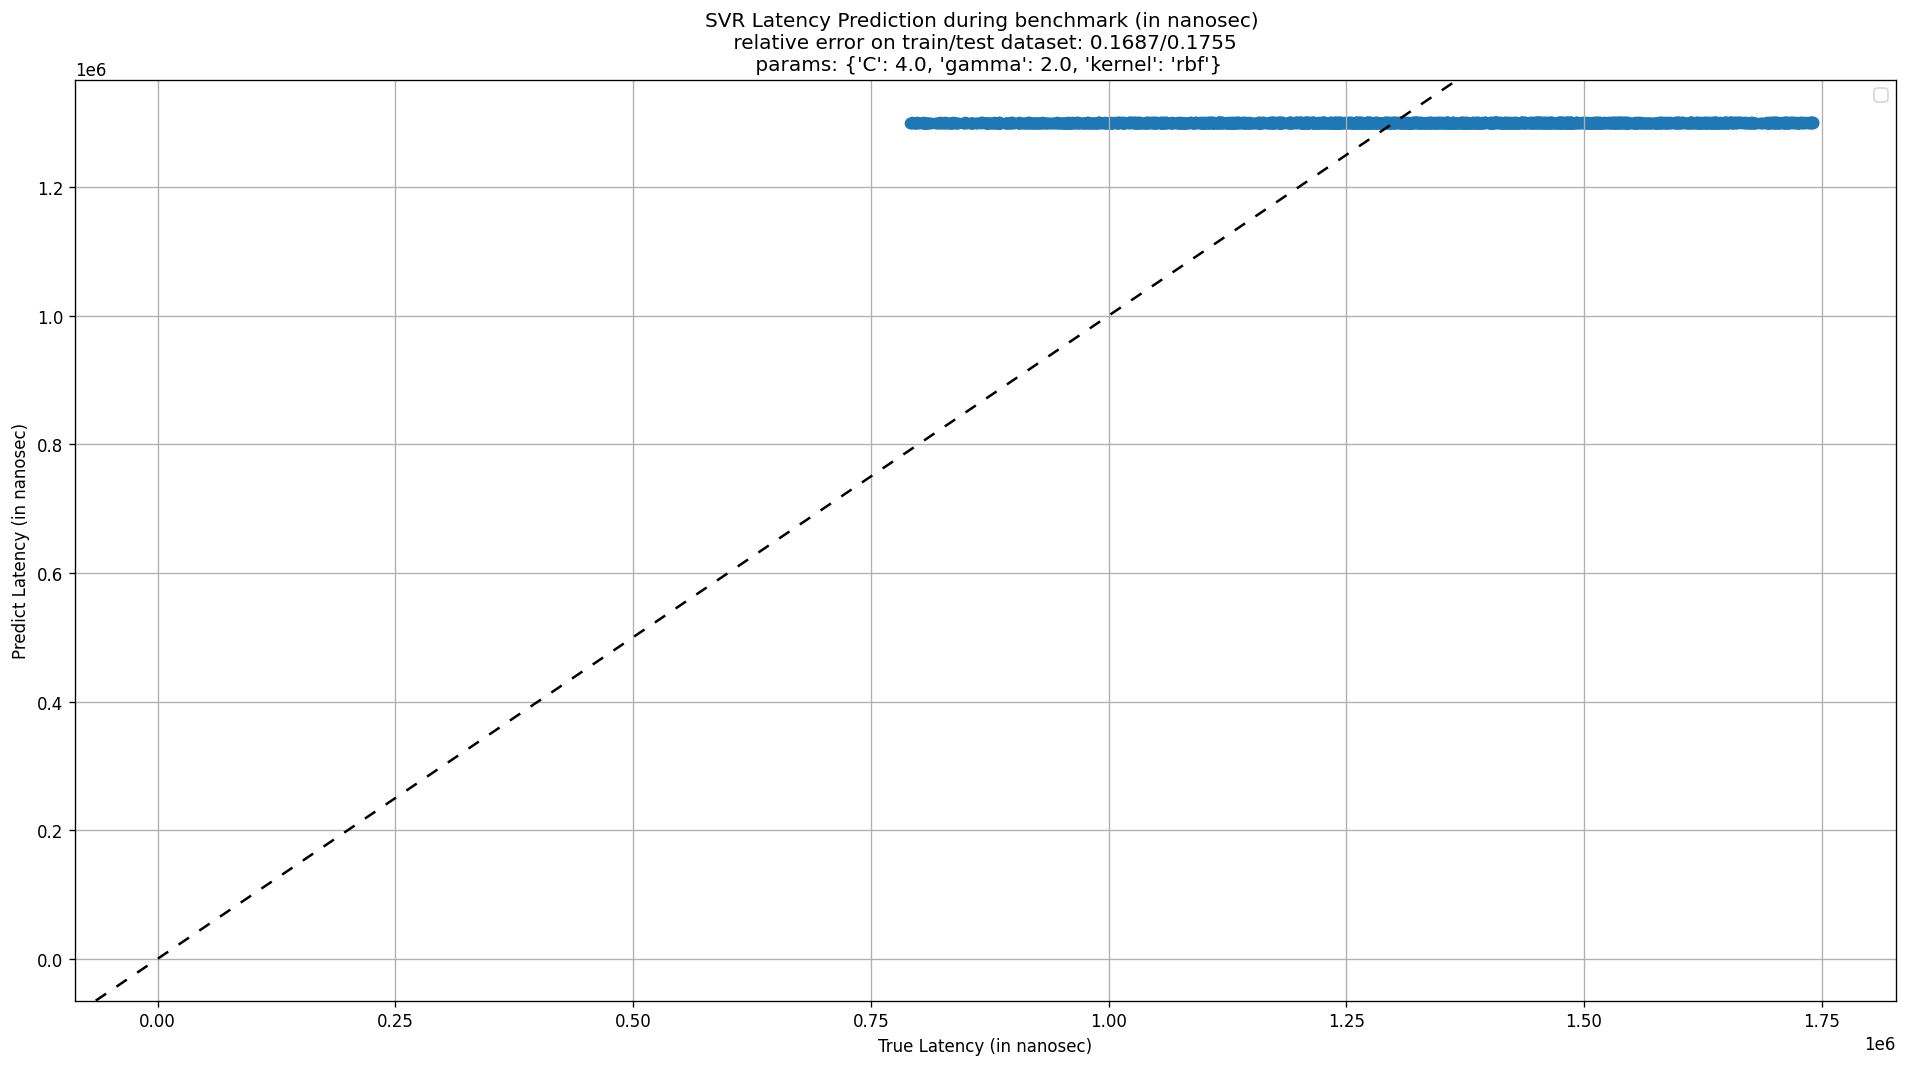

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1675/0.1744
Best Params: {'alpha': 1, 'epsilon': 2}


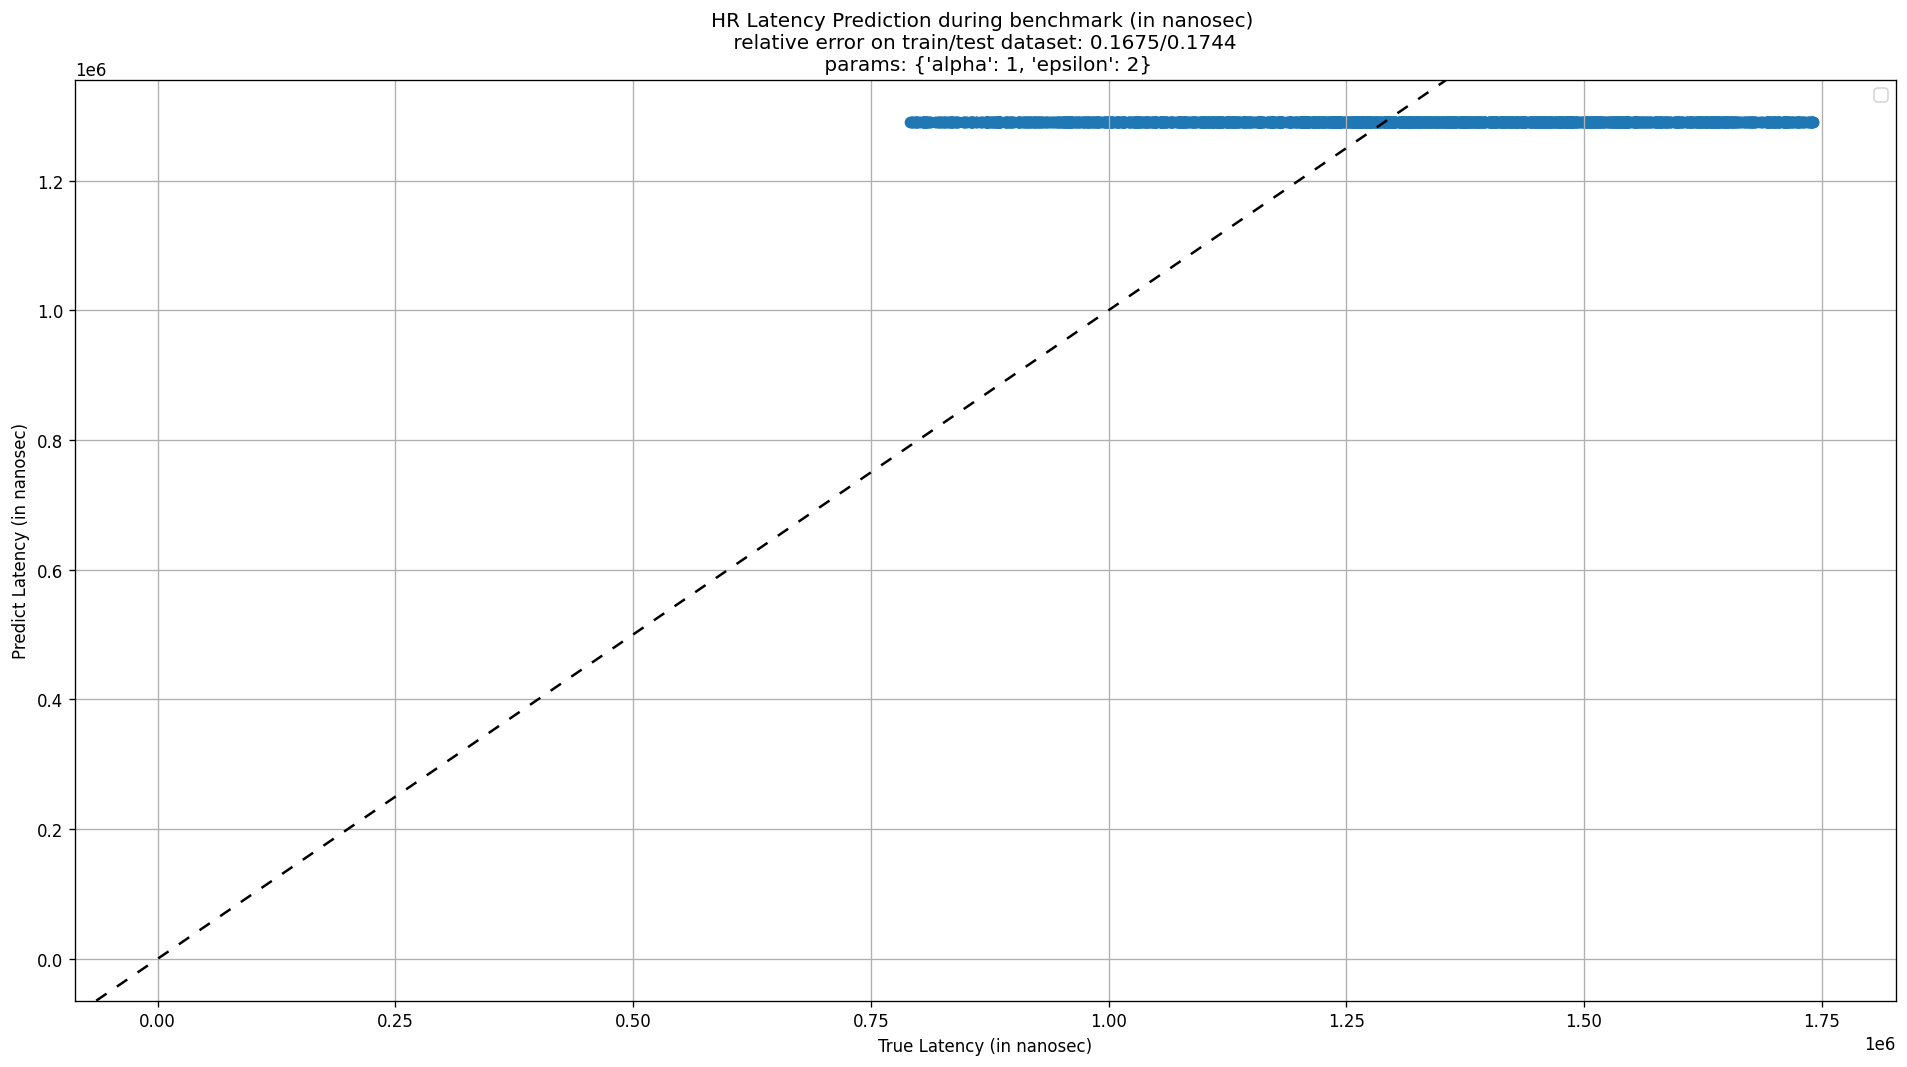

Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1637/0.1715
Best Params: {'criterion': 'mse', 'max_depth': 3, 'n_estimators': 50, 'n_jobs': None, 'random_state': 0}


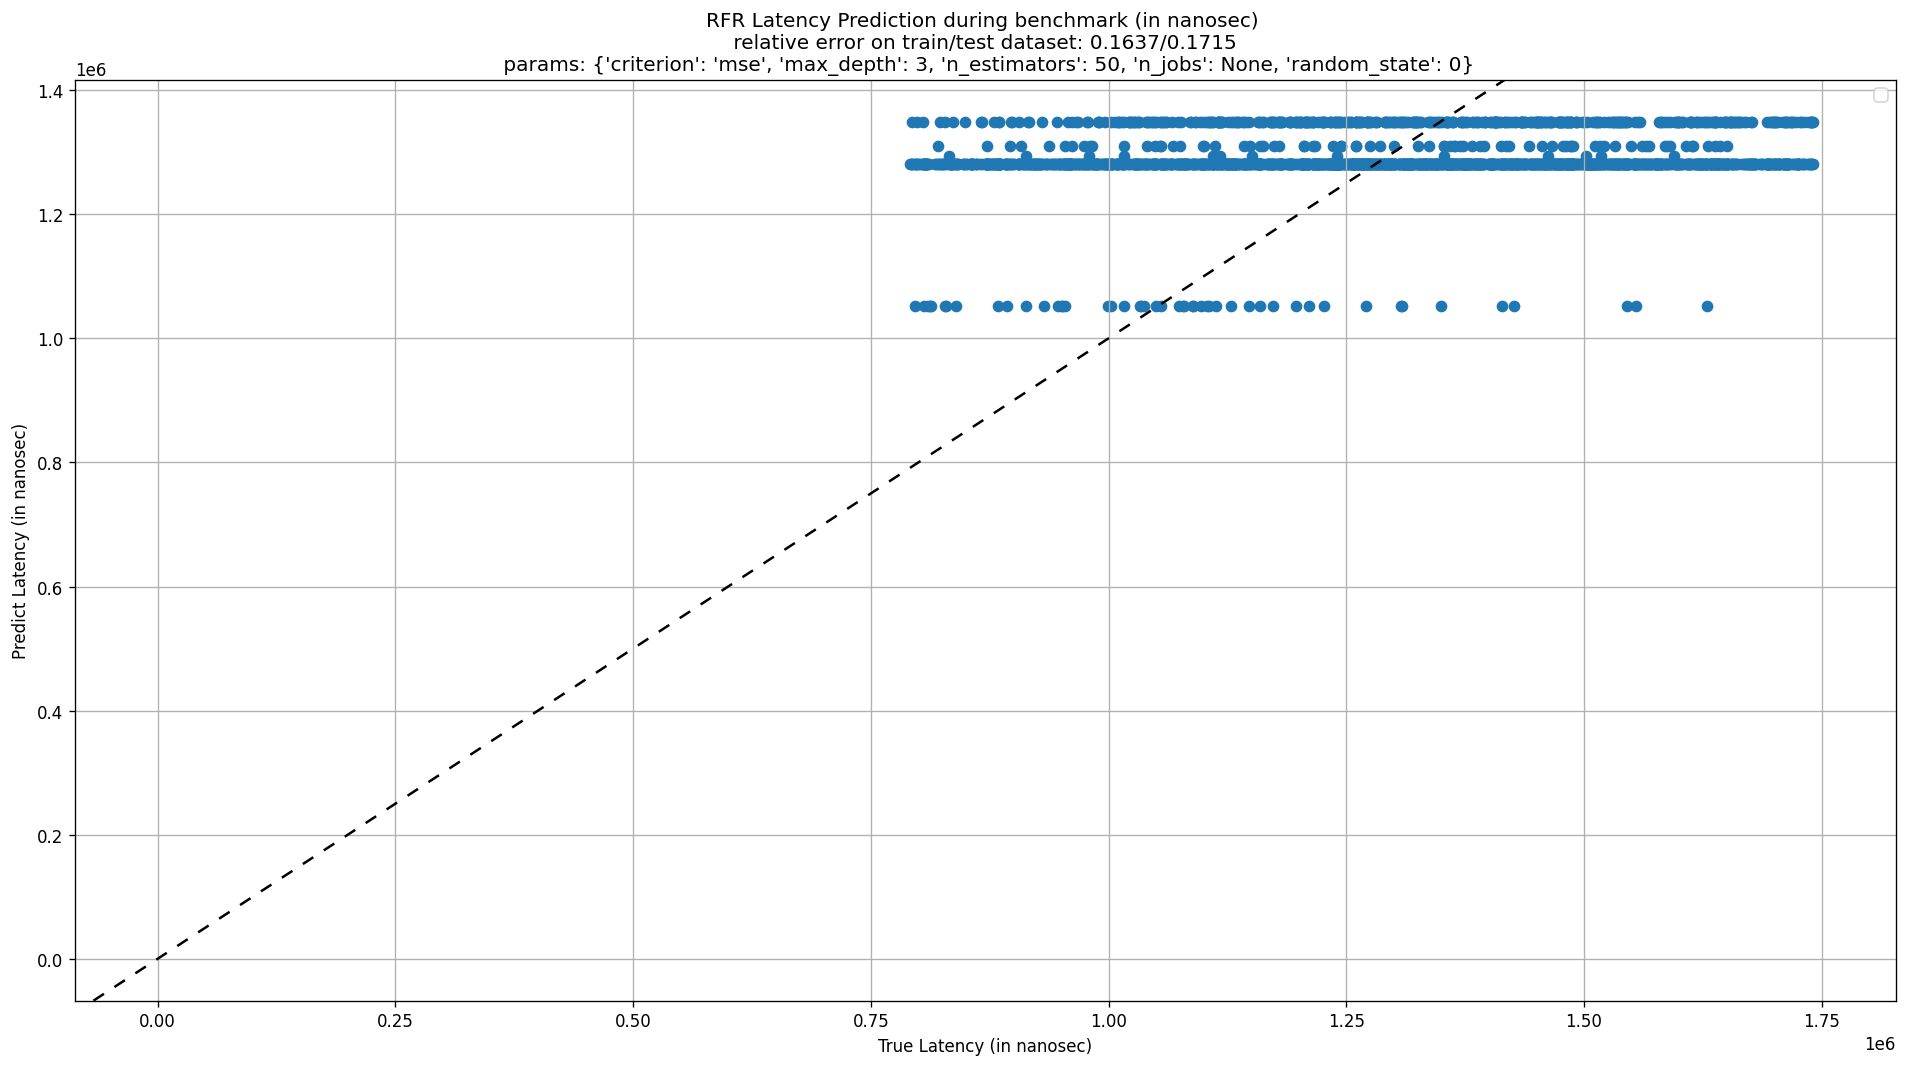

[(GridSearchCV(estimator=KernelRidge(), n_jobs=-1,
               param_grid={'alpha': [1.0], 'gamma': [0.1, 0.5, 1.0, 2.0],
                           'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.1636,
  0.1722),
 (GridSearchCV(estimator=SVR(), n_jobs=-1,
               param_grid={'C': [0, 0.5, 1.0, 2.0, 4.0],
                           'gamma': [0.1, 0.5, 1.0, 2.0], 'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.1687,
  0.1755),
 (GridSearchCV(estimator=HuberRegressor(), n_jobs=-1,
               param_grid={'alpha': [0, 0.0001, 0.01, 0.1, 1],
                           'epsilon': [1.1, 1.35, 2, 5]},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.1675,
  0.1744),
 (GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
               param_grid={'criterion': ['mse', 'mae'],
                           'max_depth': [3, 5, 7, 10],
                     

In [83]:
Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                        figPath=figPathOU, modelPath=modelPathOU, isSaveFig=isSaveFig, isSaveModel=isSaveModel, n_jobs=-1) for m in modelList)